# Image segmentation

UNet is a convolutional network that was designed to segment biomedical images. Its success rates are high even with few images in the training set. In this notebook you will learn to implement and use an UNet for image segmentation.

Requirements:
- matplotlib
- torch
- torchvision
- glob

## The problem

Develop a methodology to segment automatically mouse embryos from microscopy images [source](https://bbbc.broadinstitute.org/BBBC003). The dataset contains 15 grayscale images with their corresponding binary masks.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/datasets/res /content

Mounted at /content/drive


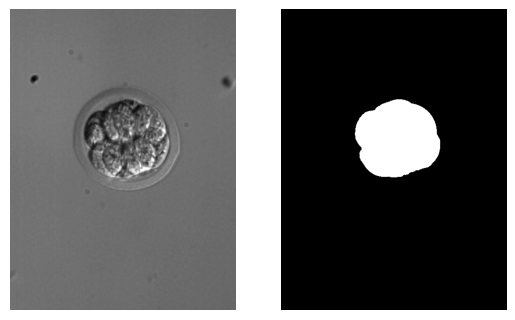

In [ ]:
import matplotlib.pyplot as plt

# Aux function that shows an image and its corresponding mask in the same figure
def show(image, mask, title=None):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image, cmap="gray")
    ax[0].axis('off')
    if title is not None:
        fig.suptitle(title)
    ax[1].imshow(mask, cmap="gray")
    ax[1].axis('off')
    plt.show()
    

im = plt.imread("res/unet/images/7_19_M1E18.tif")
mask = plt.imread("res/unet/masks/7_19_M1E18.tif")
show(im,mask)

## UNet
We are going to segment the images using an UNet. To this end, we are going to follow the next steps:

1. Define the net architecture
2. Generate a training and a validation dataset
3. Train the net
4. Validate the results


First, we set where the code will be run.

In [ ]:
import torch

if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
    
device = torch.device(device_name)
print(f"Code runs in {device}")

Code runs in cuda


### Step 1: Model architecture

You can find online source code for the typical network architectures. In this notebook, we will use [this source code](https://github.com/usuyama/pytorch-unet).

In [ ]:
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )   


class UNet(nn.Module):

    def __init__(self, input_channels, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

### Step 2: Load the data

In this step, we are going to load the data by extending the torch class `Dataset`. 

Since the number of examples in our dataset is small, we can apply some transformations (rotations, traslations, blur, ...) to generate artificial samples and, this way, increase the number of samples in our dataset. This is called data augmentation. You can find more information about data augmentation and its implementation in the [pytorch documentation pages](https://pytorch.org/vision/stable/transforms.html).

In [ ]:
from torch.utils.data import Dataset, DataLoader 
import torchvision.transforms as transforms
import glob
import os
import numpy as np
import random


class EmbryoDataset(Dataset):
    
    def __init__(self, image_path, mask_path, transform = None):
        super().__init__()
        # Load all the filenames with extension tif from the image_path directory
        self.img_files = glob.glob(os.path.join(image_path,'*.tif'))
        self.mask_files = []
        # We asume that each image has the same filename as its corresponding mask
        # but it is stored in another directory (mask_path)
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(mask_path,os.path.basename(img_path)))
                
        self.transform = transform

    # Returns both the image and the mask
    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            image = plt.imread(img_path)
            mask = plt.imread(mask_path)
            if len(mask.shape) > 2:
                # Some tiff images in this dataset has 4 identical channels :S
                mask = mask[:,:,0]
            
            # Apply the defined transformations to both image and mask
            if self.transform is not None:
                seed = np.random.randint(2147483647) # make a seed with numpy generator 
                random.seed(seed) # apply this seed to image transforms
                torch.manual_seed(seed) 
                image = self.transform(image)
                random.seed(seed) # apply the same seed to mask transforms
                torch.manual_seed(seed) 
                mask = self.transform(mask)
            else:
                t2 = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.ToTensor()])
                image = t2(image)
                mask = t2(mask)
                
                
            return image, mask

    def __len__(self):
        return len(self.img_files)


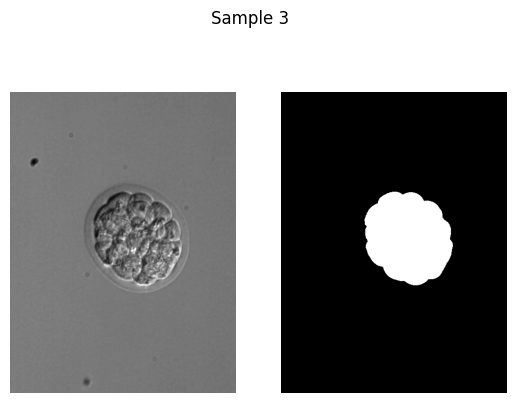

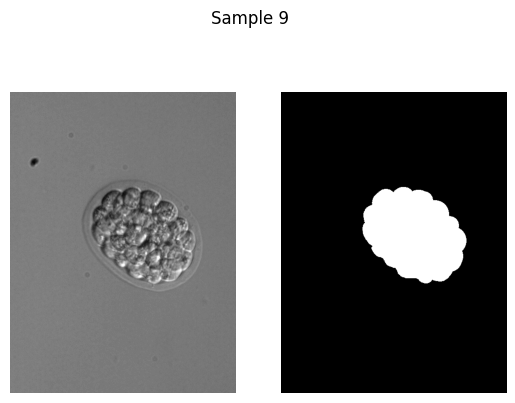

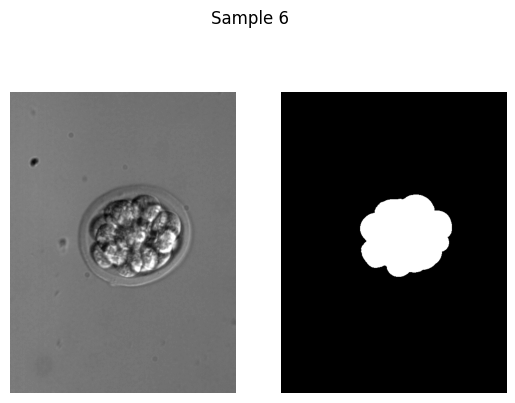

In [ ]:
# Load some samples
simple_dataset = EmbryoDataset("res/unet/images", "res/unet/masks")
nsamples = 3
for _ in range(nsamples):
    idx = np.random.randint(0, len(simple_dataset))
    im, mask = simple_dataset[idx]
    show(im.squeeze(), mask.squeeze(), title=f"Sample {idx}")
    
# Divide the dataset into training and validation datasets
train_dataset, valid_dataset = torch.utils.data.random_split(simple_dataset, [12, 3])

## Step 3: Training

Once the training and validation datasets are created, the next step is training.

#### Exercise
Use the training function that you have implemented in the notebook 1b to train the UNet. Compute the accuracy as the IoU between the segmentation mask and the prediction. 
Feed the net with the original dataset without data augmentation and check the results.

**Hint**: In order to compute the IoU, the function `get_segmentation_masks` can be used to compute a segmentation mask from the outputs of the net. The output of the net is a positive floating point value. The sigmoid function restricts the output domain between 0 and 1. Since the output mask is binary, we use a threshold to set the output mask values to 0 or 1. Note that maybe you should tweak the default threshold.

In [ ]:
def get_segmentation_masks(outputs, threshold=0.3):
    probs = torch.sigmoid(outputs)
    masks = (probs>threshold)*1.0
    return masks


def compute_iou(model_mask, real_mask):
    # Set format
    model_mask = model_mask.reshape(-1, real_mask.shape[-2], real_mask.shape[-1])
    real_mask = real_mask.reshape(-1, real_mask.shape[-2], real_mask.shape[-1])

    # Compute total accuracy (IoU)
    union_area = ((model_mask + real_mask) >= 1. ) * 1.
    intersection_area = model_mask * real_mask
    iou = intersection_area.sum(axis=(1,2)) / union_area.sum(axis=(1,2))
    return iou

In [ ]:
################
#  Train Step
################

def train(model, loader, f_loss, optimizer, device, threshold=0.3, debug=True):
    count = 0
    total_loss = 0.0
    iou_sum = 0
    debug = debug

    model.train()
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        predicted_mask = get_segmentation_masks(outputs, threshold=threshold)

        # Compute the loss
        loss = f_loss(outputs, targets)

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy (IoU)
        iou_sum += compute_iou(predicted_mask,targets).sum().item()

        # Plot IoU
        if debug:
          show(predicted_mask[0].cpu().squeeze(), targets[0].cpu().squeeze(), title="Predicted vs Real mask")
          debug = False # only 1 plot

        # Backpropagate the error to change the model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss/count, iou_sum/count  

In [ ]:
################
#  Test Step
################

def test(model, loader, f_loss, device, threshold=0.3):
    count = 0
    total_loss = 0.0
    iou_sum = 0

    model.eval()
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        predicted_mask = get_segmentation_masks(outputs, threshold=threshold)

        # Compute the loss
        loss = f_loss(outputs, targets)

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy (IoU)
        iou_sum += compute_iou(predicted_mask,targets).sum().item()

    return total_loss/count, iou_sum/count  


In [ ]:
##################
#  Trainig Loop
##################

def train_model(model, train_dataset, valid_dataset, device,
                optimizer, 
                f_loss,
                batch_size=128, 
                num_epochs=20,
                threshold=0.3,
                output_filename='trained-model.pt'):
    
    # Needed variables
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Train
    for epoch in range(num_epochs):
        # Train and validate
        train_loss, train_iou = train(model, train_loader, f_loss, optimizer, device, threshold=threshold)
        val_loss, val_iou = test(model, valid_loader, f_loss, device, threshold=threshold)
        print(f"Epoch {epoch+1}  {train_loss=} {train_iou=} {val_loss=} {val_iou=}")

        # Save the model if it has the best loss or if is the first epoch
        if len(val_losses) == 0:
            torch.save(model, output_filename)
        elif min(val_losses) > val_loss:
            torch.save(model, output_filename)

        # Save information for later plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_iou)
        val_accs.append(val_iou)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="validation")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("IoU")
    plt.plot(train_accs, label="train")
    plt.plot(val_accs, label="validation")
    plt.legend()
    plt.show()    


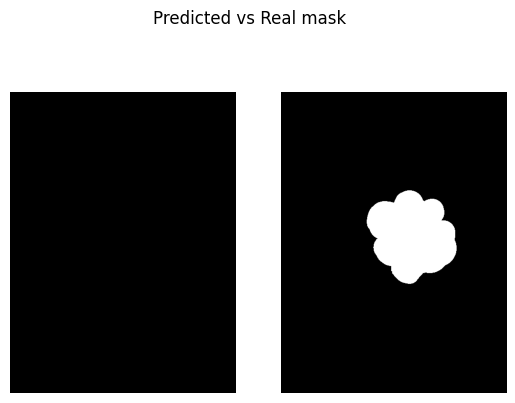

Epoch 1  train_loss=0.7153969208399454 train_iou=0.08329020068049431 val_loss=0.7048216462135315 val_iou=0.09679904331763585


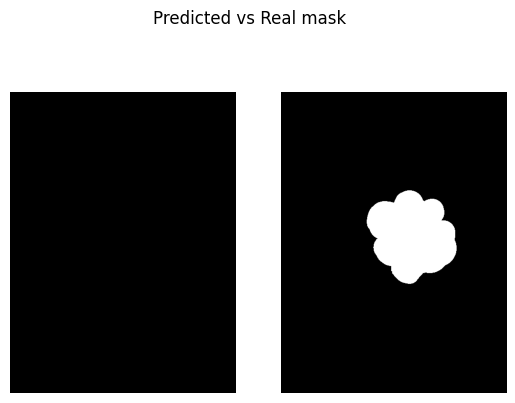

Epoch 2  train_loss=0.6955426434675852 train_iou=0.08329020068049431 val_loss=0.6738587021827698 val_iou=0.09679904331763585


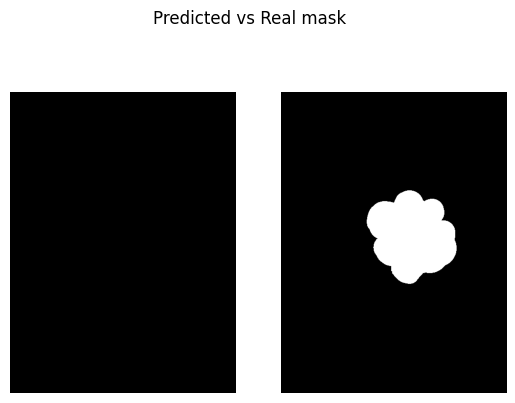

Epoch 3  train_loss=0.559932291507721 train_iou=0.06909667824705441 val_loss=0.336785227060318 val_iou=0.0


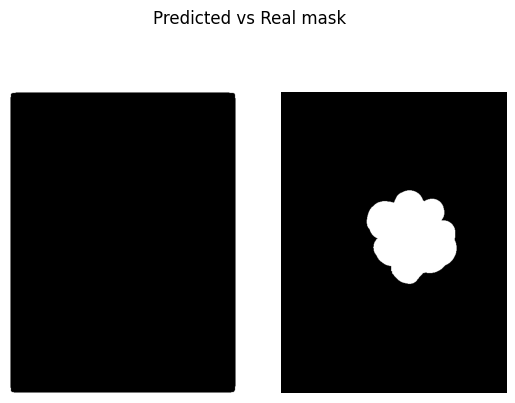

Epoch 4  train_loss=0.34772605697313946 train_iou=0.0 val_loss=0.35016863544782 val_iou=0.0


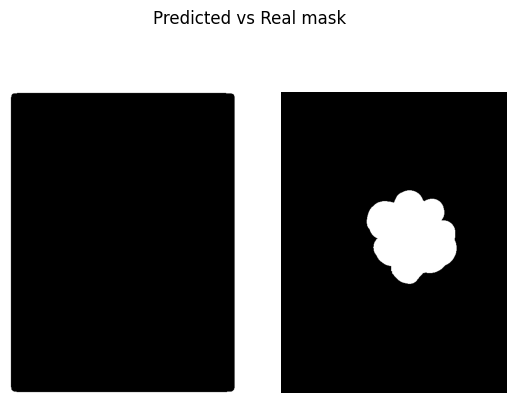

Epoch 5  train_loss=0.32885758578777313 train_iou=0.0 val_loss=0.3394788106282552 val_iou=0.0


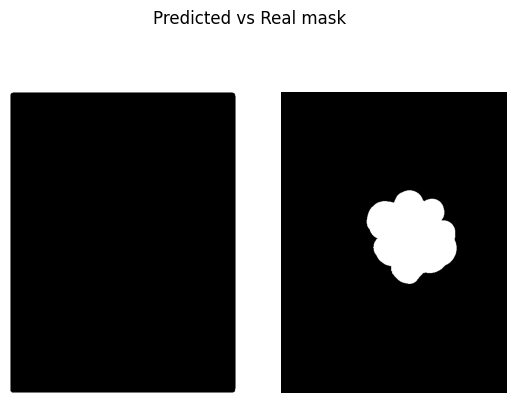

Epoch 6  train_loss=0.30873343845208484 train_iou=0.0 val_loss=0.33067335685094196 val_iou=0.0


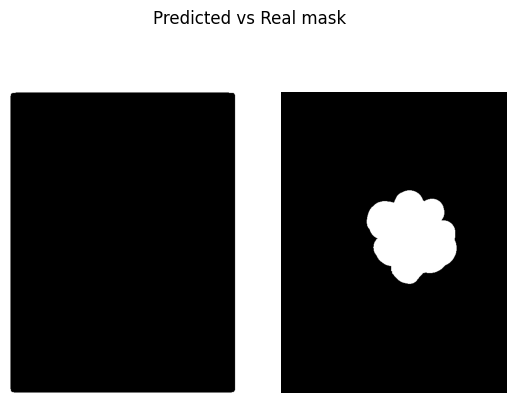

Epoch 7  train_loss=0.3026849279801051 train_iou=0.0 val_loss=0.3326783875624339 val_iou=0.0


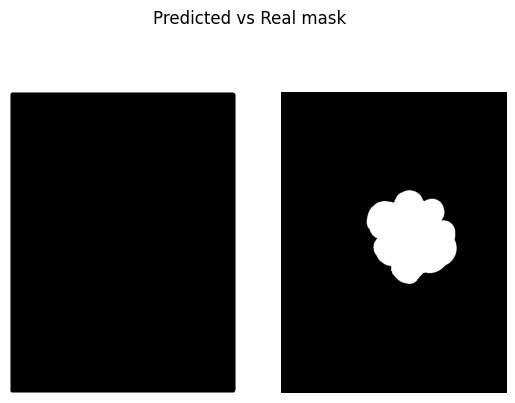

Epoch 8  train_loss=0.2973718196153641 train_iou=0.0 val_loss=0.3253658910592397 val_iou=0.0


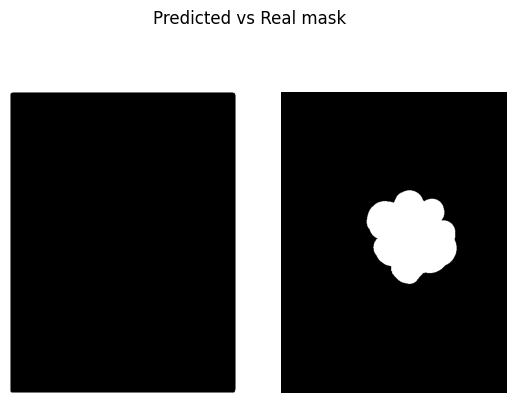

Epoch 9  train_loss=0.2938433090845744 train_iou=0.0 val_loss=0.32569076617558795 val_iou=0.0


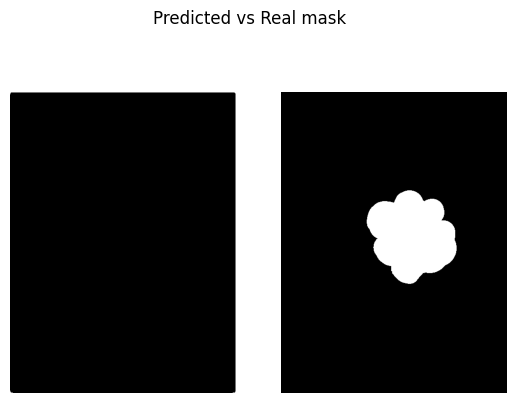

Epoch 10  train_loss=0.28899531563123065 train_iou=0.0 val_loss=0.31725839773813885 val_iou=0.0


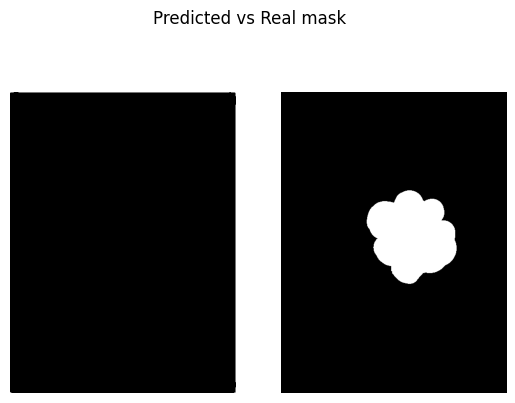

Epoch 11  train_loss=0.28252994020779926 train_iou=0.0 val_loss=0.3095542589823405 val_iou=0.0


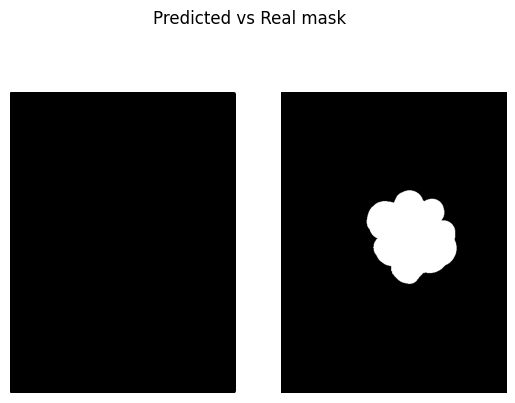

Epoch 12  train_loss=0.27444560329119366 train_iou=0.0 val_loss=0.2995465745528539 val_iou=0.0


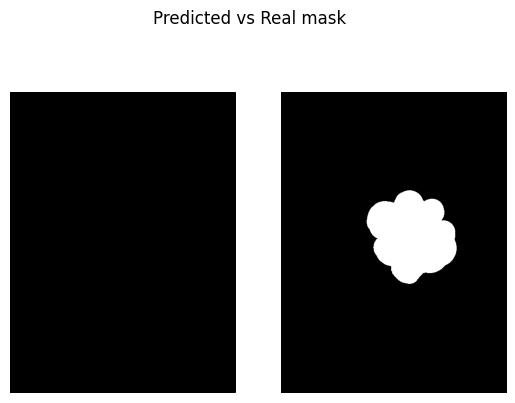

Epoch 13  train_loss=0.26604647437731427 train_iou=0.0 val_loss=0.2909874717394511 val_iou=0.0


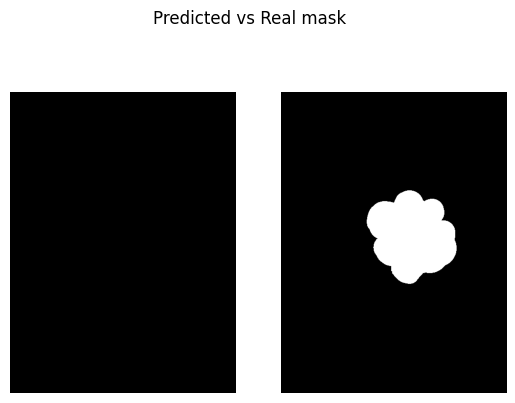

Epoch 14  train_loss=0.2583295578757922 train_iou=0.0 val_loss=0.2839428981145223 val_iou=0.0


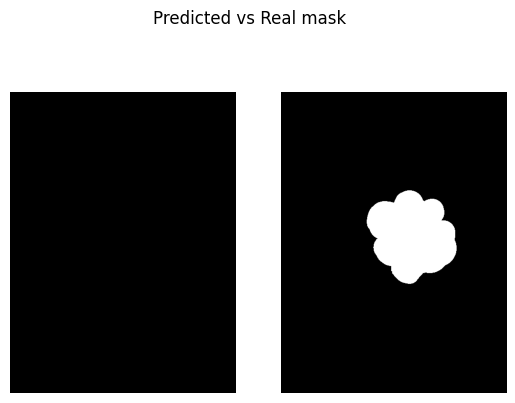

Epoch 15  train_loss=0.24994639803965887 train_iou=0.0 val_loss=0.2744981050491333 val_iou=0.0


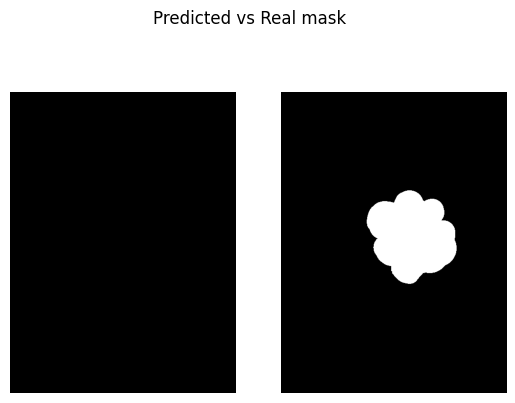

Epoch 16  train_loss=0.23545525968074799 train_iou=0.0 val_loss=0.2568575938542684 val_iou=0.0


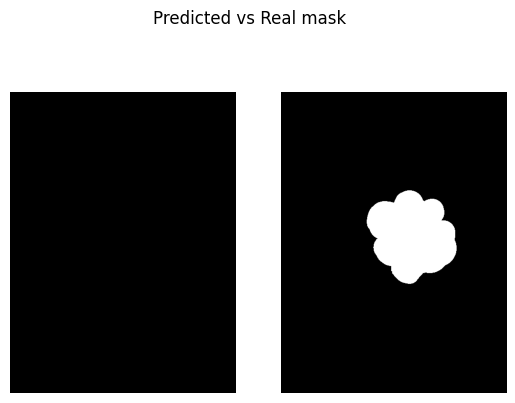

Epoch 17  train_loss=0.2046040172378222 train_iou=0.0 val_loss=0.271901731689771 val_iou=0.0


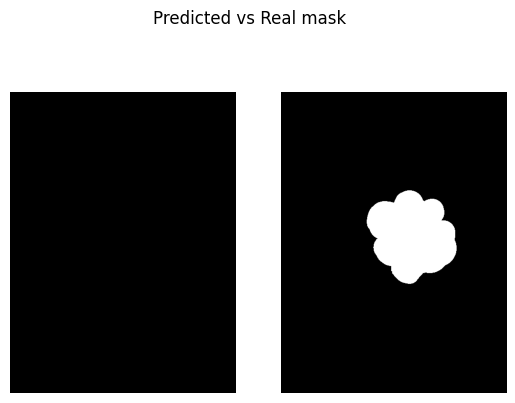

Epoch 18  train_loss=0.1743534505367279 train_iou=0.28669958057192463 val_loss=0.19286674757798514 val_iou=0.9062079389890035


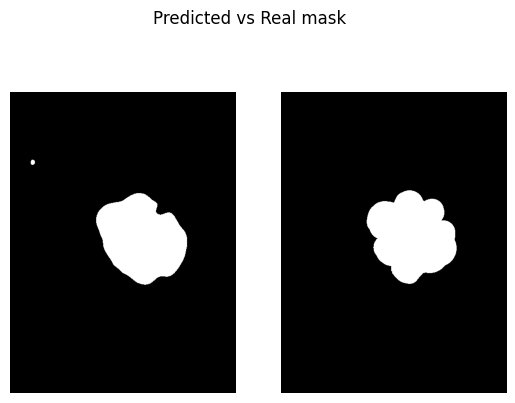

Epoch 19  train_loss=0.12224246685703595 train_iou=0.6903744339942932 val_loss=0.17544973393281302 val_iou=0.24525927752256393


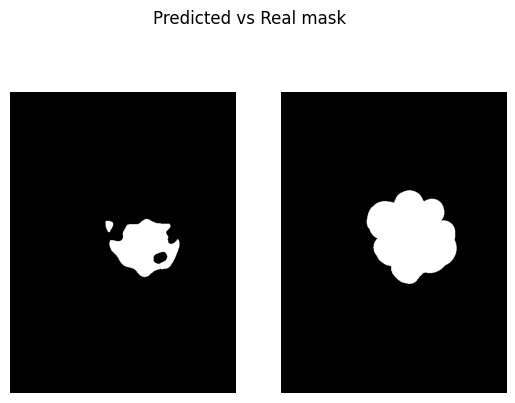

Epoch 20  train_loss=0.14286980653802553 train_iou=0.5016187702616056 val_loss=0.24670695265134177 val_iou=0.3975800673166911


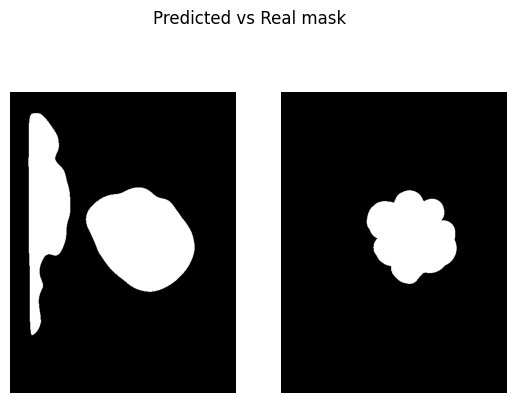

Epoch 21  train_loss=0.10664656634132068 train_iou=0.7011496971050898 val_loss=0.11964926371971767 val_iou=0.8506296078364054


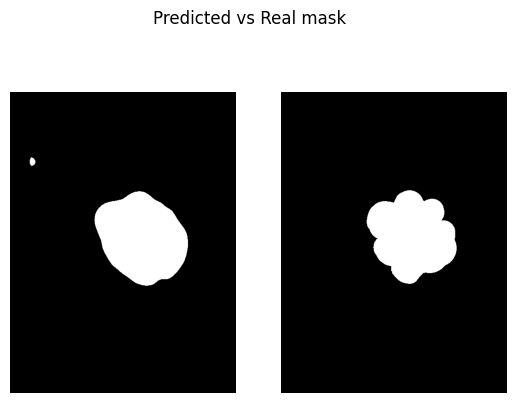

Epoch 22  train_loss=0.08716078475117683 train_iou=0.8375624418258667 val_loss=0.10656518737475078 val_iou=0.7321172952651978


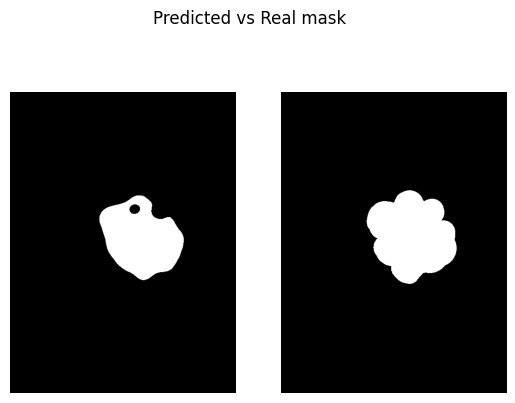

Epoch 23  train_loss=0.07821420952677727 train_iou=0.8465875585873922 val_loss=0.08485976854960124 val_iou=0.9008084734280905


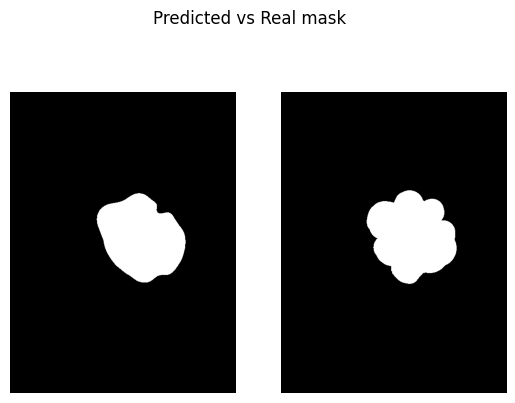

Epoch 24  train_loss=0.07205819711089134 train_iou=0.8824394543965658 val_loss=0.09809696674346924 val_iou=0.8019289374351501


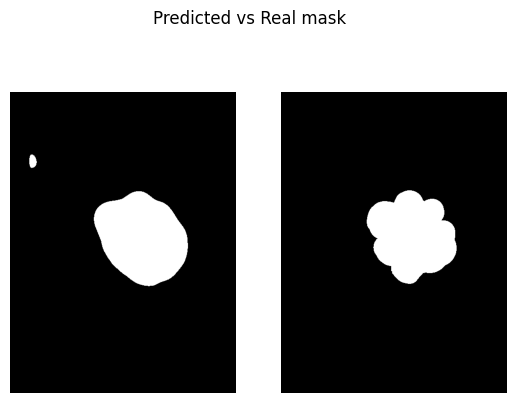

Epoch 25  train_loss=0.07111291339000066 train_iou=0.8748238484064738 val_loss=0.08100722978512447 val_iou=0.8938661615053812


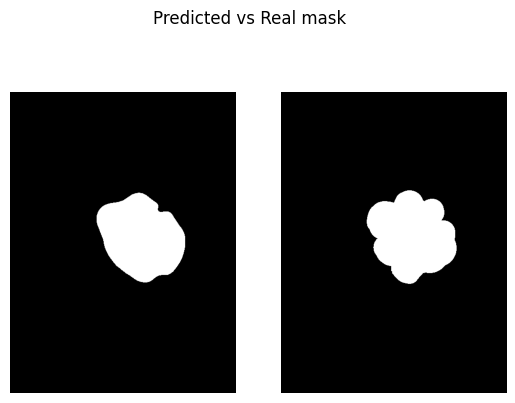

Epoch 26  train_loss=0.06908575693766277 train_iou=0.8795448939005533 val_loss=0.07976837456226349 val_iou=0.8898845513661703


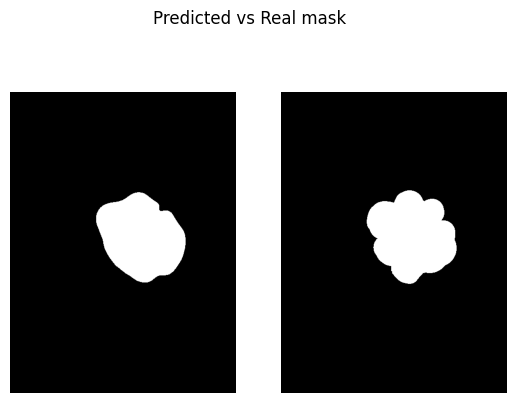

Epoch 27  train_loss=0.06745839739839236 train_iou=0.891554206609726 val_loss=0.07921393464008968 val_iou=0.8808741370836893


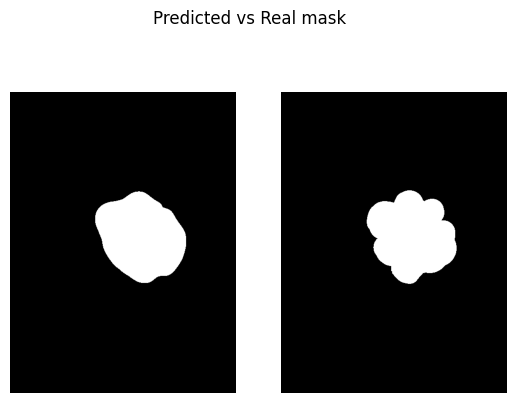

Epoch 28  train_loss=0.0662341012308995 train_iou=0.8973306715488434 val_loss=0.07786583279569943 val_iou=0.882344126701355


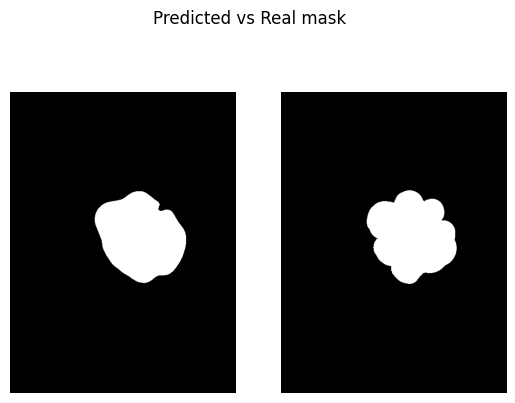

Epoch 29  train_loss=0.06524145106474559 train_iou=0.9014304081598917 val_loss=0.07726632431149483 val_iou=0.8781906565030416


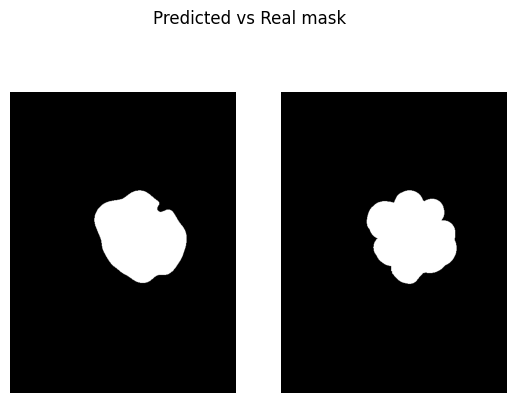

Epoch 30  train_loss=0.06418887463708718 train_iou=0.9071182509263357 val_loss=0.07636896645029385 val_iou=0.8771825234095255


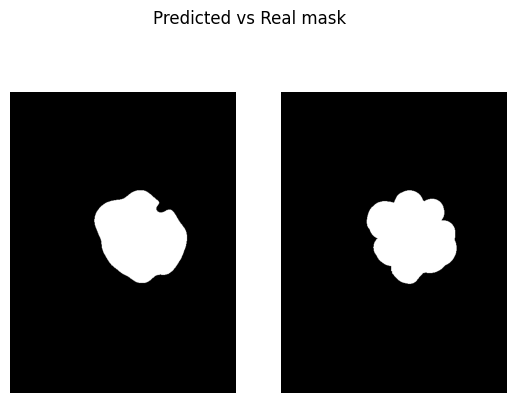

Epoch 31  train_loss=0.06311868627866109 train_iou=0.9083064297835032 val_loss=0.07495672504107158 val_iou=0.8716952602068583


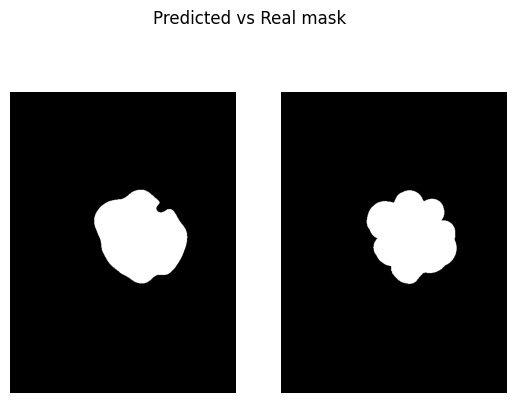

Epoch 32  train_loss=0.0603549238294363 train_iou=0.9087647596995035 val_loss=0.06838120395938556 val_iou=0.873973548412323


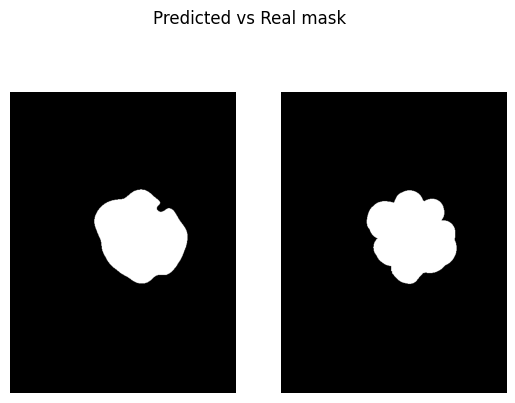

Epoch 33  train_loss=0.047185830771923065 train_iou=0.9050561487674713 val_loss=0.07393275946378708 val_iou=0.8177269101142883


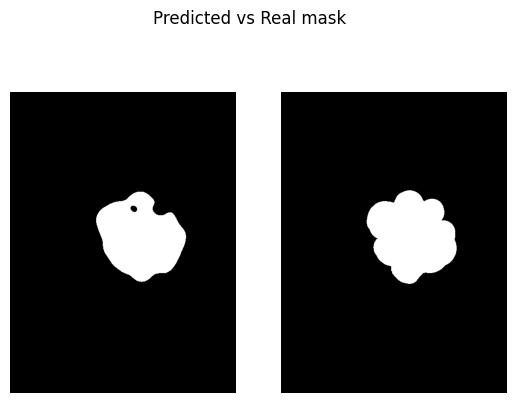

Epoch 34  train_loss=0.039692054502666 train_iou=0.8521604835987091 val_loss=0.03480011597275734 val_iou=0.8740083575248718


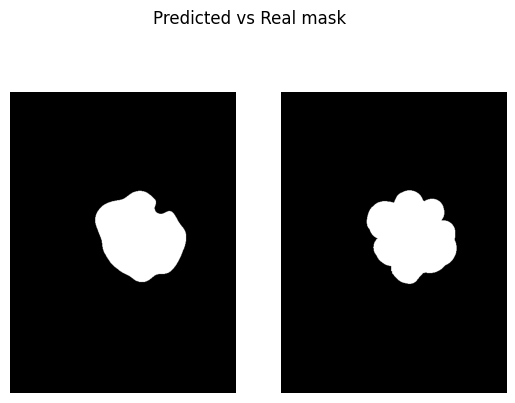

Epoch 35  train_loss=0.021814351125309866 train_iou=0.8996096650759379 val_loss=0.046493167678515114 val_iou=0.8331451416015625


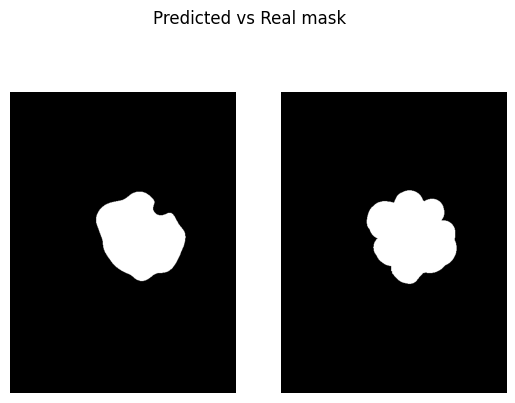

Epoch 36  train_loss=0.021674050639073055 train_iou=0.8988759219646454 val_loss=0.06697507202625275 val_iou=0.7670857111612955


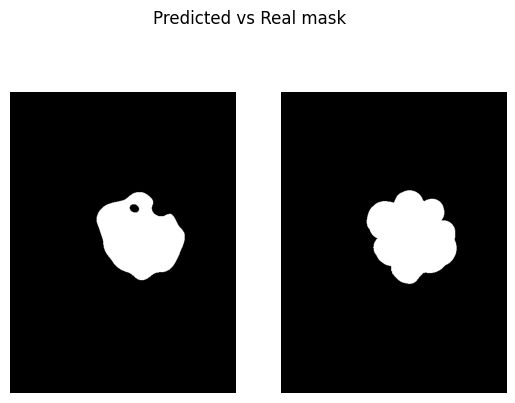

Epoch 37  train_loss=0.024712318864961464 train_iou=0.8771546880404154 val_loss=0.07057689627011617 val_iou=0.7578307787577311


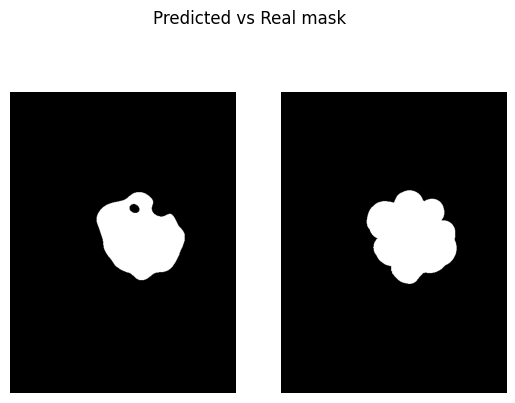

Epoch 38  train_loss=0.0252442325775822 train_iou=0.8728211422761282 val_loss=0.04304158315062523 val_iou=0.8529033859570821


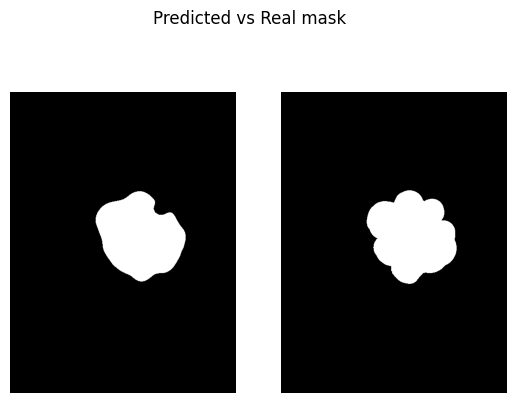

Epoch 39  train_loss=0.022190152512242396 train_iou=0.900490790605545 val_loss=0.02797130246957143 val_iou=0.8802693287531534


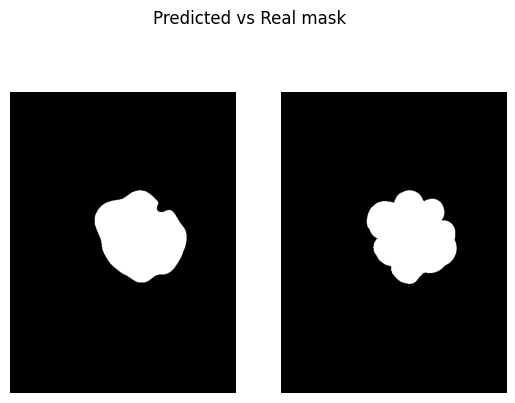

Epoch 40  train_loss=0.019842225903024275 train_iou=0.9105717043081919 val_loss=0.028439684460560482 val_iou=0.8734731674194336


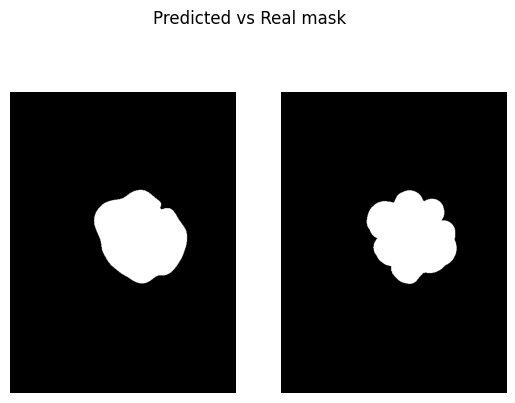

Epoch 41  train_loss=0.01783670453975598 train_iou=0.9136764804522196 val_loss=0.026836025218168896 val_iou=0.8793511589368185


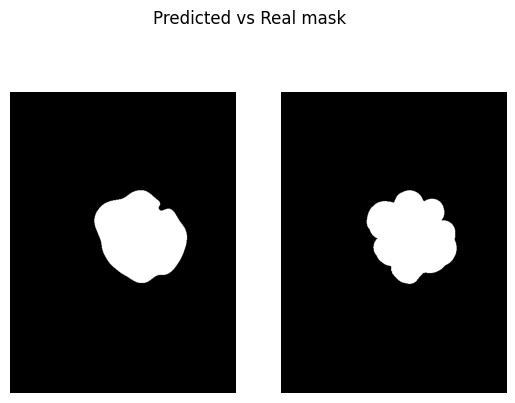

Epoch 42  train_loss=0.016288172608862322 train_iou=0.9168600539366404 val_loss=0.02667476360996564 val_iou=0.8850178718566895


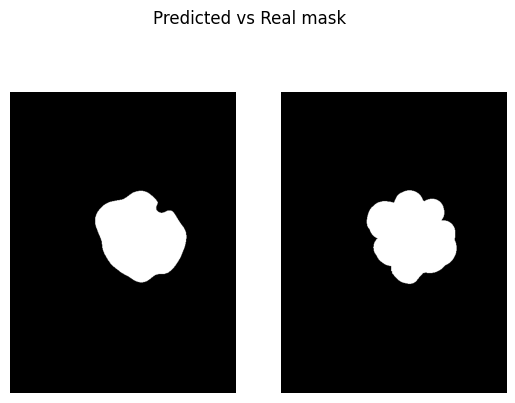

Epoch 43  train_loss=0.015870438267787296 train_iou=0.9186267256736755 val_loss=0.028254921237627666 val_iou=0.8839783469835917


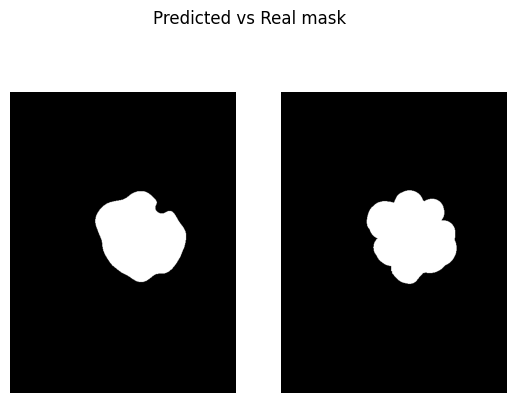

Epoch 44  train_loss=0.016016458937277395 train_iou=0.9193136791388193 val_loss=0.027568199982245762 val_iou=0.8849212924639384


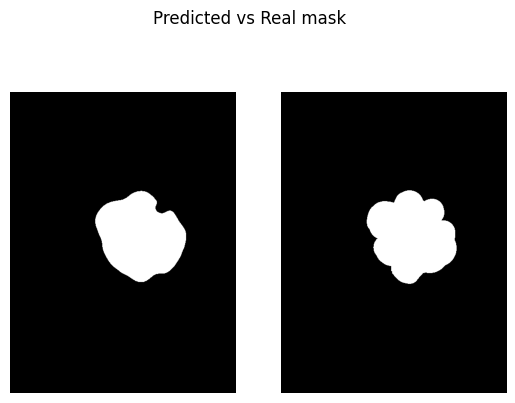

Epoch 45  train_loss=0.015969756214569013 train_iou=0.9201169610023499 val_loss=0.025800729791323345 val_iou=0.8869254986445109


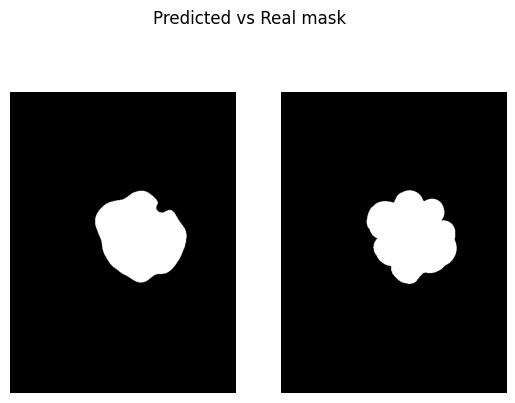

Epoch 46  train_loss=0.01566710074742635 train_iou=0.9207413494586945 val_loss=0.024765711277723312 val_iou=0.8885589838027954


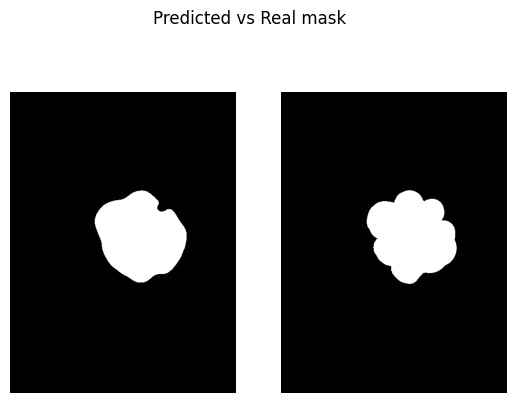

Epoch 47  train_loss=0.015190373795727888 train_iou=0.9217021365960439 val_loss=0.02419319935142994 val_iou=0.8898742397626241


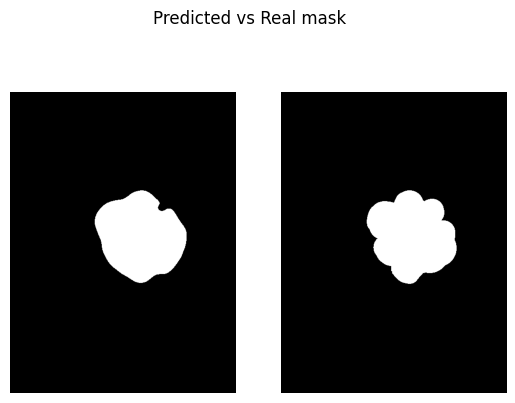

Epoch 48  train_loss=0.014641395304352045 train_iou=0.9233747323354086 val_loss=0.023656155293186504 val_iou=0.8929403026898702


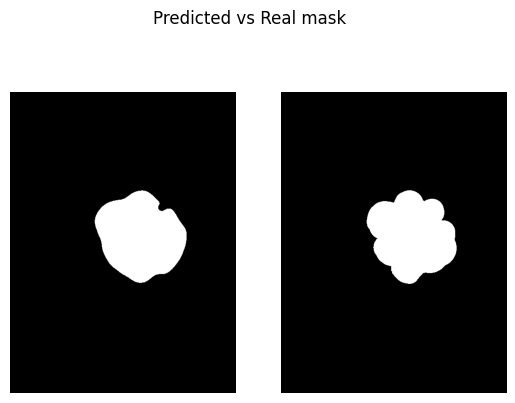

Epoch 49  train_loss=0.014107919453332821 train_iou=0.9249750375747681 val_loss=0.023179328069090843 val_iou=0.8960787256558737


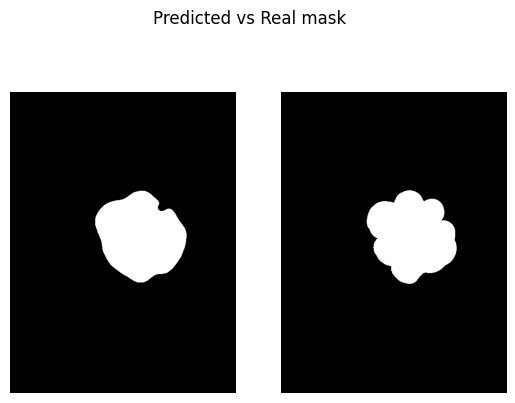

Epoch 50  train_loss=0.013647560030221939 train_iou=0.9270868599414825 val_loss=0.022685278827945392 val_iou=0.8992755015691122


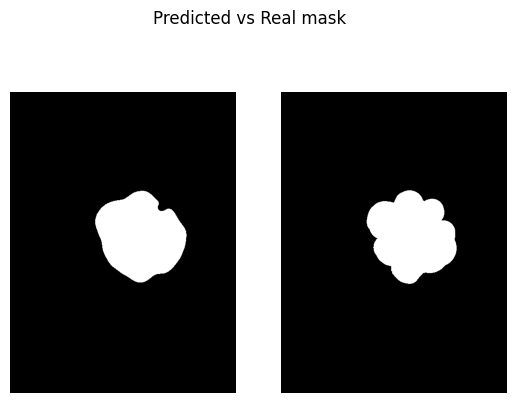

Epoch 51  train_loss=0.013221097644418478 train_iou=0.9295252561569214 val_loss=0.02216459314028422 val_iou=0.9014691313107809


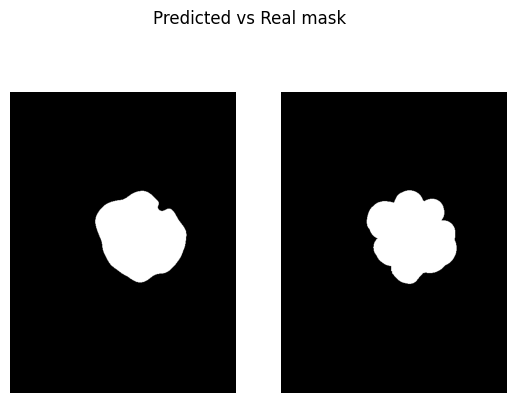

Epoch 52  train_loss=0.01280127465724945 train_iou=0.9318457245826721 val_loss=0.021725351611773174 val_iou=0.9034354488054911


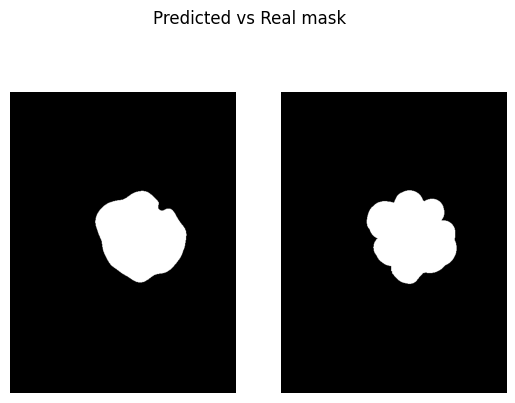

Epoch 53  train_loss=0.012384800395617882 train_iou=0.9346020221710205 val_loss=0.02142760468026002 val_iou=0.9055372675259908


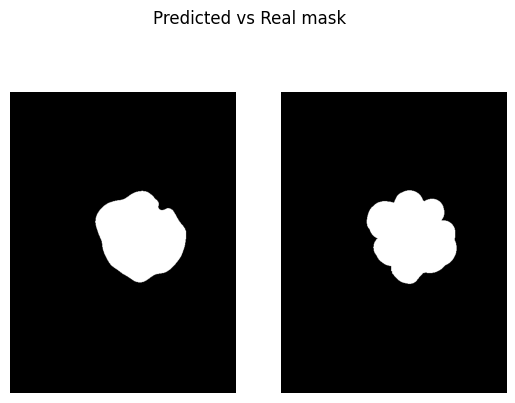

Epoch 54  train_loss=0.01197843129436175 train_iou=0.9371579686800638 val_loss=0.02117288609345754 val_iou=0.9073191086451212


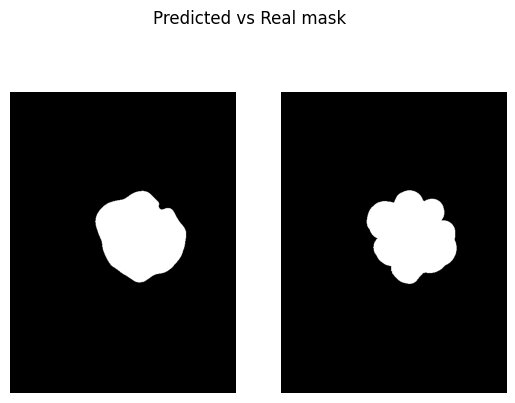

Epoch 55  train_loss=0.0115850823931396 train_iou=0.9391869405905405 val_loss=0.020946998770038288 val_iou=0.909119725227356


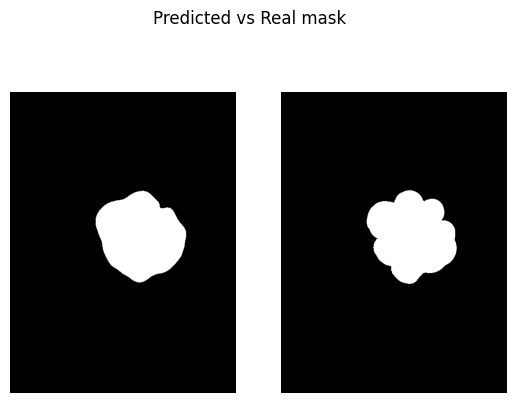

Epoch 56  train_loss=0.011209480464458466 train_iou=0.9408726791540781 val_loss=0.0205745833615462 val_iou=0.9112013379732767


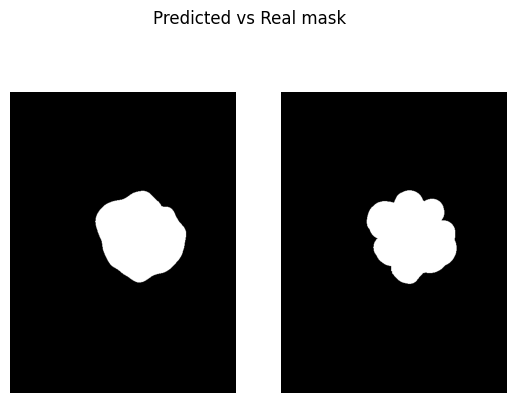

Epoch 57  train_loss=0.010833019390702248 train_iou=0.9425951341787974 val_loss=0.020262741794188816 val_iou=0.9135010441144308


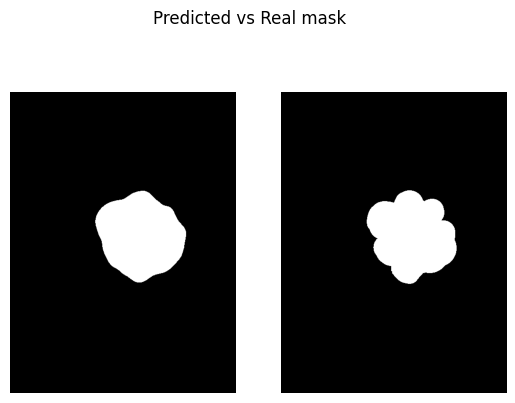

Epoch 58  train_loss=0.010433696365604797 train_iou=0.9445423781871796 val_loss=0.020183295011520386 val_iou=0.9153216282526652


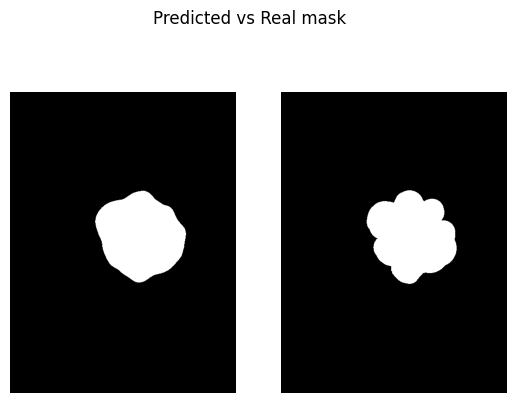

Epoch 59  train_loss=0.010079188893238703 train_iou=0.9460777839024862 val_loss=0.019946783160169918 val_iou=0.9169191519419352


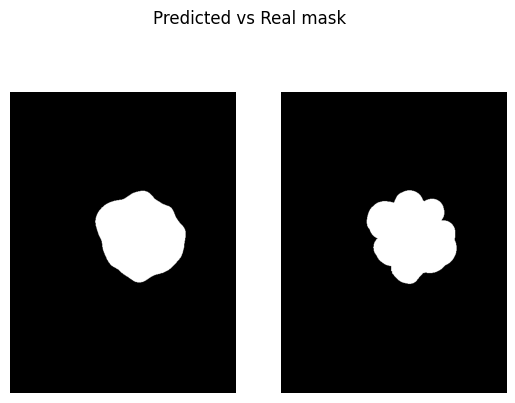

Epoch 60  train_loss=0.009740997881939014 train_iou=0.9476175804932913 val_loss=0.01985521987080574 val_iou=0.9180191953976949


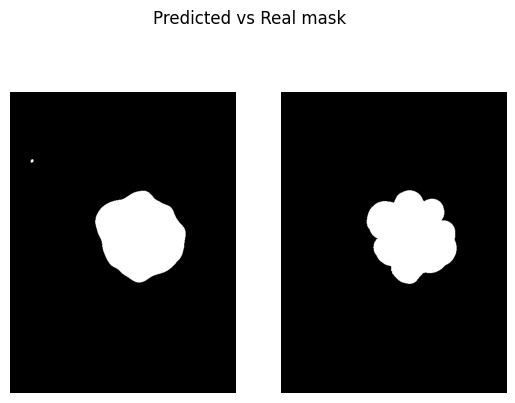

Epoch 61  train_loss=0.009378863809009394 train_iou=0.9494005342324575 val_loss=0.019553979858756065 val_iou=0.9195619424184164


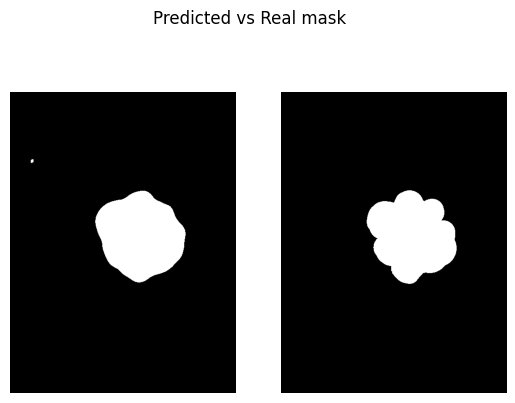

Epoch 62  train_loss=0.009058321282888452 train_iou=0.9508912364641825 val_loss=0.01899315354724725 val_iou=0.9216168920199076


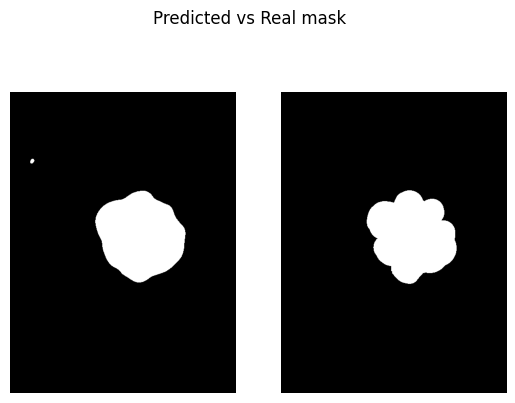

Epoch 63  train_loss=0.008681836382796368 train_iou=0.9527177512645721 val_loss=0.018983203296860058 val_iou=0.9236652255058289


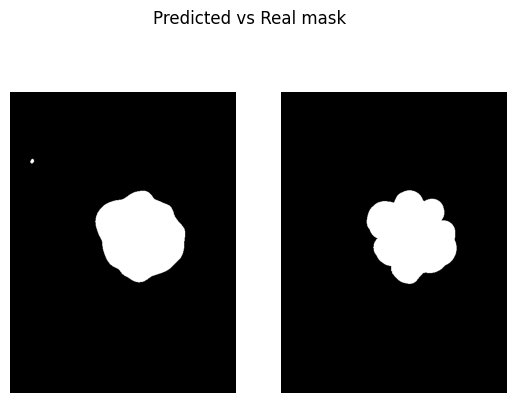

Epoch 64  train_loss=0.008546845987439156 train_iou=0.9529121617476145 val_loss=0.01764669455587864 val_iou=0.9276413321495056


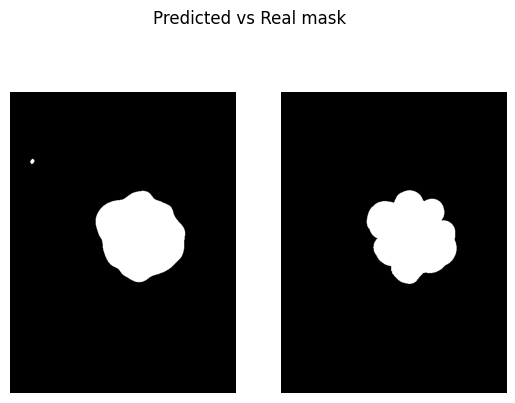

Epoch 65  train_loss=0.008413599183162054 train_iou=0.9547297954559326 val_loss=0.01877986453473568 val_iou=0.9232976039250692


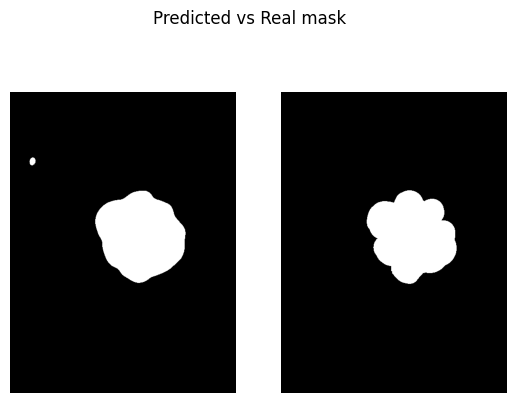

Epoch 66  train_loss=0.007759094781552752 train_iou=0.9584907690684 val_loss=0.019926085447271664 val_iou=0.9233648379643759


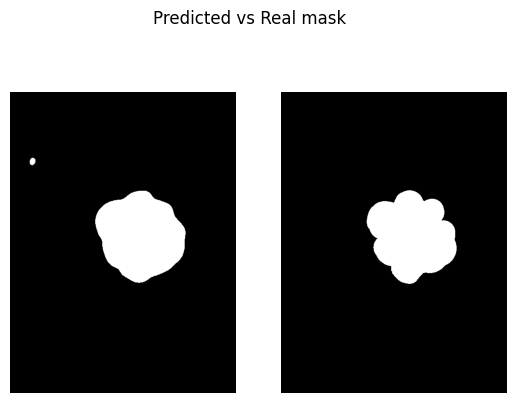

Epoch 67  train_loss=0.007571574843799074 train_iou=0.9591446419556936 val_loss=0.017915730675061543 val_iou=0.9301234483718872


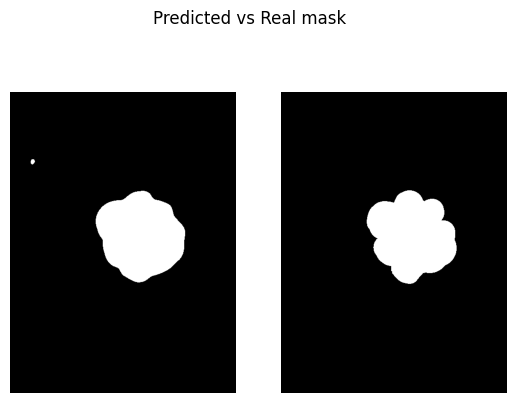

Epoch 68  train_loss=0.007985823399697741 train_iou=0.9554893175760905 val_loss=0.01725689508020878 val_iou=0.9323933521906534


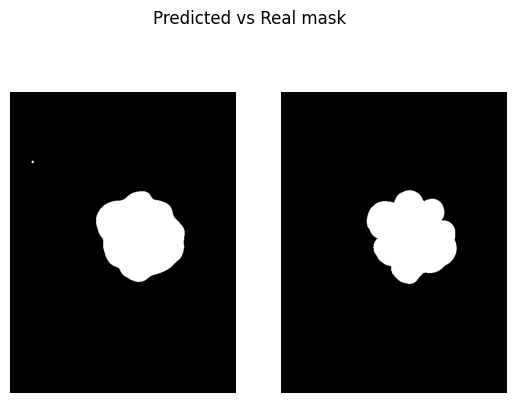

Epoch 69  train_loss=0.008198887885858616 train_iou=0.958199123541514 val_loss=0.019792304063836735 val_iou=0.9209474523862203


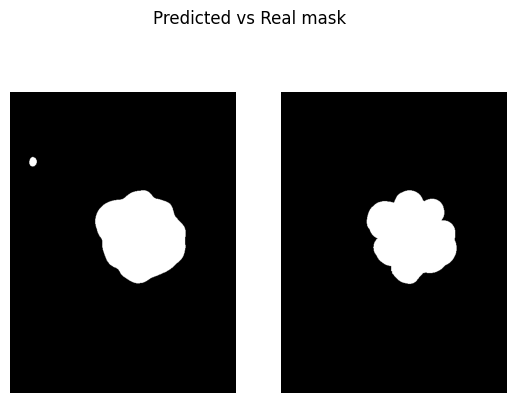

Epoch 70  train_loss=0.007161872461438179 train_iou=0.9601041277249655 val_loss=0.019959083447853725 val_iou=0.9281429449717203


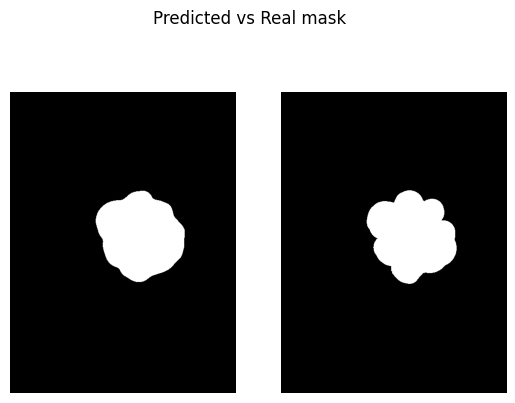

Epoch 71  train_loss=0.007232430623844266 train_iou=0.9617967406908671 val_loss=0.0187796192864577 val_iou=0.9244344830513


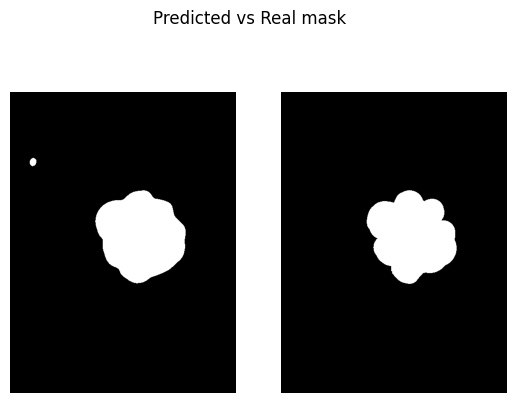

Epoch 72  train_loss=0.00643493498985966 train_iou=0.96522389849027 val_loss=0.019430667782823246 val_iou=0.9326153794924418


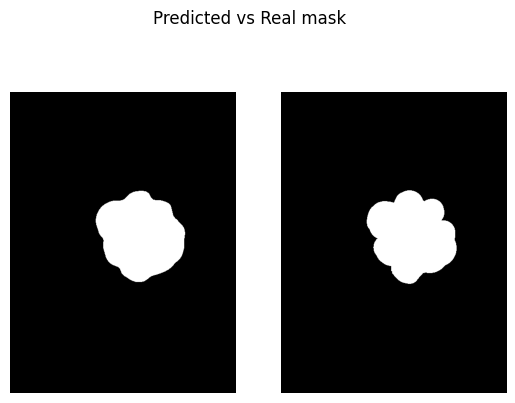

Epoch 73  train_loss=0.006813303412248691 train_iou=0.9628187616666158 val_loss=0.018095246826608975 val_iou=0.9293798009554545


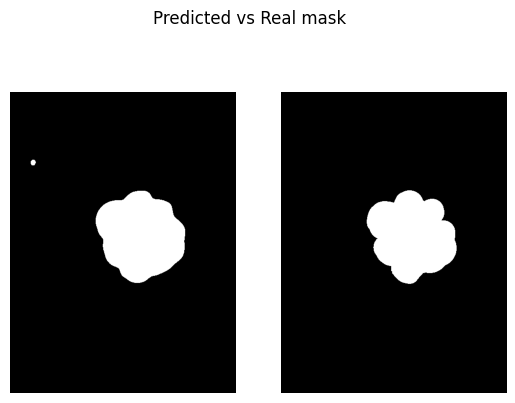

Epoch 74  train_loss=0.00713095076692601 train_iou=0.9634120762348175 val_loss=0.022004274030526478 val_iou=0.9211004972457886


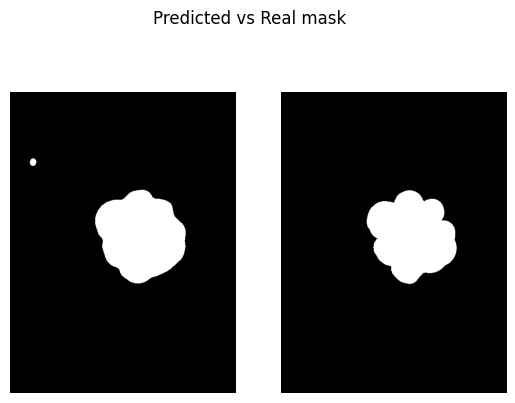

Epoch 75  train_loss=0.006309750101839502 train_iou=0.9645225008328756 val_loss=0.018560960267980892 val_iou=0.9339332183202108


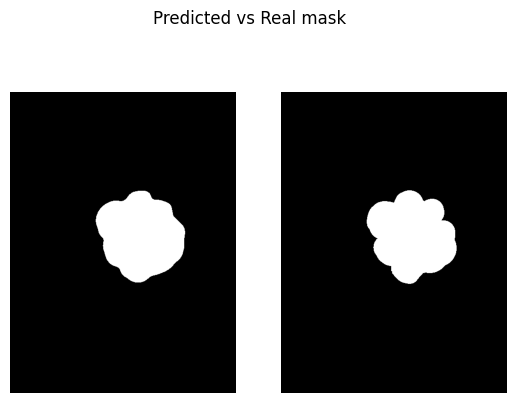

Epoch 76  train_loss=0.006259706181784471 train_iou=0.966575433810552 val_loss=0.01966710885365804 val_iou=0.9264139930407206


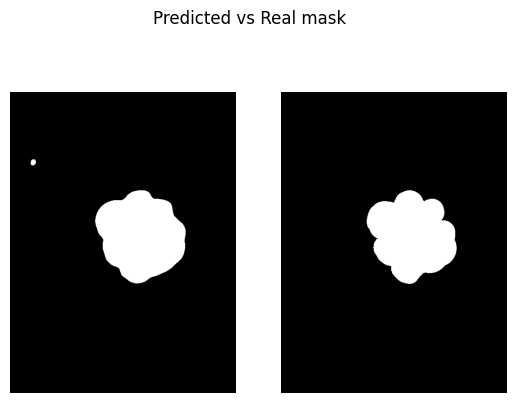

Epoch 77  train_loss=0.005739536446829637 train_iou=0.9691792925198873 val_loss=0.01946563522020976 val_iou=0.9337644974390665


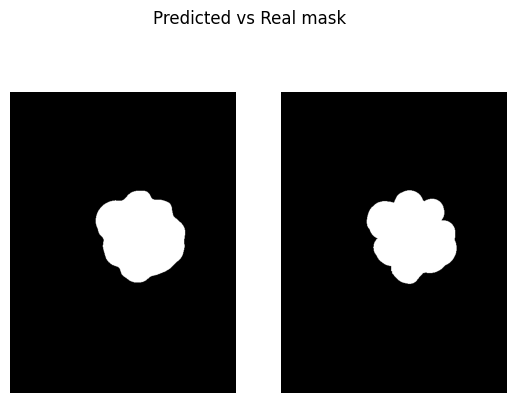

Epoch 78  train_loss=0.005856238926450412 train_iou=0.9677564998467764 val_loss=0.01846907598276933 val_iou=0.9340304533640543


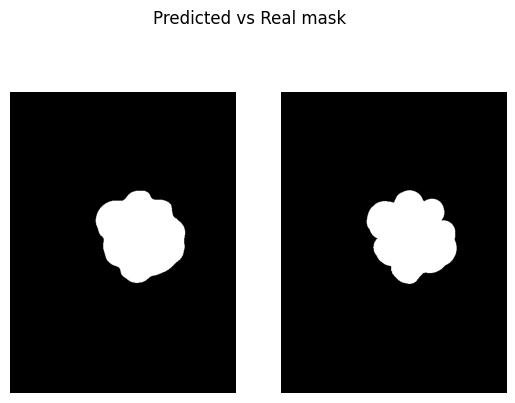

Epoch 79  train_loss=0.006335335007558267 train_iou=0.9662596782048544 val_loss=0.020959598943591118 val_iou=0.9234895706176758


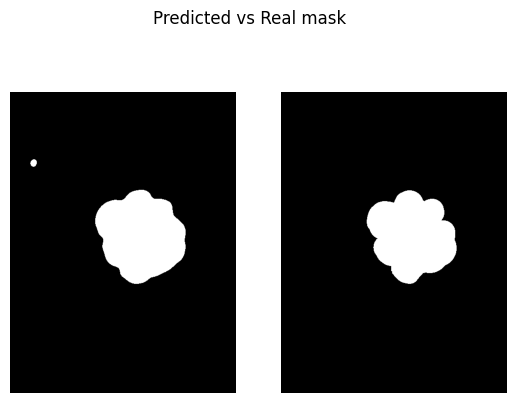

Epoch 80  train_loss=0.00656298912751178 train_iou=0.965500682592392 val_loss=0.017919748400648434 val_iou=0.9368893702824911


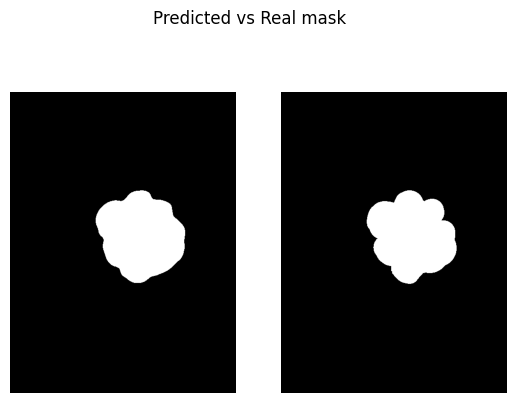

Epoch 81  train_loss=0.006121248084430893 train_iou=0.9662870268026987 val_loss=0.02020781673491001 val_iou=0.9275062878926595


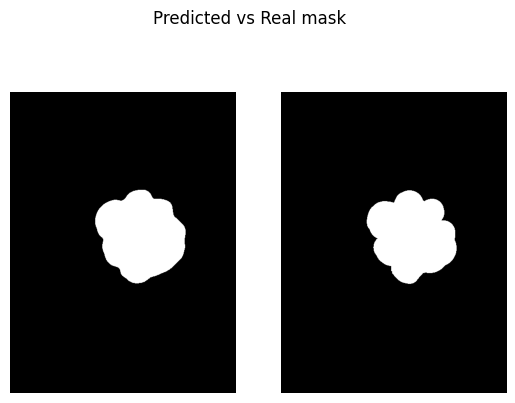

Epoch 82  train_loss=0.005653529815996687 train_iou=0.9684378107388815 val_loss=0.018090955913066864 val_iou=0.9375324447949728


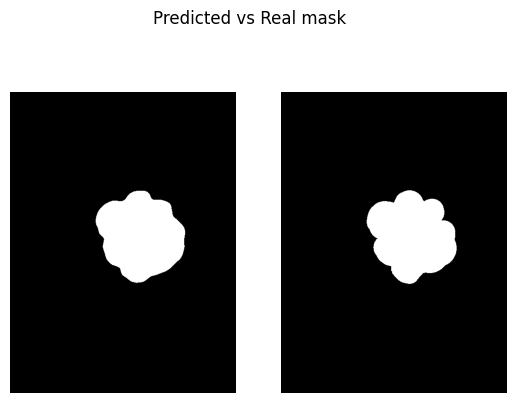

Epoch 83  train_loss=0.005659577514355381 train_iou=0.9695477386315664 val_loss=0.01976732537150383 val_iou=0.9291780988375345


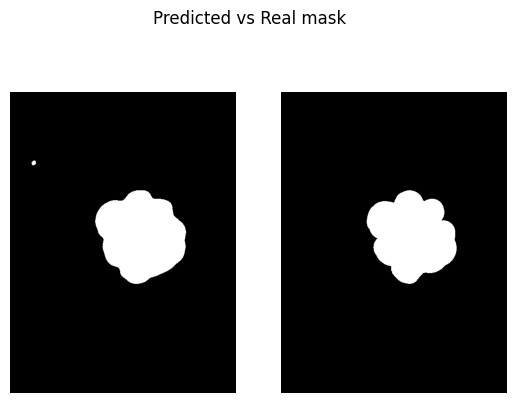

Epoch 84  train_loss=0.005246117478236556 train_iou=0.9713775316874186 val_loss=0.020459520320097607 val_iou=0.9352757732073466


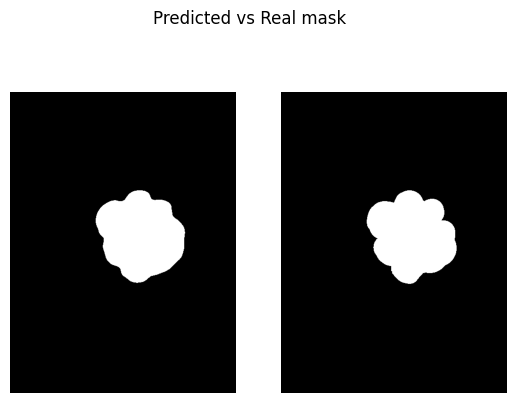

Epoch 85  train_loss=0.005544502132882674 train_iou=0.9697498977184296 val_loss=0.018643895164132118 val_iou=0.931603213151296


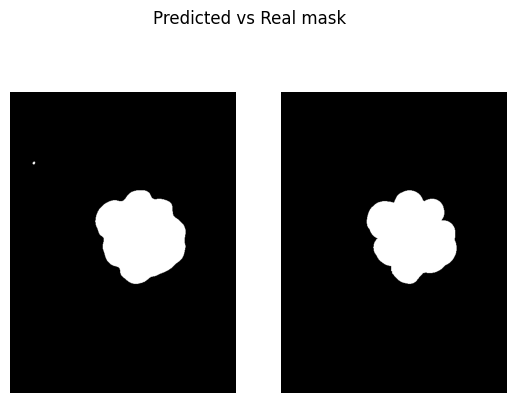

Epoch 86  train_loss=0.006006787143026789 train_iou=0.9683985908826193 val_loss=0.01796645609041055 val_iou=0.9366619189580282


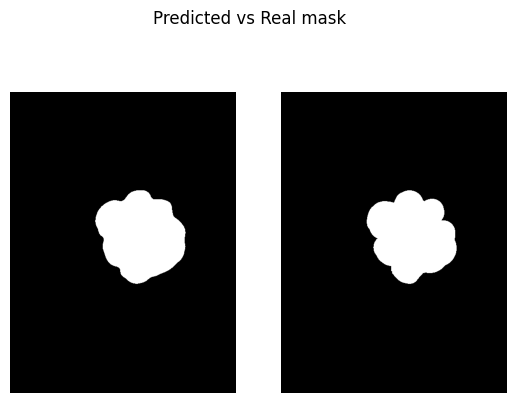

Epoch 87  train_loss=0.0051146853948011994 train_iou=0.9713548521200815 val_loss=0.01938873591522376 val_iou=0.9344650506973267


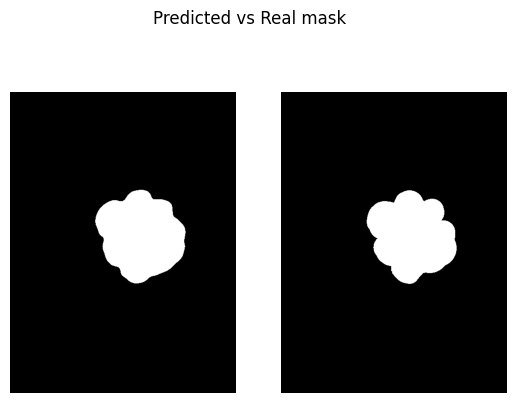

Epoch 88  train_loss=0.005103441188111901 train_iou=0.9718602200349172 val_loss=0.01843199133872986 val_iou=0.9383070667584738


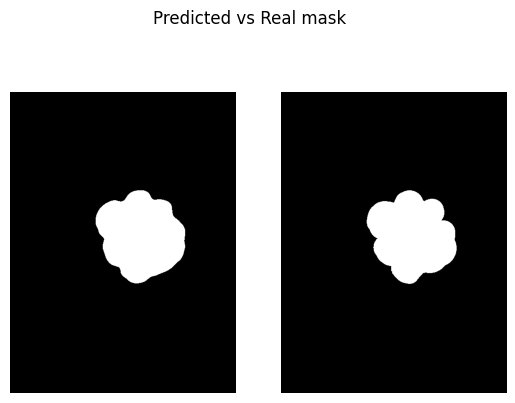

Epoch 89  train_loss=0.004851848119869828 train_iou=0.9731884996096293 val_loss=0.018844202160835266 val_iou=0.9345928827921549


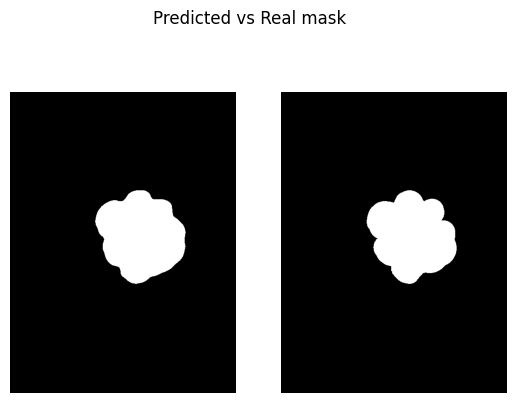

Epoch 90  train_loss=0.004892890729630987 train_iou=0.9733223915100098 val_loss=0.02014947682619095 val_iou=0.9335394303003947


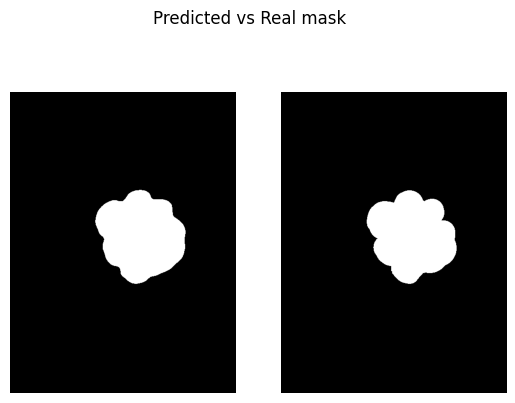

Epoch 91  train_loss=0.004624657876168688 train_iou=0.9744772513707479 val_loss=0.019632839908202488 val_iou=0.9365446964899699


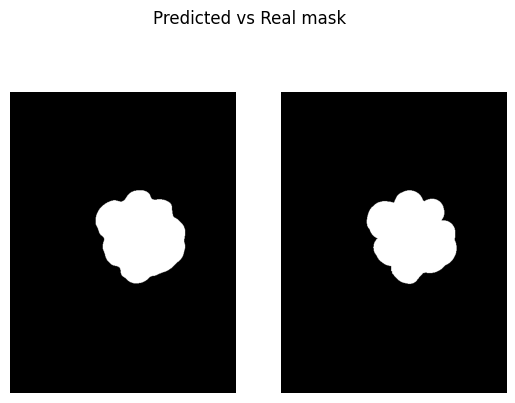

Epoch 92  train_loss=0.004612868884578347 train_iou=0.9748322566350301 val_loss=0.019554462283849716 val_iou=0.933916966120402


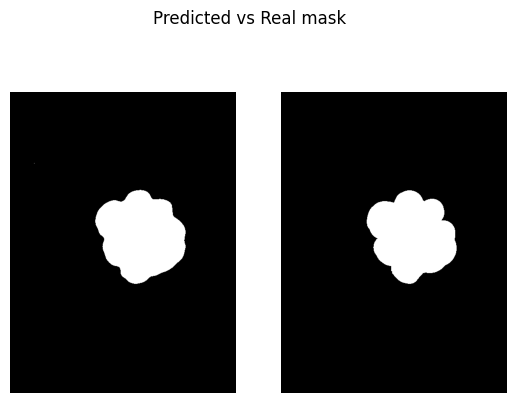

Epoch 93  train_loss=0.004989097050080697 train_iou=0.9730834662914276 val_loss=0.021769705538948376 val_iou=0.92935178677241


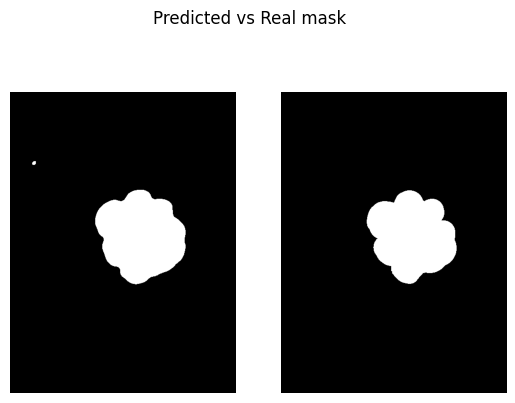

Epoch 94  train_loss=0.005025817275357743 train_iou=0.9729454219341278 val_loss=0.020389147723714512 val_iou=0.9324273467063904


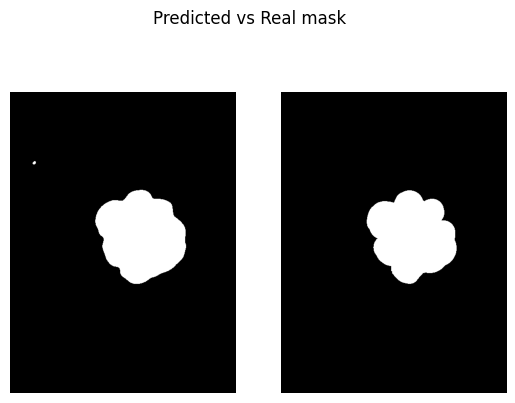

Epoch 95  train_loss=0.005418767221271992 train_iou=0.969765305519104 val_loss=0.019232129057248432 val_iou=0.9317556619644165


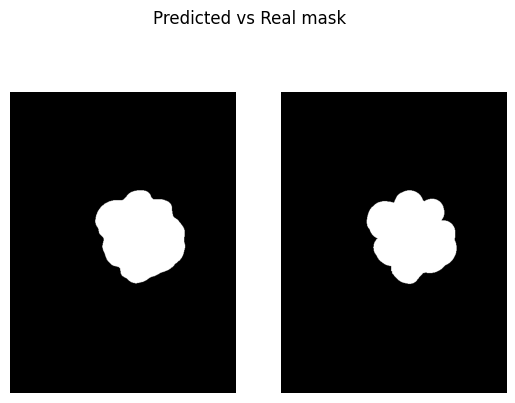

Epoch 96  train_loss=0.005433193252732356 train_iou=0.9705664118131002 val_loss=0.016021136815349262 val_iou=0.9420771598815918


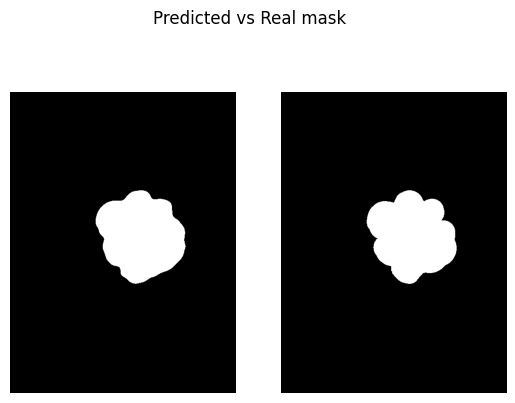

Epoch 97  train_loss=0.004919929895550013 train_iou=0.9731754859288534 val_loss=0.01874958723783493 val_iou=0.9399211605389913


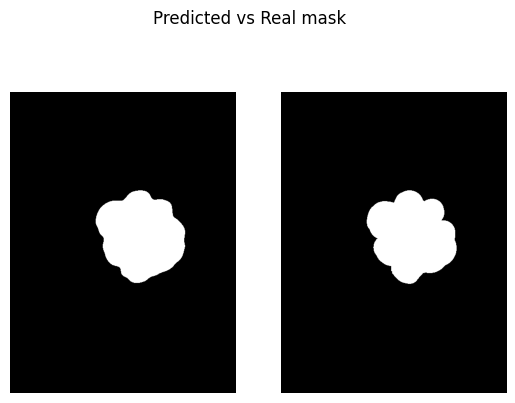

Epoch 98  train_loss=0.004835948464460671 train_iou=0.9739963114261627 val_loss=0.01846833589176337 val_iou=0.9401845534642538


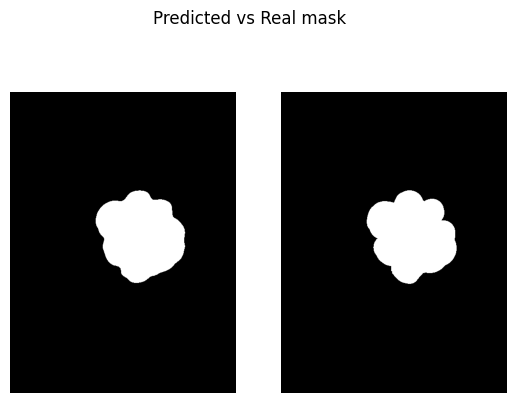

Epoch 99  train_loss=0.004913198451201121 train_iou=0.9736301004886627 val_loss=0.017242999747395515 val_iou=0.9384374022483826


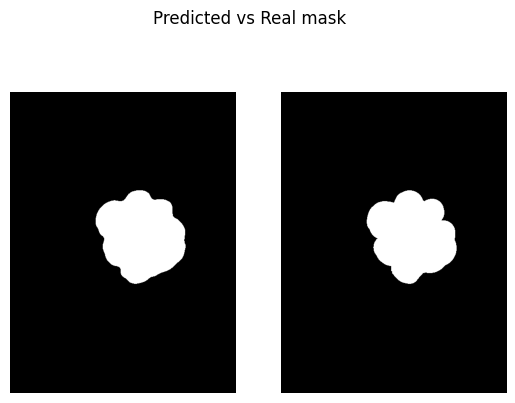

Epoch 100  train_loss=0.005022903826708595 train_iou=0.9730981985727946 val_loss=0.019778142993648846 val_iou=0.9341782927513123


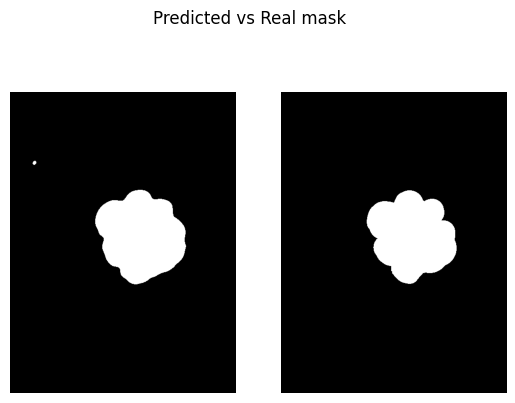

Epoch 101  train_loss=0.004538254346698523 train_iou=0.9745263655980428 val_loss=0.019589828327298164 val_iou=0.9385459423065186


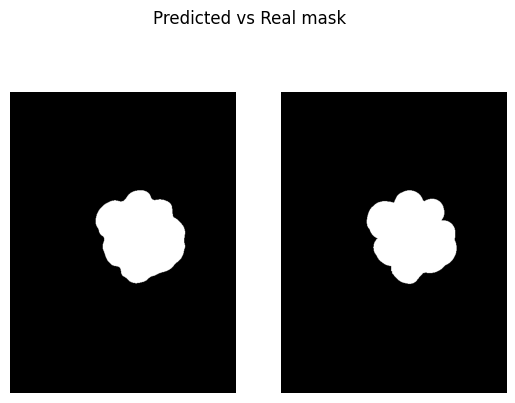

Epoch 102  train_loss=0.004655087521920602 train_iou=0.9746198753515879 val_loss=0.01800379840036233 val_iou=0.9392674366633097


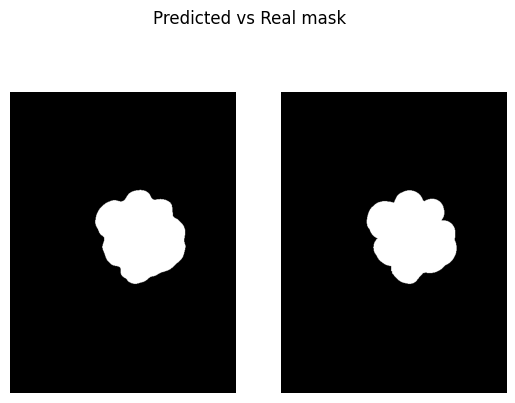

Epoch 103  train_loss=0.004893909363696973 train_iou=0.9737984240055084 val_loss=0.019907596831520397 val_iou=0.9343332846959432


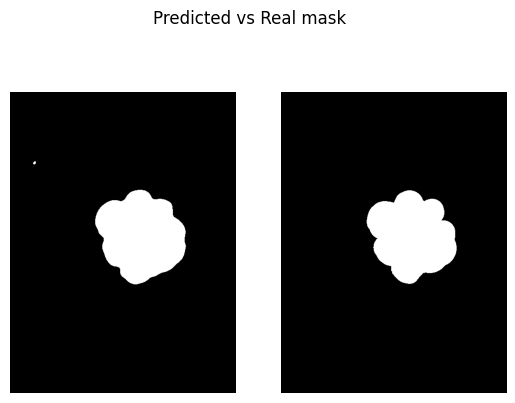

Epoch 104  train_loss=0.004393724724650383 train_iou=0.9750282267729441 val_loss=0.019593401501576107 val_iou=0.9374250372250875


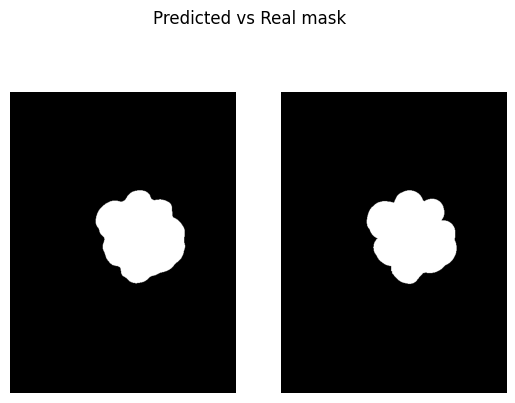

Epoch 105  train_loss=0.004720820696093142 train_iou=0.9742672443389893 val_loss=0.017423033714294434 val_iou=0.9411806066830953


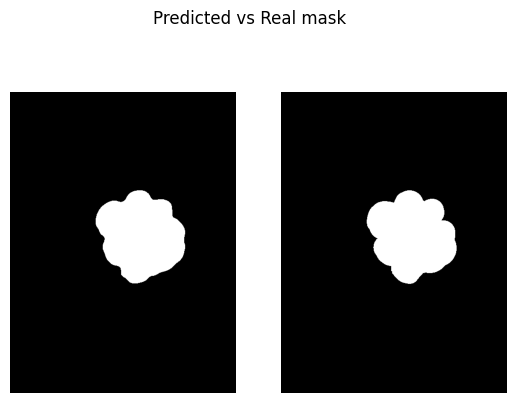

Epoch 106  train_loss=0.005021822250758608 train_iou=0.9735060731569926 val_loss=0.02102234773337841 val_iou=0.9335867365201315


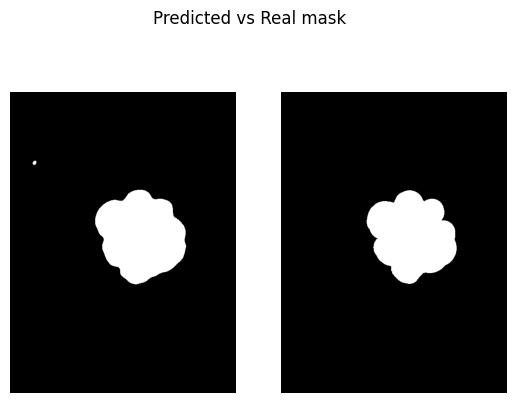

Epoch 107  train_loss=0.0044882998724157614 train_iou=0.9741315245628357 val_loss=0.021000149970253307 val_iou=0.9331795374552408


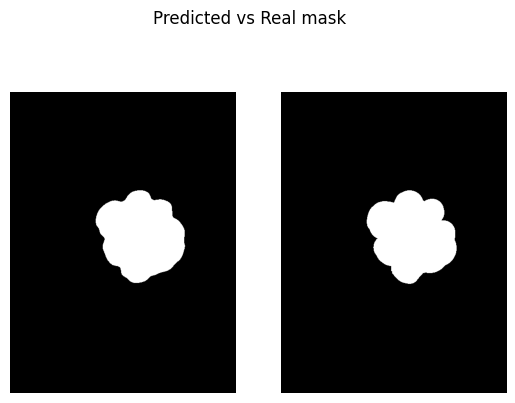

Epoch 108  train_loss=0.004680418564627568 train_iou=0.9750068485736847 val_loss=0.02020947386821111 val_iou=0.9333979288736979


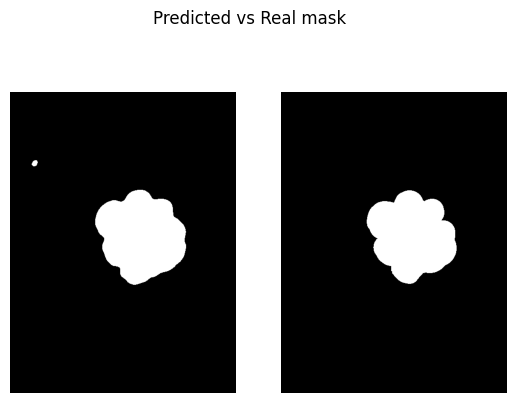

Epoch 109  train_loss=0.004814717375362913 train_iou=0.9735108415285746 val_loss=0.021578724185625713 val_iou=0.9338396390279134


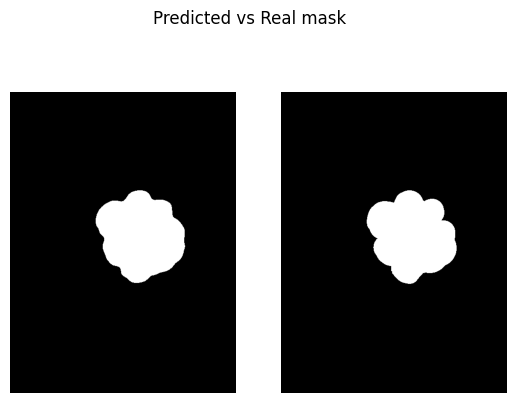

Epoch 110  train_loss=0.004843092407099903 train_iou=0.9730822543303171 val_loss=0.01857050135731697 val_iou=0.9363875190416971


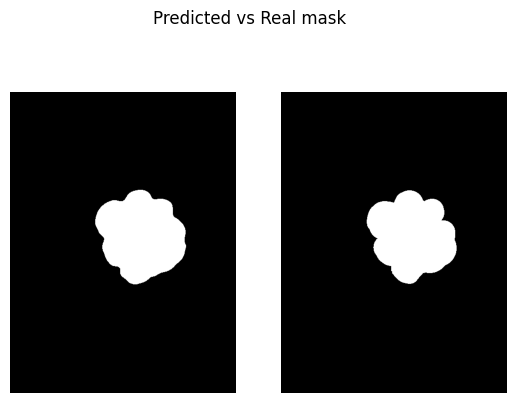

Epoch 111  train_loss=0.004568829317577183 train_iou=0.9741338392098745 val_loss=0.017720336094498634 val_iou=0.9410516421000162


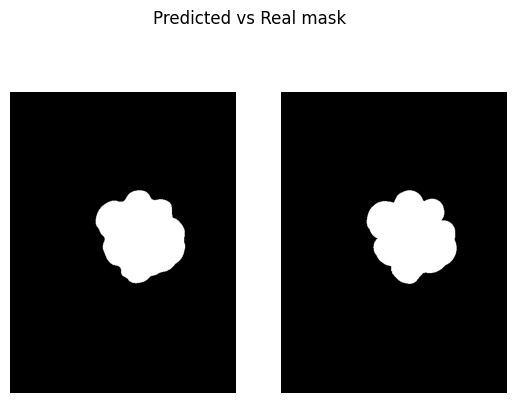

Epoch 112  train_loss=0.0044282732997089624 train_iou=0.9760522445042928 val_loss=0.018668927252292633 val_iou=0.938236673672994


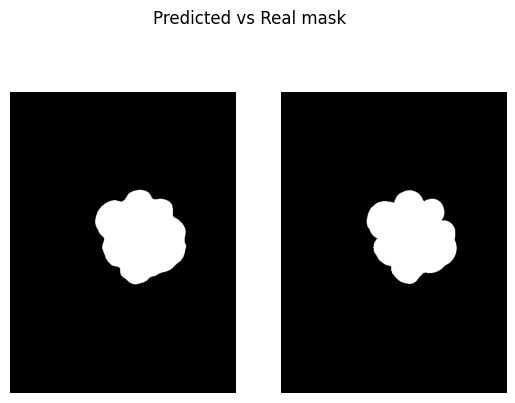

Epoch 113  train_loss=0.0041200606695686775 train_iou=0.9764978289604187 val_loss=0.022507375727097195 val_iou=0.9331059257189432


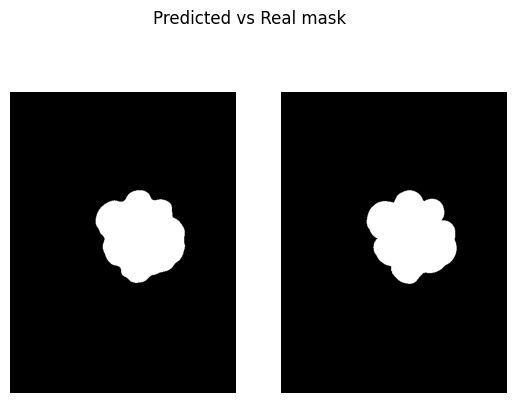

Epoch 114  train_loss=0.0044718382802481456 train_iou=0.9760266145070394 val_loss=0.019220698003967602 val_iou=0.9364225467046102


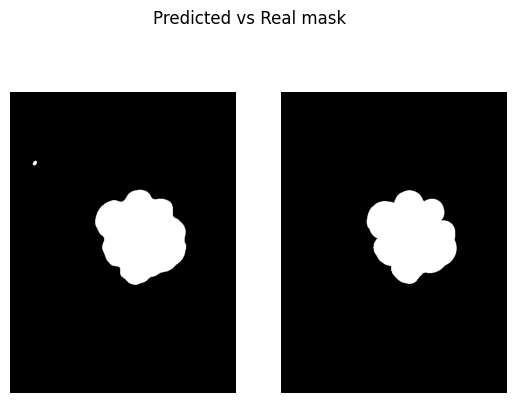

Epoch 115  train_loss=0.004467663432781895 train_iou=0.974908192952474 val_loss=0.020766281833251316 val_iou=0.935715893904368


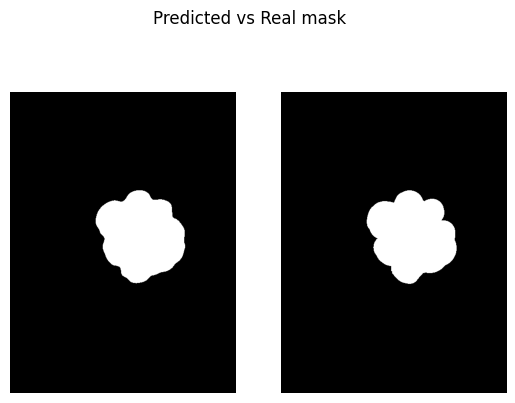

Epoch 116  train_loss=0.004350881131055455 train_iou=0.976020872592926 val_loss=0.01916476401189963 val_iou=0.9374468723932902


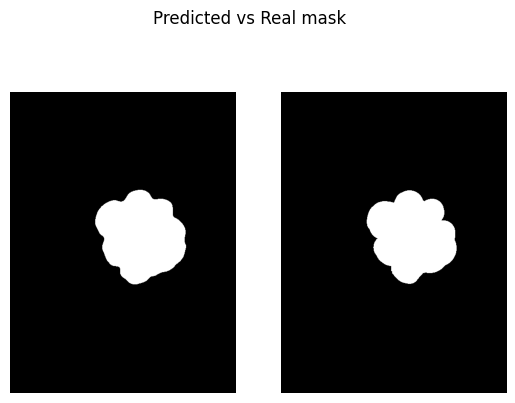

Epoch 117  train_loss=0.004207157219449679 train_iou=0.9760933121045431 val_loss=0.02042350359261036 val_iou=0.936308741569519


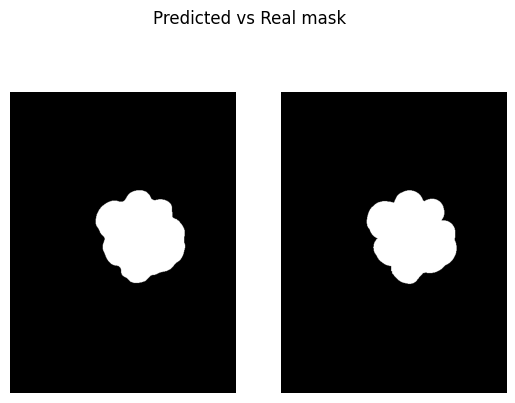

Epoch 118  train_loss=0.004194470976168911 train_iou=0.9771750171979269 val_loss=0.019155194362004597 val_iou=0.9390783707300822


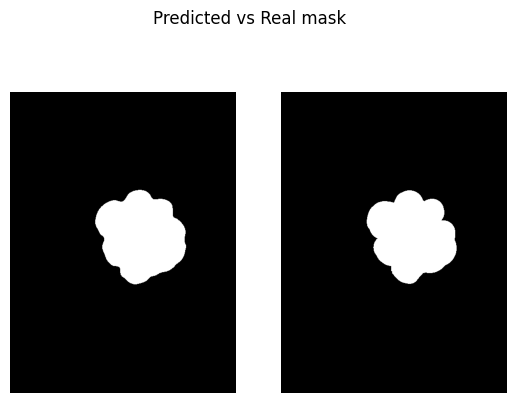

Epoch 119  train_loss=0.0039875096796701355 train_iou=0.9773633480072021 val_loss=0.021110941345493 val_iou=0.9361857573191324


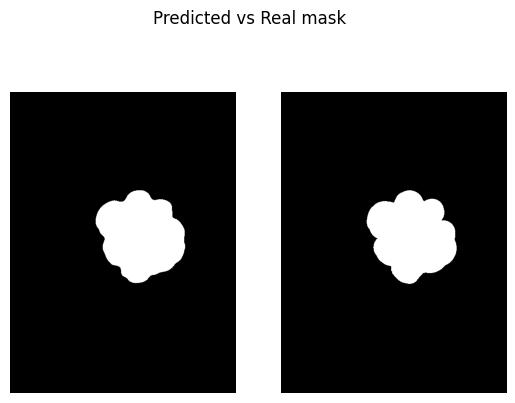

Epoch 120  train_loss=0.004037471643338601 train_iou=0.9779620965321859 val_loss=0.019762234141429264 val_iou=0.9387419819831848


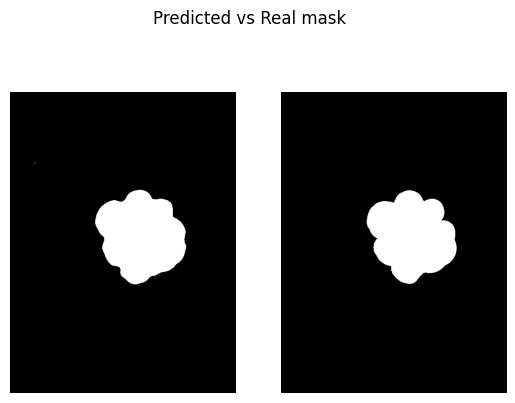

Epoch 121  train_loss=0.004115913373728593 train_iou=0.9769619802633921 val_loss=0.02114976632098357 val_iou=0.9373633861541748


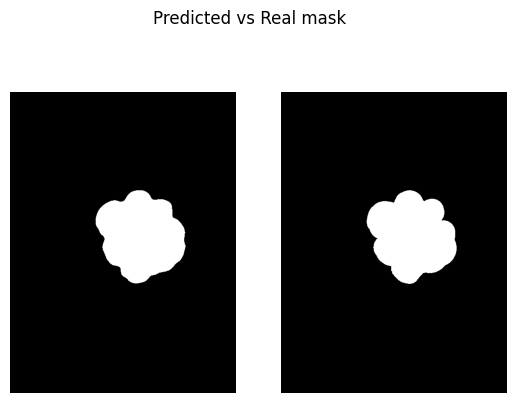

Epoch 122  train_loss=0.003909045131877065 train_iou=0.9778975546360016 val_loss=0.01958356921871503 val_iou=0.940055251121521


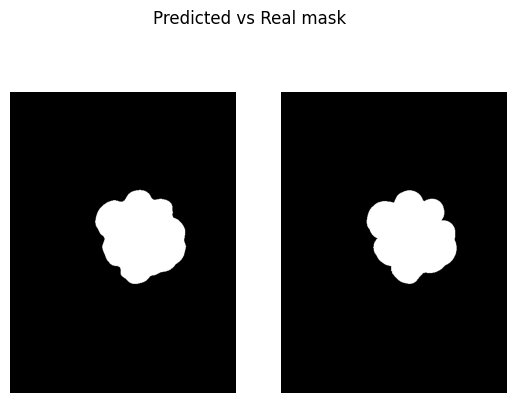

Epoch 123  train_loss=0.004143757939649125 train_iou=0.9772342244784037 val_loss=0.019921197866400082 val_iou=0.9414412379264832


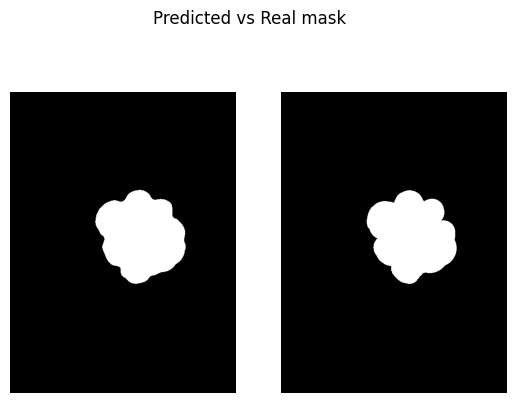

Epoch 124  train_loss=0.0037246783807252846 train_iou=0.9785143534342448 val_loss=0.02081806833545367 val_iou=0.9366990327835083


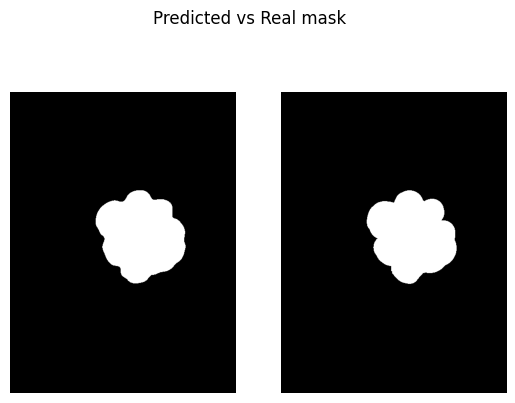

Epoch 125  train_loss=0.003926862419272463 train_iou=0.9784766932328542 val_loss=0.020090750108162563 val_iou=0.9411254127820333


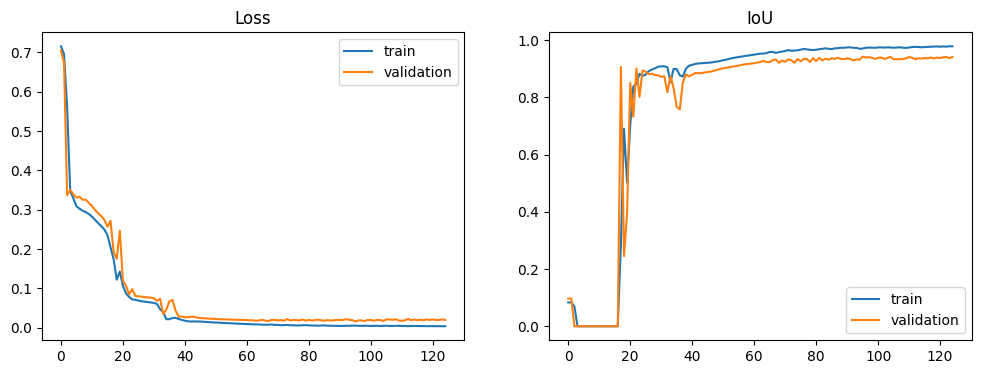

In [ ]:
# Hyperparameters
BATCH_SIZE = 2
LR = 0.0001
N_INPUT_CHANNELS = 1
N_CLASSES = 1
THRESHOLD = 0.3
EPOCHS = 125

# Model
unet = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet.to(device)

# Loss function
bce_loss = nn.BCEWithLogitsLoss()

# Optimizer
adam_optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

train_model(unet, train_dataset, valid_dataset, device, adam_optimizer, bce_loss, BATCH_SIZE, EPOCHS, THRESHOLD, 'trained-unet.pt')

### Step 4: Validate the results

After training we can check the results in the dataset.

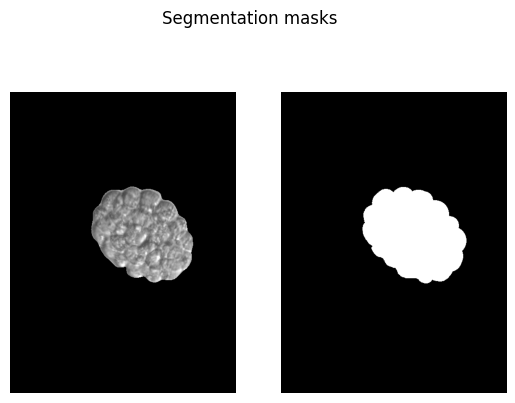

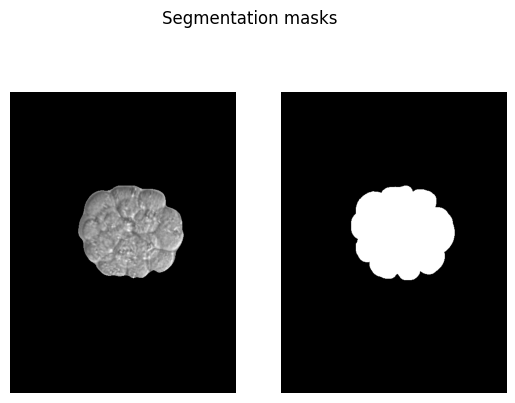

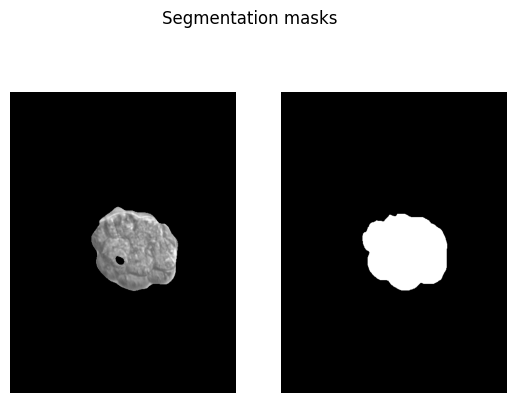

In [ ]:
def check_segmentation_results(model, dataset, threshold=0.5):
    model.eval()
    for image, mask in dataset:
        image = image[None, :,:,:]
        image = image.to(device)
        mask = mask.to(device)
        output = model(image)
        predicted_mask = get_segmentation_masks(output, threshold)
        show(image.cpu().squeeze()*predicted_mask.cpu().squeeze(), mask.cpu().squeeze(), title="Segmentation masks")

    
unet = torch.load('trained-unet.pt', map_location=device)

check_segmentation_results(unet, valid_dataset, 0.3)

#### Exercise
Modify the function `check_segmentation_results` to include the IoU metric.

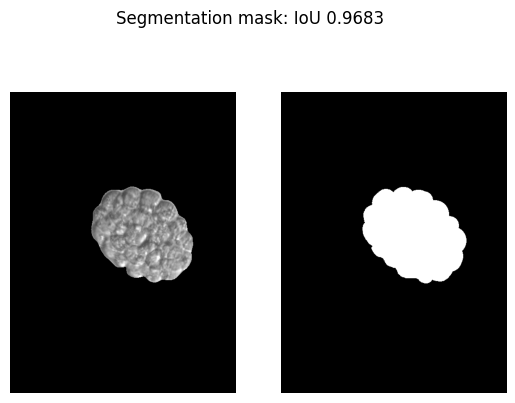

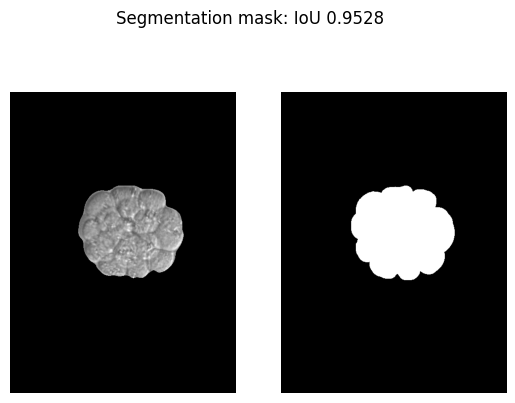

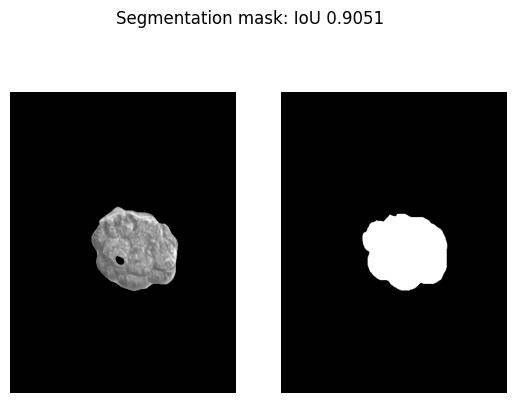

In [ ]:
def check_segmentation_results_with_acc(model, dataset, threshold=0.3):
    model.eval()
    for image, mask in dataset:
        image = image[None, :,:,:]
        image = image.to(device)
        mask = mask.to(device)
        output = model(image)
        predicted_mask = get_segmentation_masks(output, threshold)
        # Write your code here
        iou = compute_iou(predicted_mask,mask).item()
        show(image.cpu().squeeze()*predicted_mask.cpu().squeeze(), mask.cpu().squeeze(), title=f"Segmentation mask: IoU {iou:.4f}")

    
unet = torch.load('trained-unet.pt', map_location=device)

check_segmentation_results_with_acc(unet, valid_dataset, 0.3)

### Exercise

Define a set of suitable transforms, train the UNet with data augmentation and check the results.

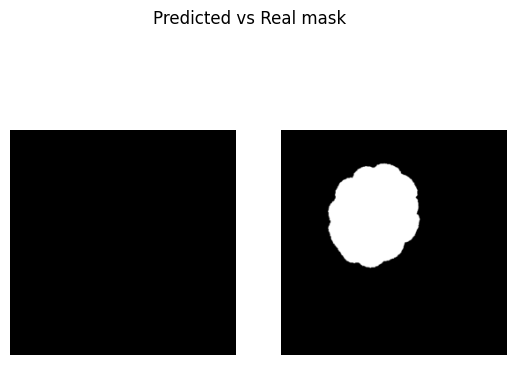

Epoch 1  train_loss=0.6690017978350321 train_iou=0.13396301493048668 val_loss=0.6645880937576294 val_iou=0.16108233233292898


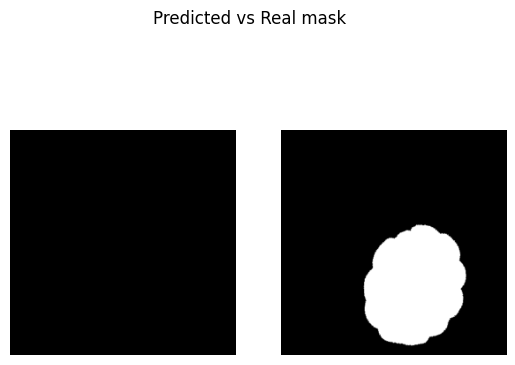

Epoch 2  train_loss=0.650363047917684 train_iou=0.12550062562028566 val_loss=0.6271355152130127 val_iou=0.1580578734477361


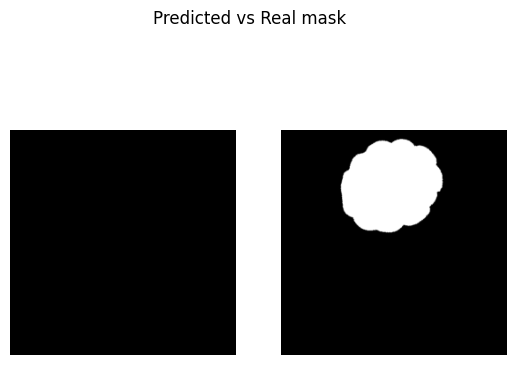

Epoch 3  train_loss=0.5156902521848679 train_iou=0.09793183455864589 val_loss=0.529473622639974 val_iou=0.0


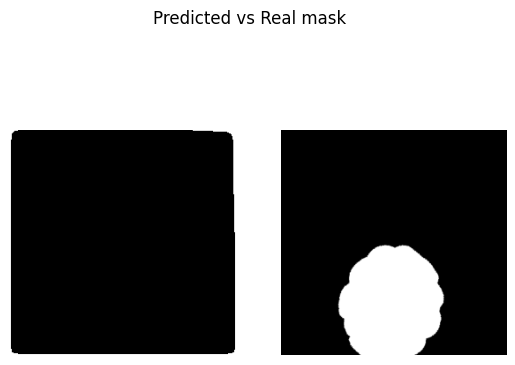

Epoch 4  train_loss=0.49018262326717377 train_iou=0.03625222526413078 val_loss=0.5072965621948242 val_iou=0.16377964119116464


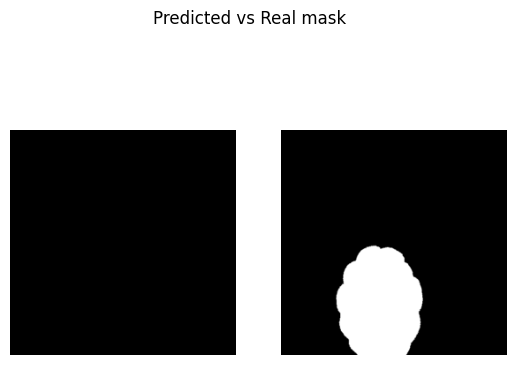

Epoch 5  train_loss=0.4372876435518265 train_iou=0.060362632075945534 val_loss=0.5172905921936035 val_iou=0.0


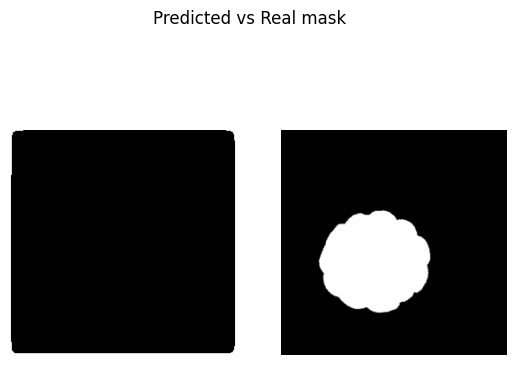

Epoch 6  train_loss=0.4453016022841136 train_iou=0.00045451960371186334 val_loss=0.44253456592559814 val_iou=0.0


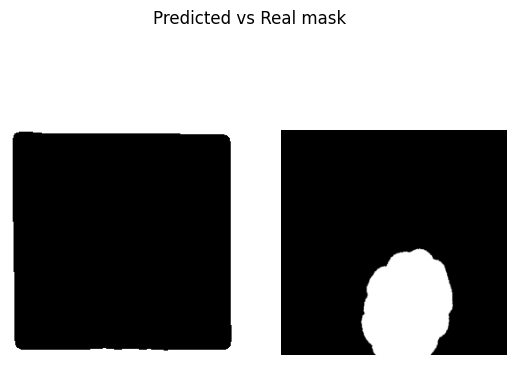

Epoch 7  train_loss=0.39952046672503155 train_iou=0.0025341035798192024 val_loss=0.41150741775830585 val_iou=0.0031583079447348914


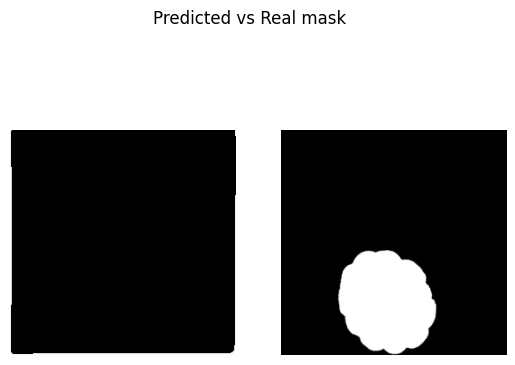

Epoch 8  train_loss=0.40888230005900067 train_iou=0.0006448055598108718 val_loss=0.38956014315287274 val_iou=0.0


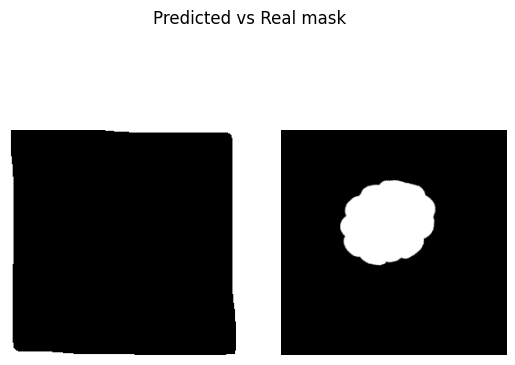

Epoch 9  train_loss=0.38337743282318115 train_iou=0.0015259332334001858 val_loss=0.3428589999675751 val_iou=0.0


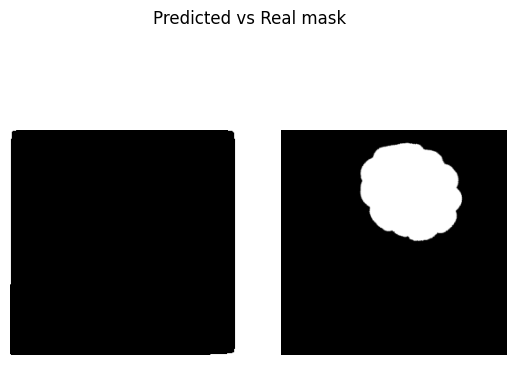

Epoch 10  train_loss=0.3978090037902196 train_iou=0.0007337757075826327 val_loss=0.39679022630055744 val_iou=0.0021397368982434273


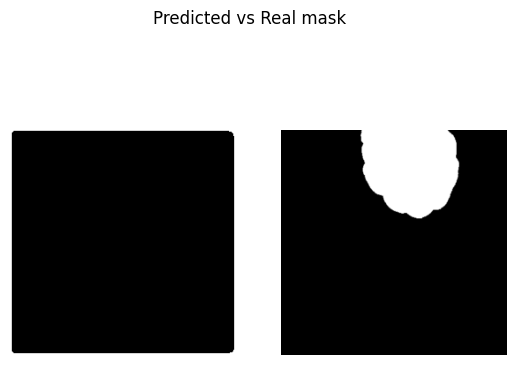

Epoch 11  train_loss=0.35218022267023724 train_iou=0.0015106241529186566 val_loss=0.3281796971956889 val_iou=0.0


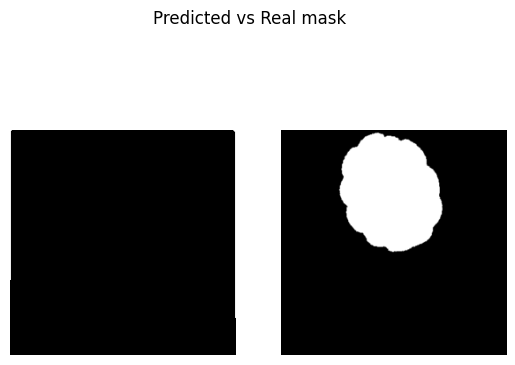

Epoch 12  train_loss=0.34974656999111176 train_iou=0.0 val_loss=0.3172834515571594 val_iou=0.0


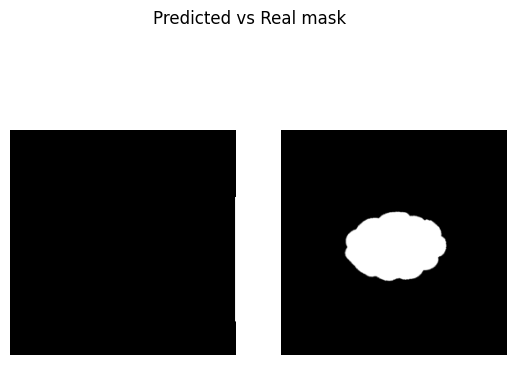

Epoch 13  train_loss=0.32382156948248547 train_iou=0.0 val_loss=0.3209268053372701 val_iou=0.0


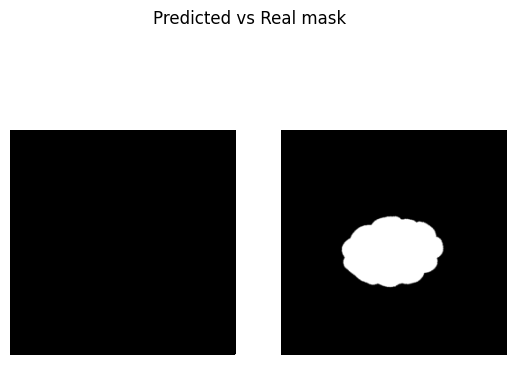

Epoch 14  train_loss=0.32040149966875714 train_iou=0.11503843420602304 val_loss=0.3026777406533559 val_iou=0.13098008930683136


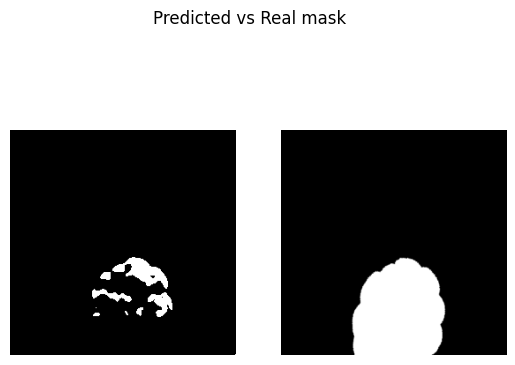

Epoch 15  train_loss=0.3360805958509445 train_iou=0.20871004462242126 val_loss=0.31976065039634705 val_iou=0.0


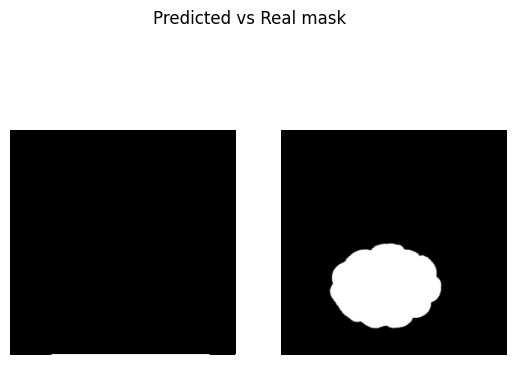

Epoch 16  train_loss=0.3126016954580943 train_iou=0.03320993979771932 val_loss=0.326163649559021 val_iou=0.2682667126258214


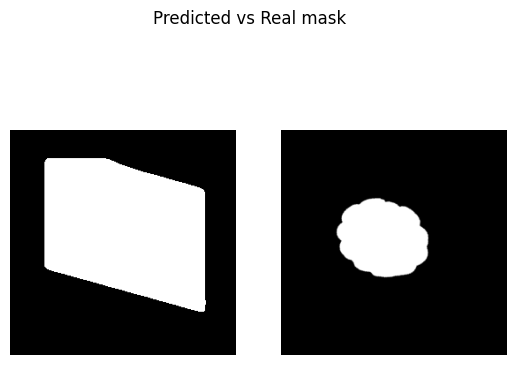

Epoch 17  train_loss=0.29617076615492505 train_iou=0.2320381005605062 val_loss=0.3014024992783864 val_iou=0.0


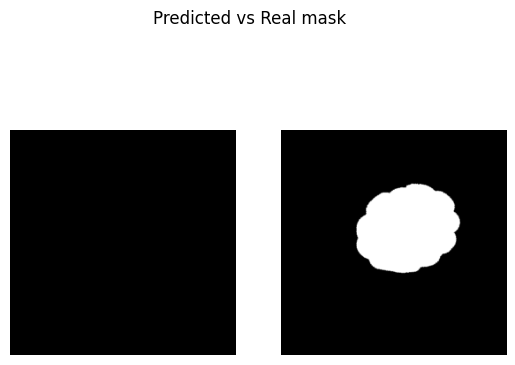

Epoch 18  train_loss=0.2775859286387761 train_iou=0.008554146159440279 val_loss=0.3757028977076213 val_iou=0.08826781064271927


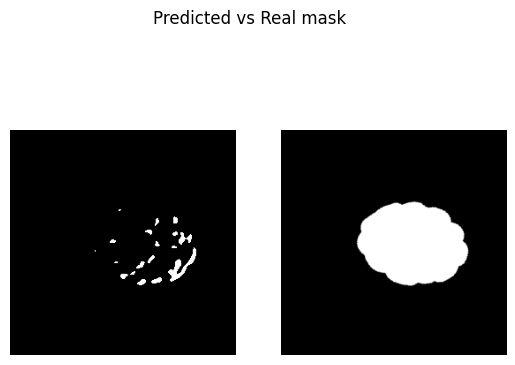

Epoch 19  train_loss=0.2718024402856827 train_iou=0.38612546895941097 val_loss=0.4857698281606038 val_iou=0.2986057798067729


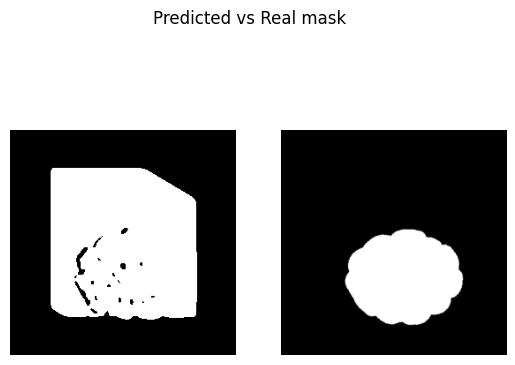

Epoch 20  train_loss=0.3130788902441661 train_iou=0.31986665229002637 val_loss=0.5918834010759989 val_iou=0.2609795480966568


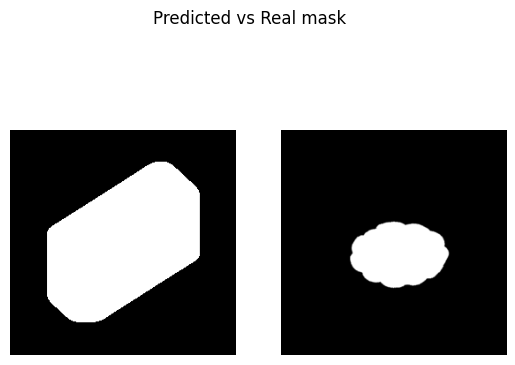

Epoch 21  train_loss=0.3154162069161733 train_iou=0.25570713728666306 val_loss=0.35825931032498676 val_iou=0.2848471850156784


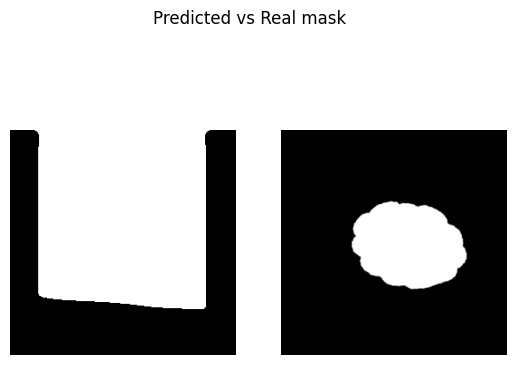

Epoch 22  train_loss=0.3395523130893707 train_iou=0.2419567952553431 val_loss=0.32835568984349567 val_iou=0.4517693718274434


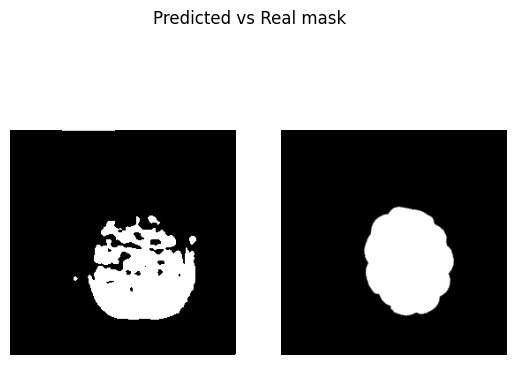

Epoch 23  train_loss=0.3195769687493642 train_iou=0.21233104448765516 val_loss=0.29962194959322613 val_iou=0.25534745554129284


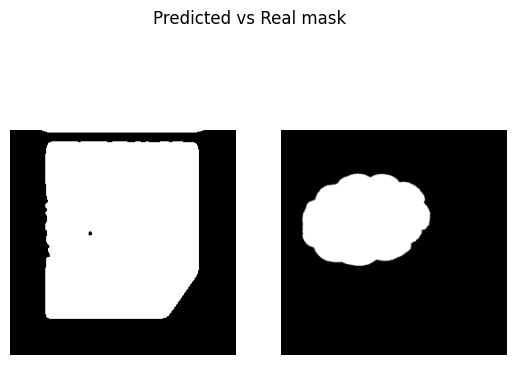

Epoch 24  train_loss=0.32691702246665955 train_iou=0.25176685800155 val_loss=0.2744169235229492 val_iou=0.2686052819093068


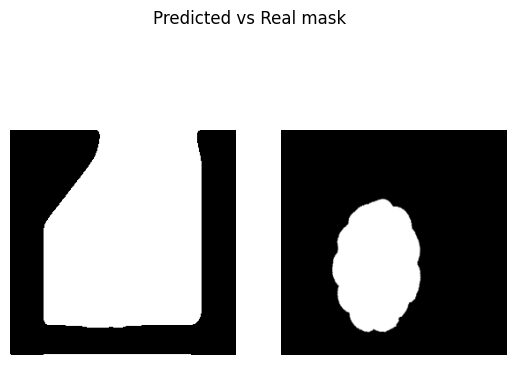

Epoch 25  train_loss=0.3219533860683441 train_iou=0.3033847361803055 val_loss=0.2846614271402359 val_iou=0.2743975619475047


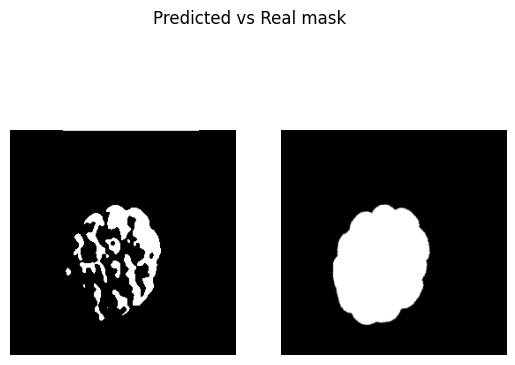

Epoch 26  train_loss=0.3152963767449061 train_iou=0.13369375835948935 val_loss=0.28782689571380615 val_iou=0.17844697336355844


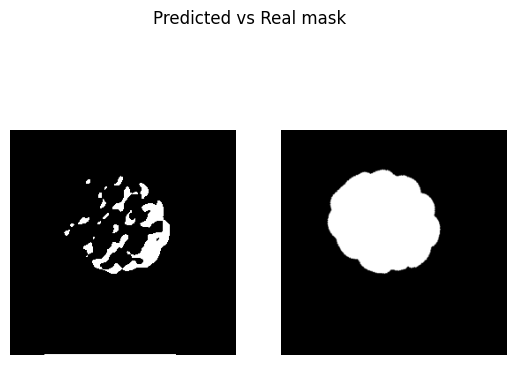

Epoch 27  train_loss=0.2977397044499715 train_iou=0.24147319296995798 val_loss=0.3154641290505727 val_iou=0.0


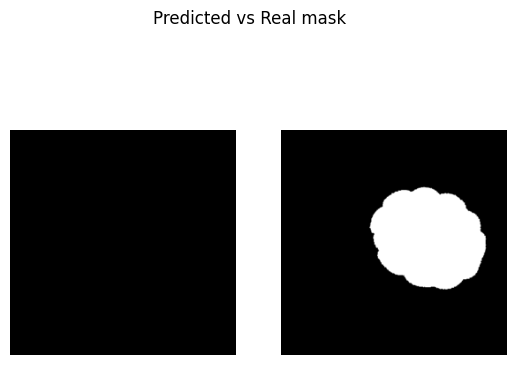

Epoch 28  train_loss=0.30939805259307224 train_iou=0.2873912254969279 val_loss=0.2913782795270284 val_iou=0.31836600104967755


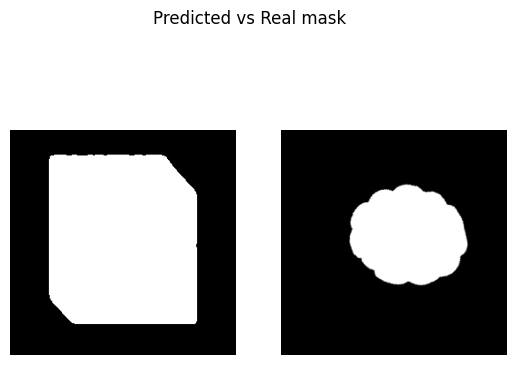

Epoch 29  train_loss=0.28906185428301495 train_iou=0.30117668956518173 val_loss=0.38244569301605225 val_iou=0.29418789347012836


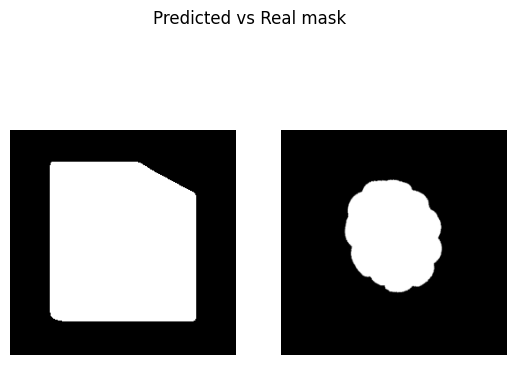

Epoch 30  train_loss=0.2774627134203911 train_iou=0.3261580988764763 val_loss=0.22136310239632925 val_iou=0.34722928206125897


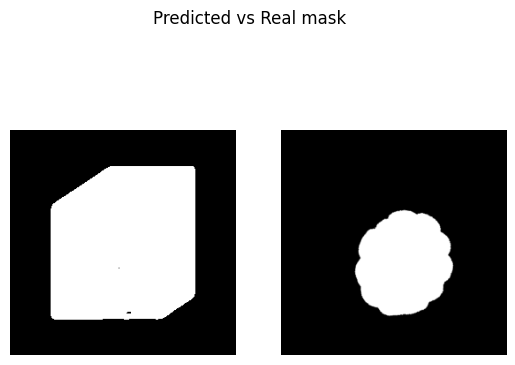

Epoch 31  train_loss=0.29100175698598224 train_iou=0.34214745958646137 val_loss=0.296369989713033 val_iou=0.3413272698720296


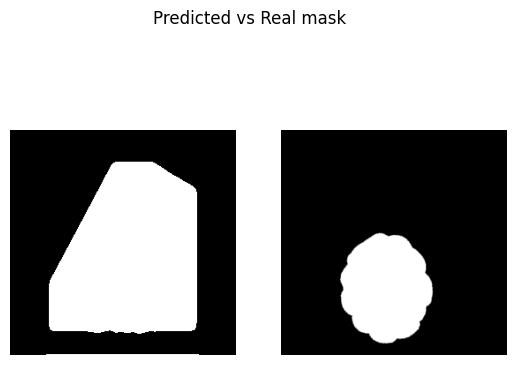

Epoch 32  train_loss=0.27655838429927826 train_iou=0.29143594205379486 val_loss=0.2815588315327962 val_iou=0.3320457736651103


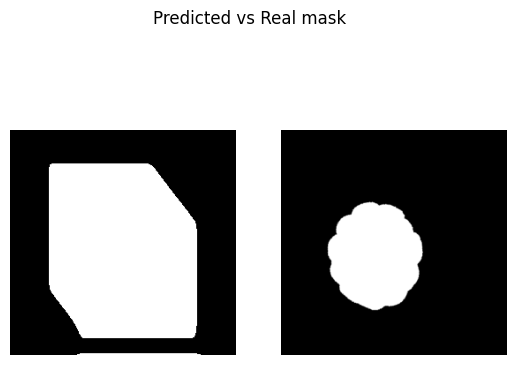

Epoch 33  train_loss=0.3229941378037135 train_iou=0.2830917884906133 val_loss=0.2870189348856608 val_iou=0.3231423000494639


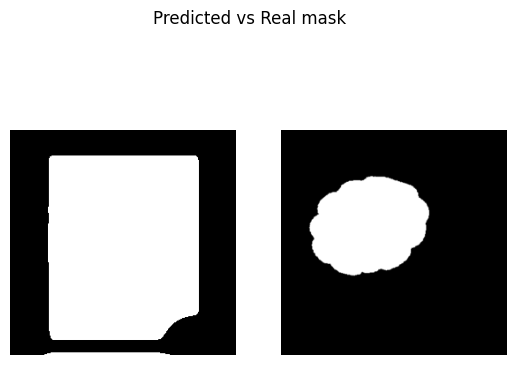

Epoch 34  train_loss=0.29330451786518097 train_iou=0.2821194877227147 val_loss=0.3012423316637675 val_iou=0.5200080076853434


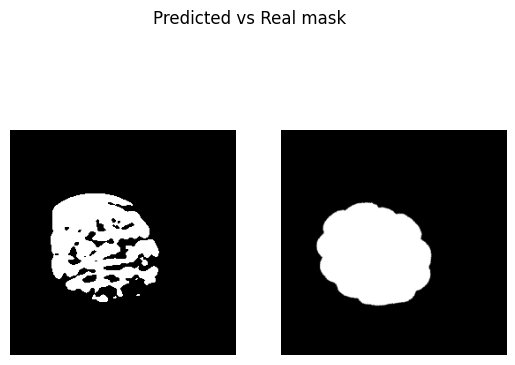

Epoch 35  train_loss=0.2860335210959117 train_iou=0.28623388565999147 val_loss=0.3253823022047679 val_iou=0.32756837209065753


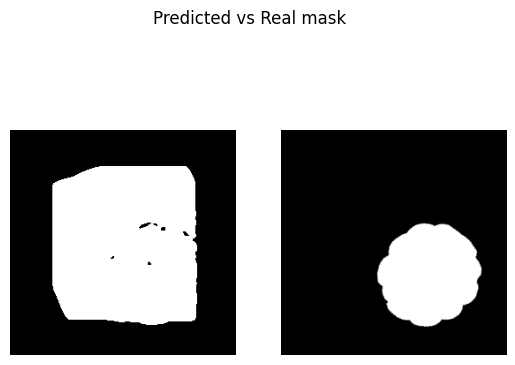

Epoch 36  train_loss=0.2543073172370593 train_iou=0.32135604321956635 val_loss=0.29385535915692645 val_iou=0.3469896614551544


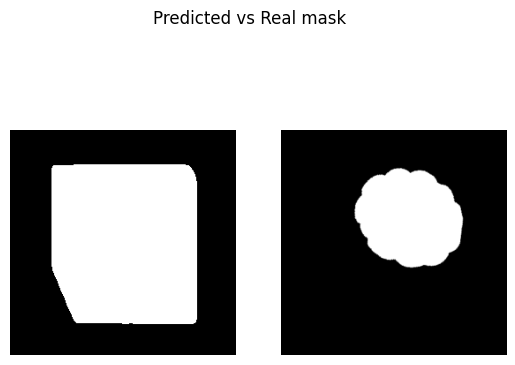

Epoch 37  train_loss=0.3078441520531972 train_iou=0.3200719306866328 val_loss=0.28259527186552685 val_iou=0.02488944058616956


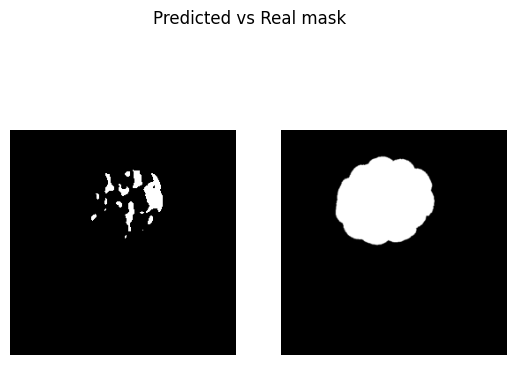

Epoch 38  train_loss=0.3122660666704178 train_iou=0.25993335992097855 val_loss=0.3042939305305481 val_iou=0.6471663117408752


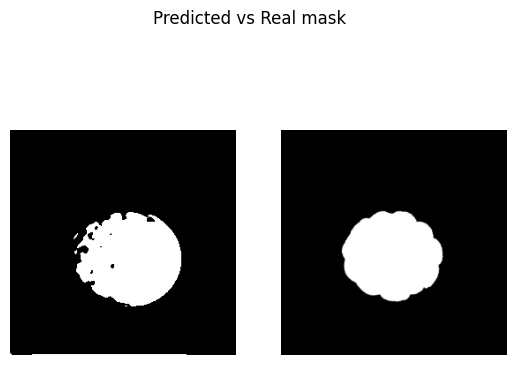

Epoch 39  train_loss=0.27761168281237286 train_iou=0.2208319283866634 val_loss=0.30644021431605023 val_iou=0.7271486322085062


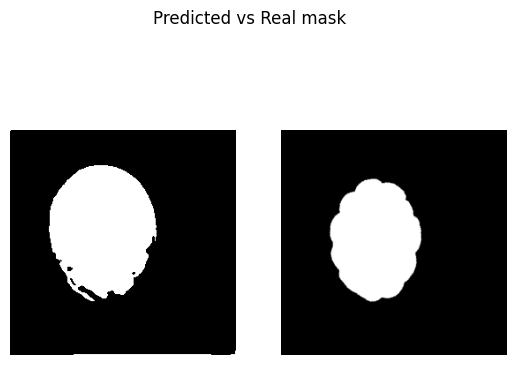

Epoch 40  train_loss=0.2877593735853831 train_iou=0.5117215613524119 val_loss=0.32859136660893756 val_iou=0.2775258521238963


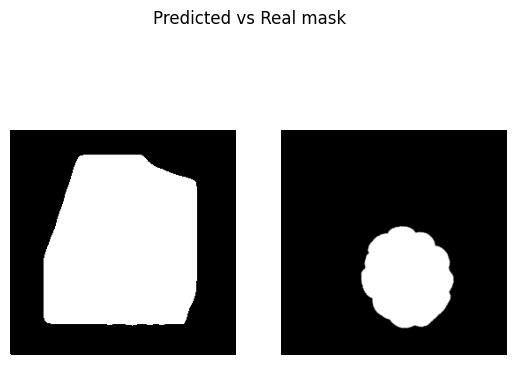

Epoch 41  train_loss=0.29595323900381726 train_iou=0.2700018634398778 val_loss=0.26591495672861737 val_iou=0.3057410418987274


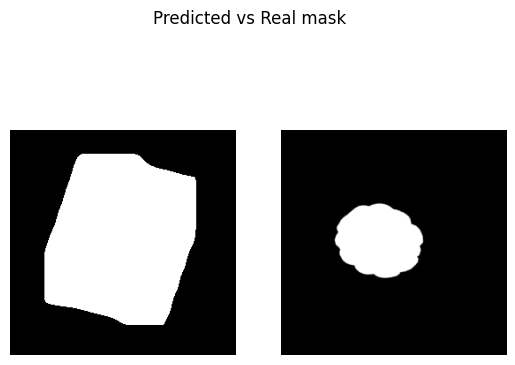

Epoch 42  train_loss=0.2561666468779246 train_iou=0.3062104880809784 val_loss=0.26396894454956055 val_iou=0.5014811555544535


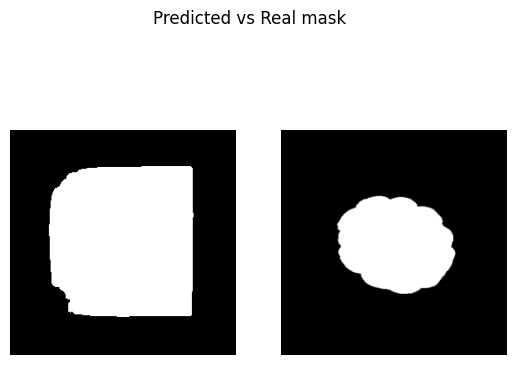

Epoch 43  train_loss=0.2950832098722458 train_iou=0.3685740027576685 val_loss=0.25898127754529315 val_iou=0.3331807653109233


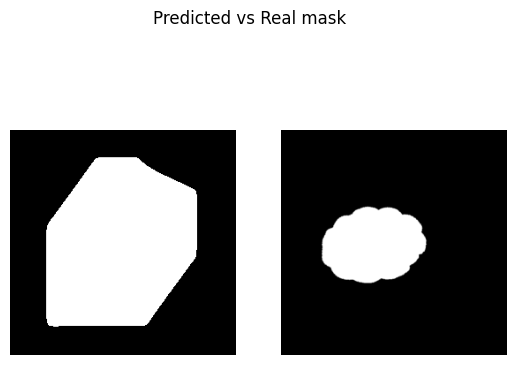

Epoch 44  train_loss=0.28221863011519116 train_iou=0.31901469826698303 val_loss=0.2850102186203003 val_iou=0.35242049892743427


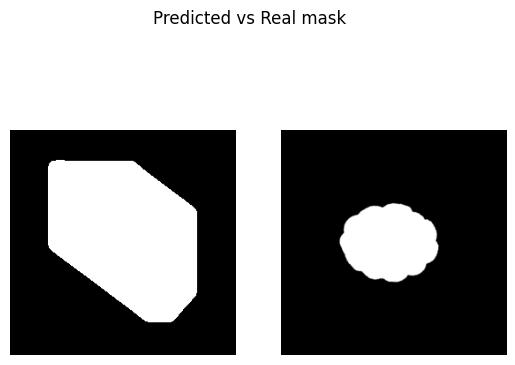

Epoch 45  train_loss=0.31438589344422024 train_iou=0.2677224601308505 val_loss=0.31122565269470215 val_iou=0.2537188033262889


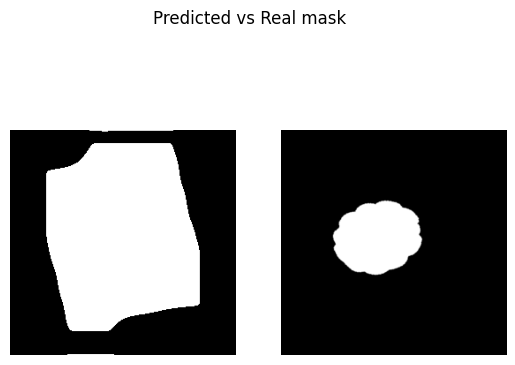

Epoch 46  train_loss=0.26777250568072003 train_iou=0.2611382727821668 val_loss=0.3248380621274312 val_iou=0.2929416100184123


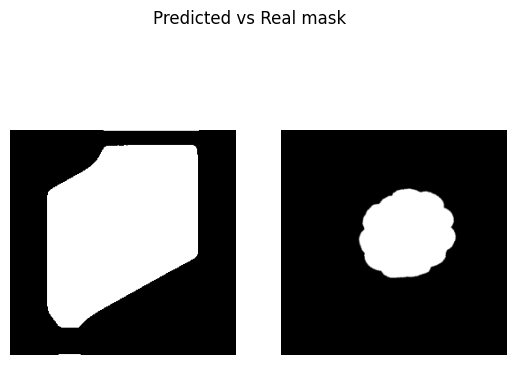

Epoch 47  train_loss=0.29155752807855606 train_iou=0.2506634121139844 val_loss=0.2742680013179779 val_iou=0.25246275464693707


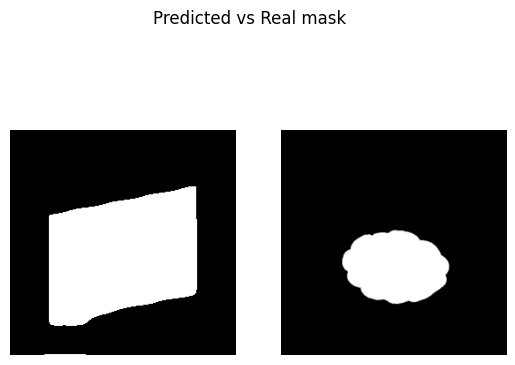

Epoch 48  train_loss=0.29119322697321576 train_iou=0.30986780921618146 val_loss=0.346845547358195 val_iou=0.32394399245580036


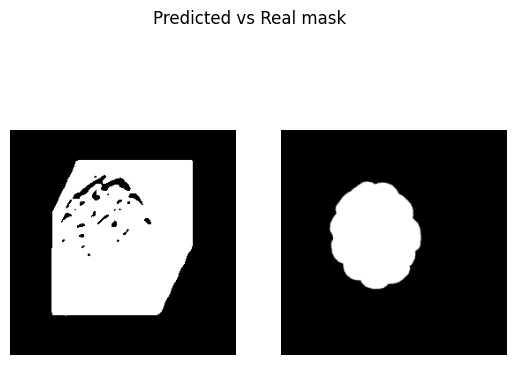

Epoch 49  train_loss=0.2743723690509796 train_iou=0.3067661076784134 val_loss=0.4049599270025889 val_iou=0.25297431151072186


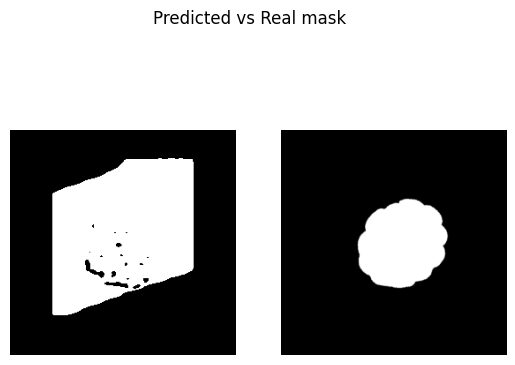

Epoch 50  train_loss=0.2674914499123891 train_iou=0.31106601158777875 val_loss=0.3685270845890045 val_iou=0.34720270832379657


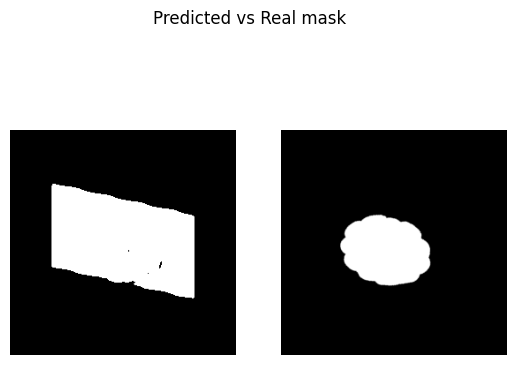

Epoch 51  train_loss=0.24068924287954965 train_iou=0.31648964683214825 val_loss=0.2327930231889089 val_iou=0.3224969208240509


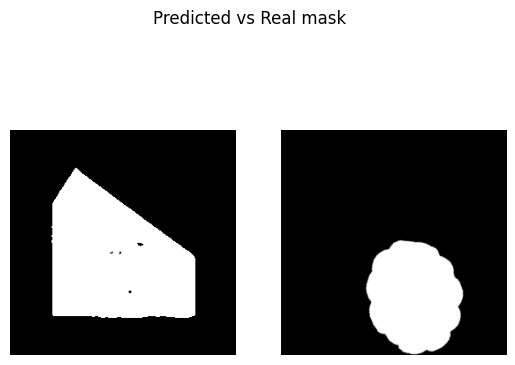

Epoch 52  train_loss=0.35842781762282055 train_iou=0.2974710116783778 val_loss=0.35058703025182086 val_iou=0.3068840603033702


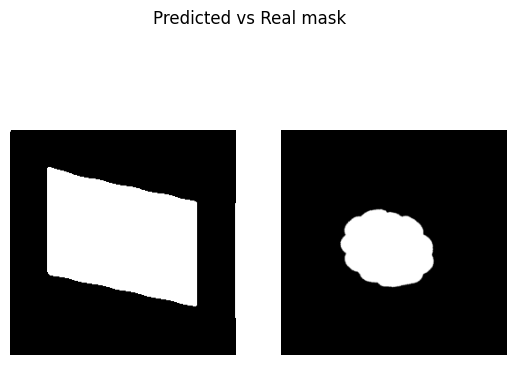

Epoch 53  train_loss=0.2979888916015625 train_iou=0.28759267926216125 val_loss=0.3290920356909434 val_iou=0.2589554488658905


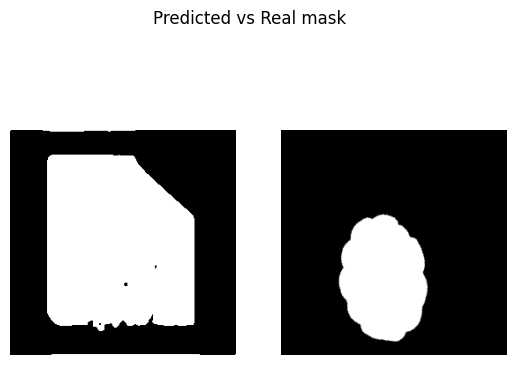

Epoch 54  train_loss=0.3015518436829249 train_iou=0.35813764731089276 val_loss=0.29510757327079773 val_iou=0.5265207886695862


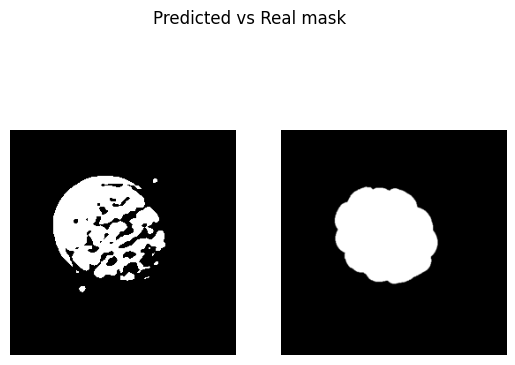

Epoch 55  train_loss=0.2982294907172521 train_iou=0.5132609903812408 val_loss=0.2669178644816081 val_iou=0.47777243455251056


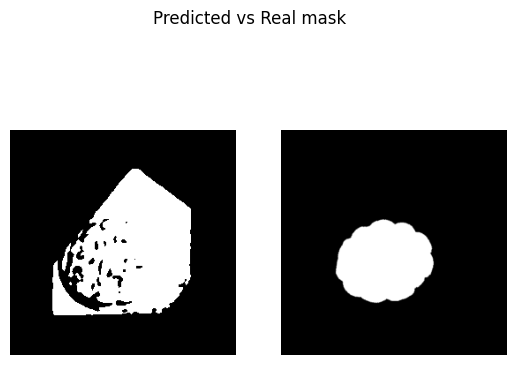

Epoch 56  train_loss=0.2614145403107007 train_iou=0.34251025319099426 val_loss=0.2333809236685435 val_iou=0.330123504002889


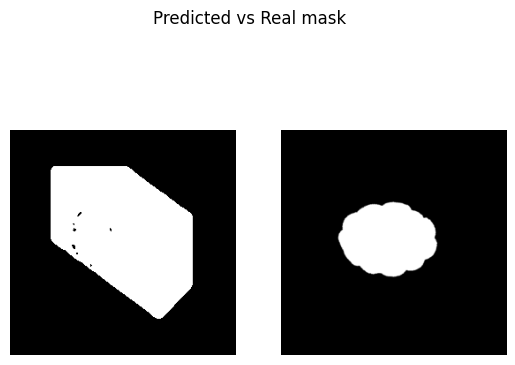

Epoch 57  train_loss=0.2746468832095464 train_iou=0.3591507275899251 val_loss=0.2593858987092972 val_iou=0.3472576340039571


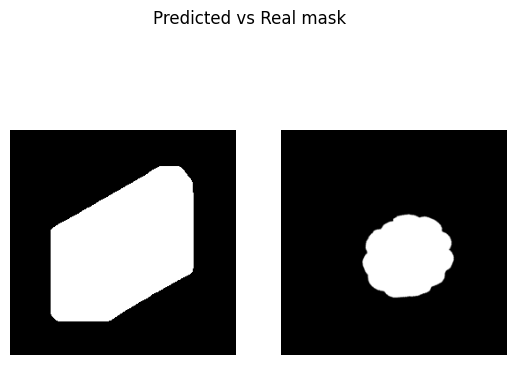

Epoch 58  train_loss=0.27809998641411465 train_iou=0.3178749705354373 val_loss=0.2708894610404968 val_iou=0.319929838180542


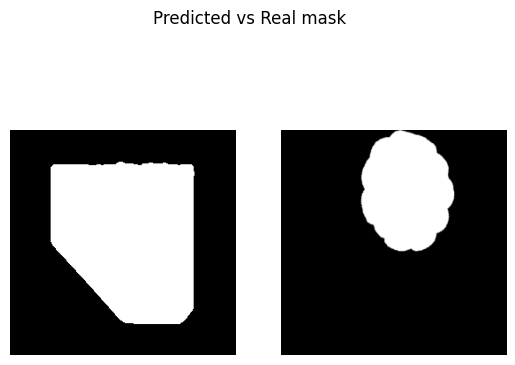

Epoch 59  train_loss=0.27158163487911224 train_iou=0.3029346813758214 val_loss=0.3128257195154826 val_iou=0.30564528703689575


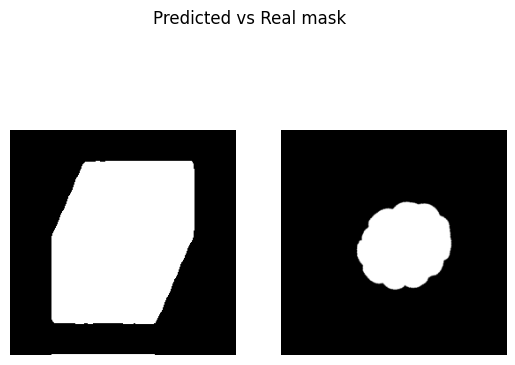

Epoch 60  train_loss=0.27198691417773563 train_iou=0.33267875264088315 val_loss=0.2592129011948903 val_iou=0.3706522484620412


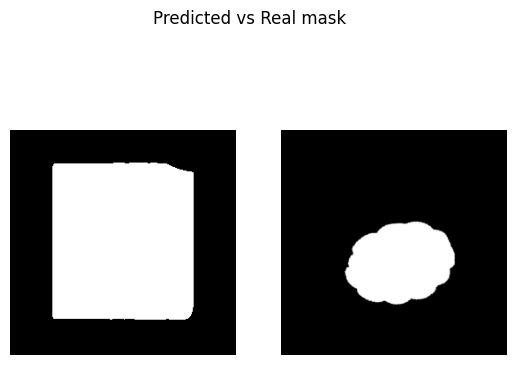

Epoch 61  train_loss=0.2632556955019633 train_iou=0.30788374940554303 val_loss=0.2811163266499837 val_iou=0.43801302711168927


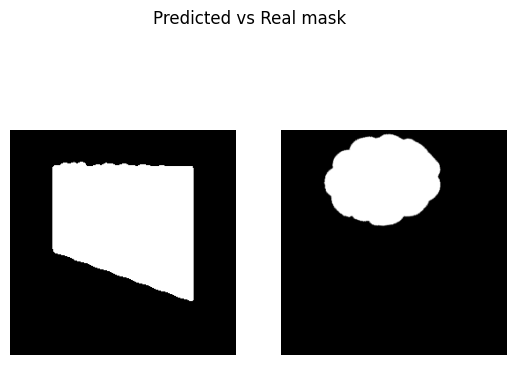

Epoch 62  train_loss=0.26593221227327984 train_iou=0.34309835731983185 val_loss=0.28363555669784546 val_iou=0.41009390354156494


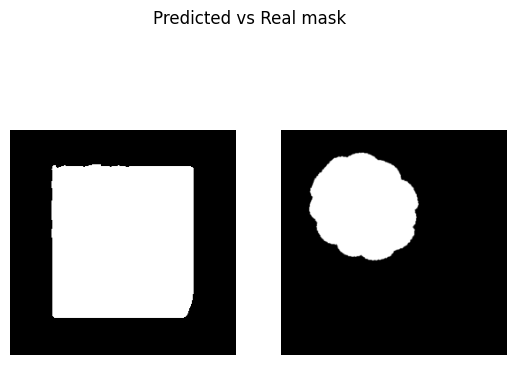

Epoch 63  train_loss=0.2576515004038811 train_iou=0.35121948023637134 val_loss=0.26343582073847455 val_iou=0.3996947705745697


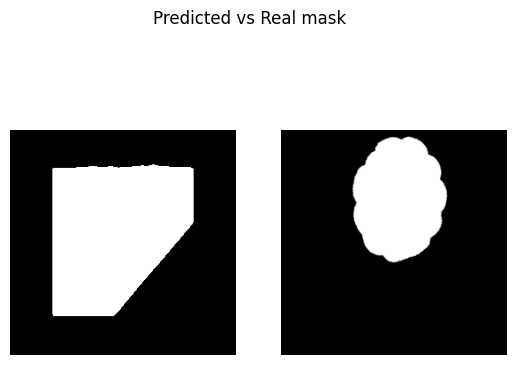

Epoch 64  train_loss=0.24402771393458048 train_iou=0.3454986959695816 val_loss=0.2609744469324748 val_iou=0.37369611859321594


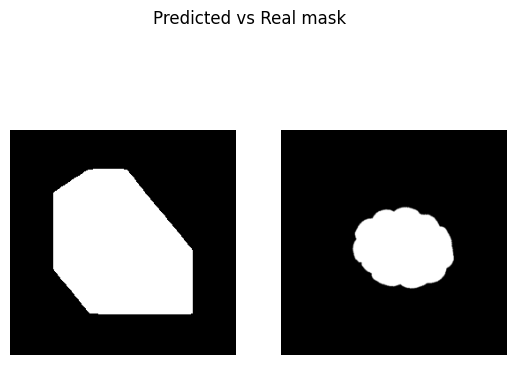

Epoch 65  train_loss=0.24213000386953354 train_iou=0.3598397970199585 val_loss=0.4752652943134308 val_iou=0.3393644690513611


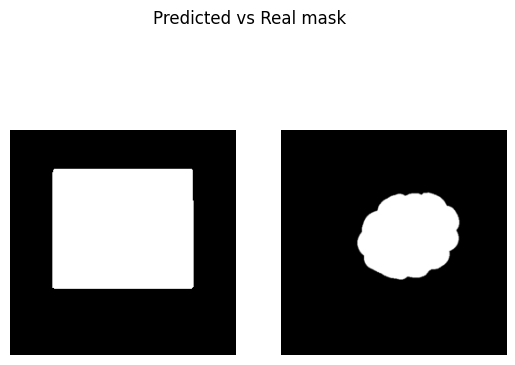

Epoch 66  train_loss=0.26383055994908017 train_iou=0.34509315093358356 val_loss=0.37068745493888855 val_iou=0.3610577980677287


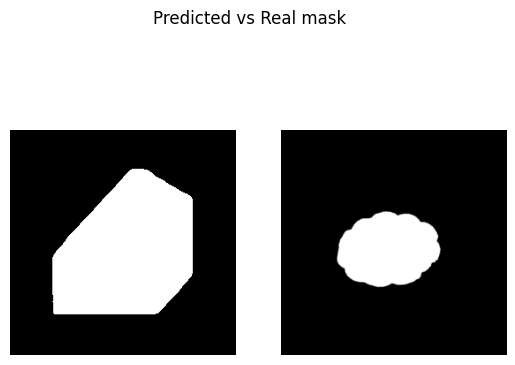

Epoch 67  train_loss=0.23316439737876257 train_iou=0.38618388772010803 val_loss=0.31921472152074176 val_iou=0.454148272673289


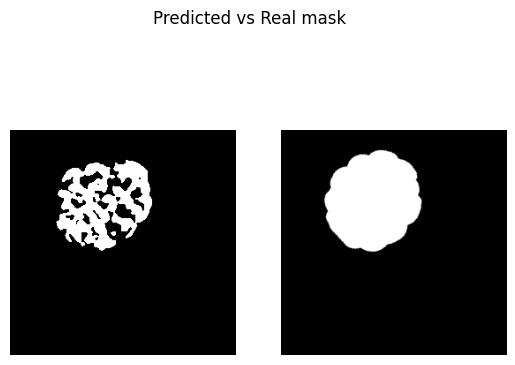

Epoch 68  train_loss=0.25374817103147507 train_iou=0.4884483317534129 val_loss=0.2570641040802002 val_iou=0.3579471508661906


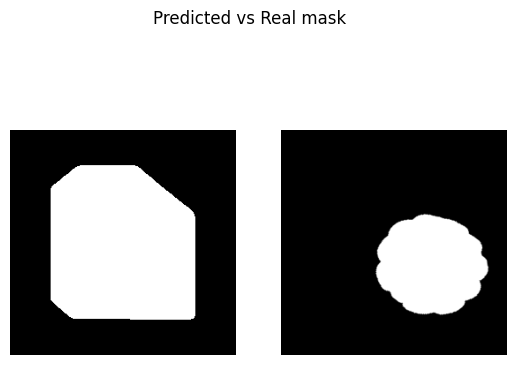

Epoch 69  train_loss=0.28396867712338764 train_iou=0.31236666440963745 val_loss=0.28766683240731555 val_iou=0.34998900691668194


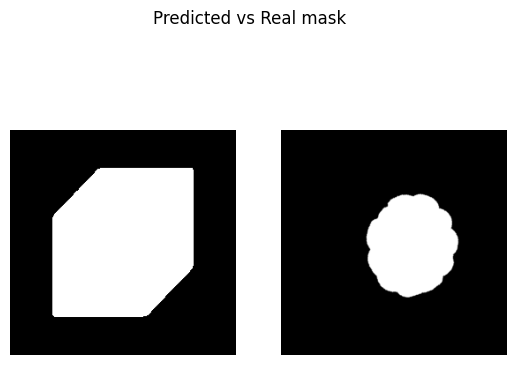

Epoch 70  train_loss=0.24326448639233908 train_iou=0.4674757917722066 val_loss=0.29911871751149494 val_iou=0.5203210115432739


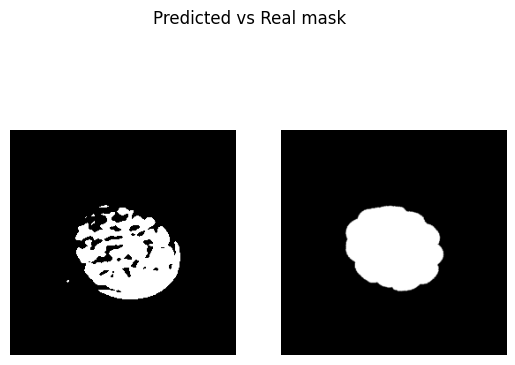

Epoch 71  train_loss=0.2610139275590579 train_iou=0.520993302265803 val_loss=0.3246571918328603 val_iou=0.2677774528662364


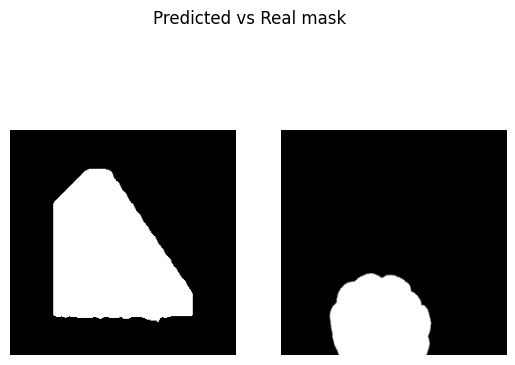

Epoch 72  train_loss=0.2668991337219874 train_iou=0.34511108696460724 val_loss=0.24681767324606577 val_iou=0.35480860869089764


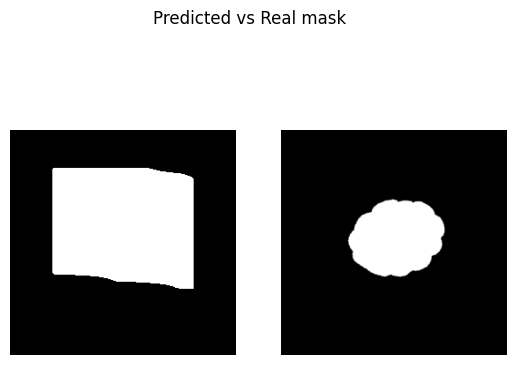

Epoch 73  train_loss=0.2477863704164823 train_iou=0.339827224612236 val_loss=0.24710914492607117 val_iou=0.4050345718860626


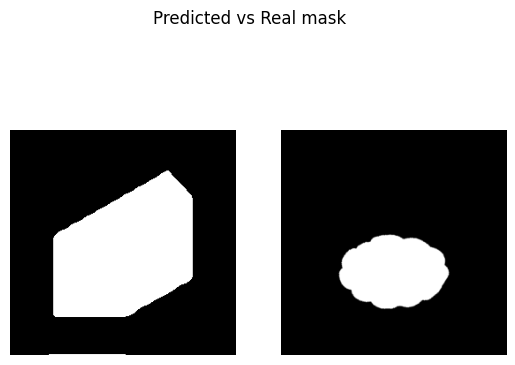

Epoch 74  train_loss=0.2341210941473643 train_iou=0.38208626707394916 val_loss=0.21931979060173035 val_iou=0.37843607862790424


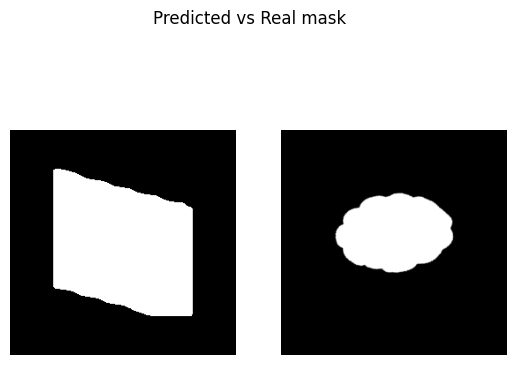

Epoch 75  train_loss=0.22586375226577124 train_iou=0.3551158159971237 val_loss=0.228691965341568 val_iou=0.774217446645101


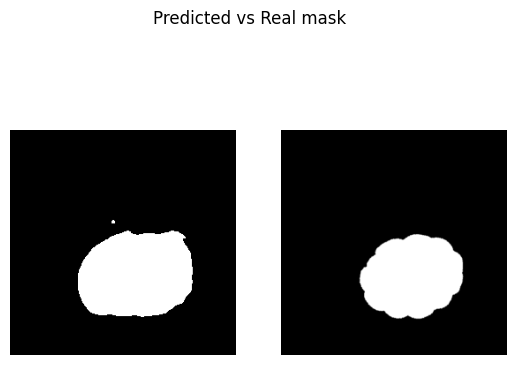

Epoch 76  train_loss=0.20433919380108514 train_iou=0.6223926196495692 val_loss=0.20505616068840027 val_iou=0.8380824128786722


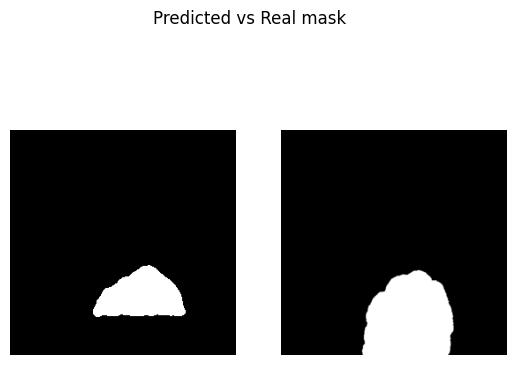

Epoch 77  train_loss=0.2302968055009842 train_iou=0.56522236764431 val_loss=0.35959620277086896 val_iou=0.6266051332155863


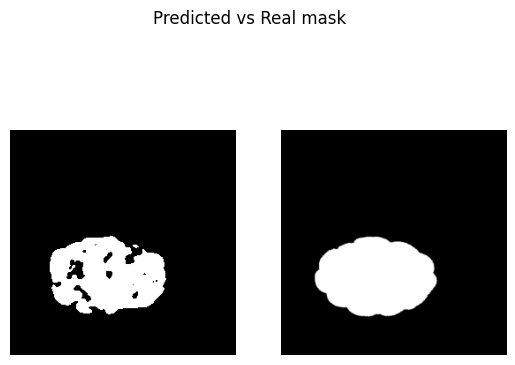

Epoch 78  train_loss=0.22817911952733994 train_iou=0.5984855939944586 val_loss=0.23152251044909158 val_iou=0.7130594452222189


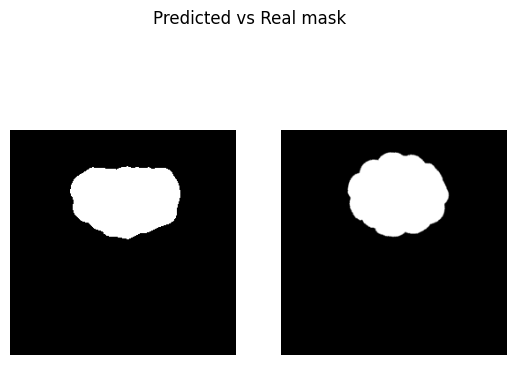

Epoch 79  train_loss=0.1881492162744204 train_iou=0.6481664180755615 val_loss=0.22597889602184296 val_iou=0.712385872999827


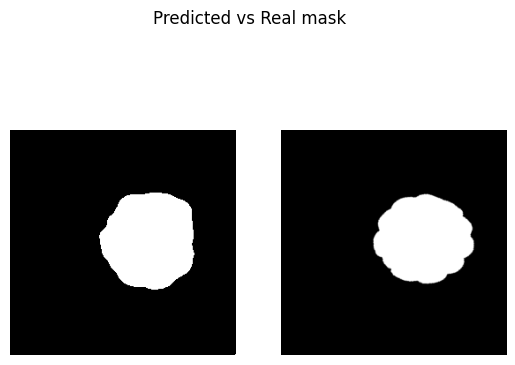

Epoch 80  train_loss=0.1730481485525767 train_iou=0.726779709259669 val_loss=0.1330842226743698 val_iou=0.6851285099983215


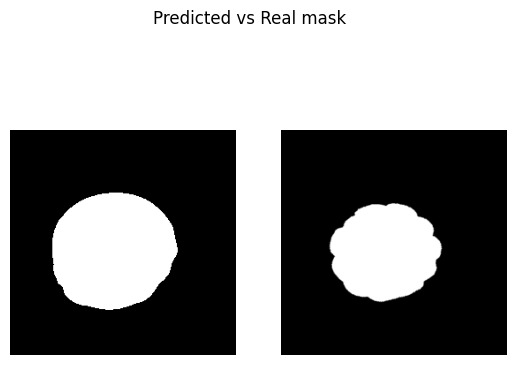

Epoch 81  train_loss=0.1838617647687594 train_iou=0.7001640796661377 val_loss=0.15344323962926865 val_iou=0.6590208609898885


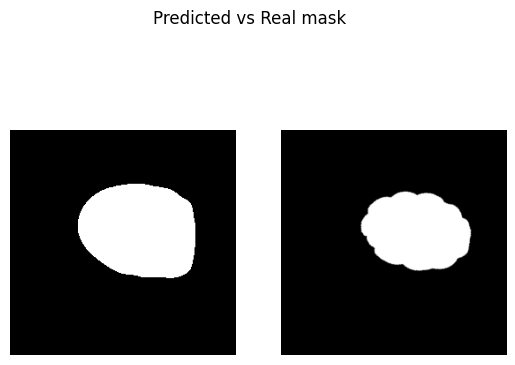

Epoch 82  train_loss=0.1438126564025879 train_iou=0.7525546749432882 val_loss=0.11496338496605556 val_iou=0.7833335002263387


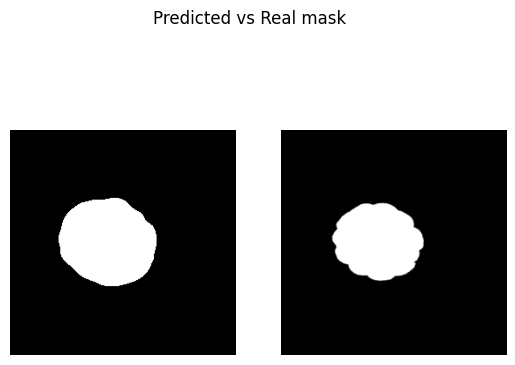

Epoch 83  train_loss=0.13557890926798186 train_iou=0.7495679756005605 val_loss=0.0872176264723142 val_iou=0.8316004276275635


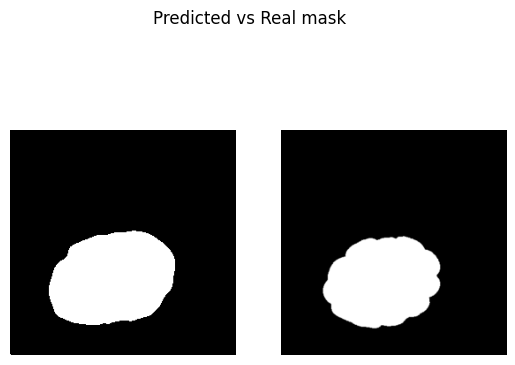

Epoch 84  train_loss=0.09607813879847527 train_iou=0.8155339459578196 val_loss=0.07012399410208066 val_iou=0.7985548973083496


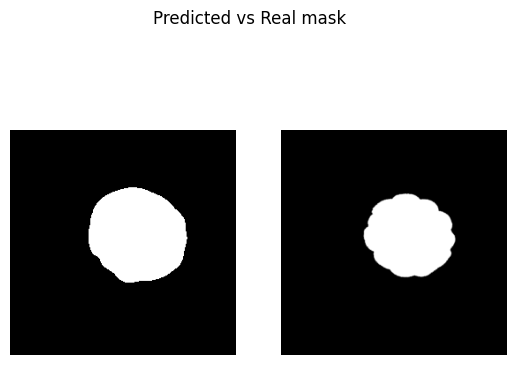

Epoch 85  train_loss=0.06858126757045586 train_iou=0.8485806087652842 val_loss=0.0564054399728775 val_iou=0.85010294119517


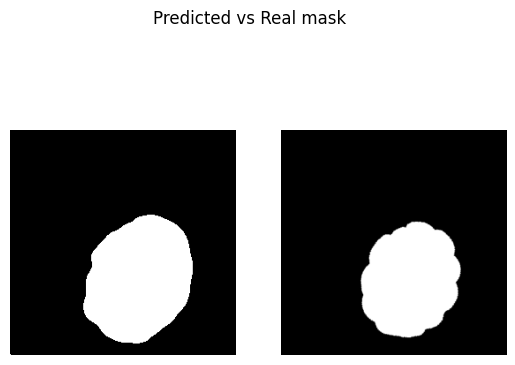

Epoch 86  train_loss=0.062324147671461105 train_iou=0.8453151186307272 val_loss=0.3201693495114644 val_iou=0.42419301470120746


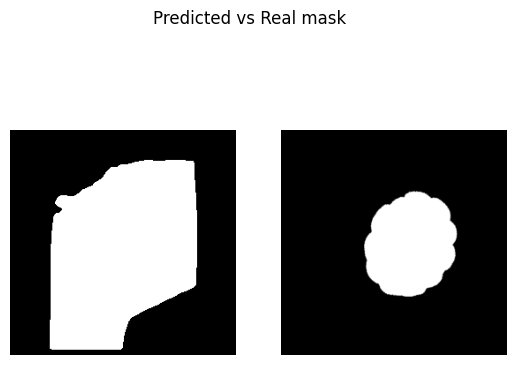

Epoch 87  train_loss=0.28437231356898945 train_iou=0.5947275261084238 val_loss=0.11534692347049713 val_iou=0.8459940354029337


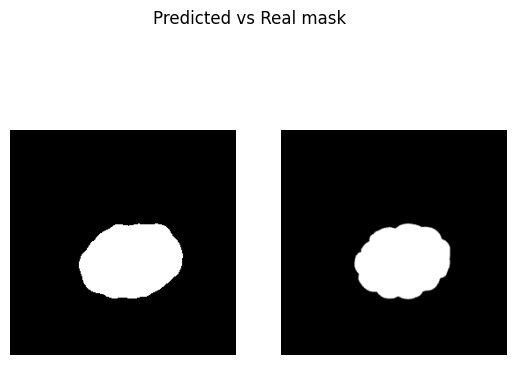

Epoch 88  train_loss=0.1265089027583599 train_iou=0.7271349827448527 val_loss=0.08370418598254521 val_iou=0.7247956196467081


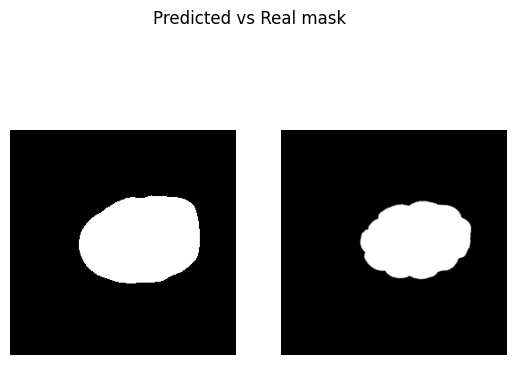

Epoch 89  train_loss=0.11242861052354176 train_iou=0.8115144769350687 val_loss=0.08881989618142445 val_iou=0.8327729105949402


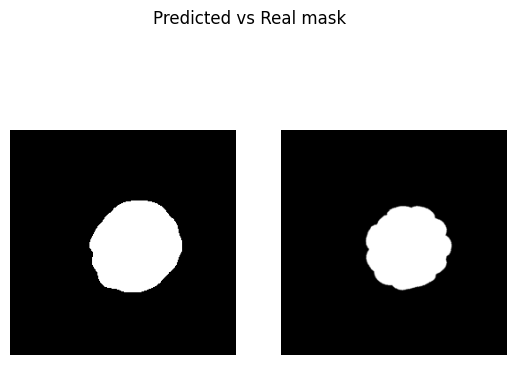

Epoch 90  train_loss=0.07256938206652801 train_iou=0.7315925657749176 val_loss=0.07617920637130737 val_iou=0.8789239724477133


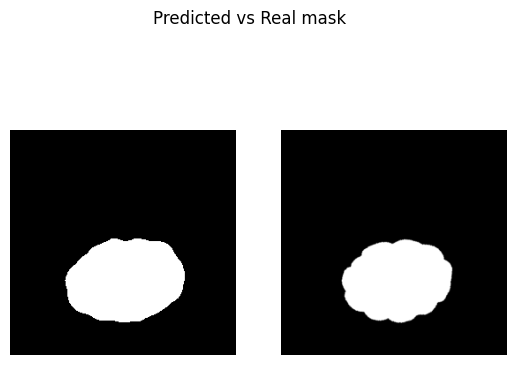

Epoch 91  train_loss=0.06577286310493946 train_iou=0.8922992944717407 val_loss=0.061620899786551796 val_iou=0.8369073073069254


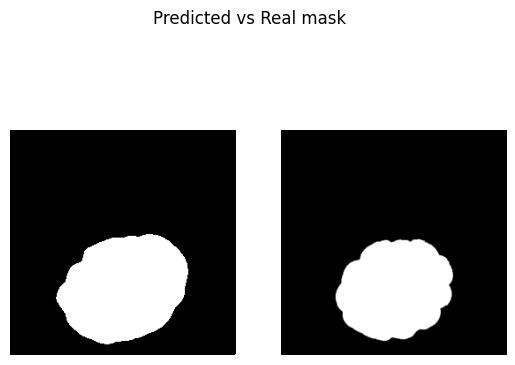

Epoch 92  train_loss=0.06280206268032391 train_iou=0.8153090278307596 val_loss=0.06993975738684337 val_iou=0.886011521021525


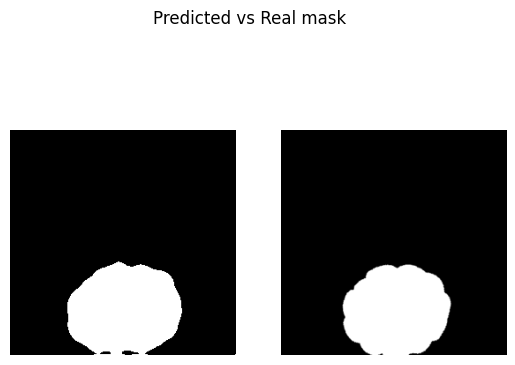

Epoch 93  train_loss=0.05436872194210688 train_iou=0.8910276591777802 val_loss=0.06696332121888797 val_iou=0.8630611697832743


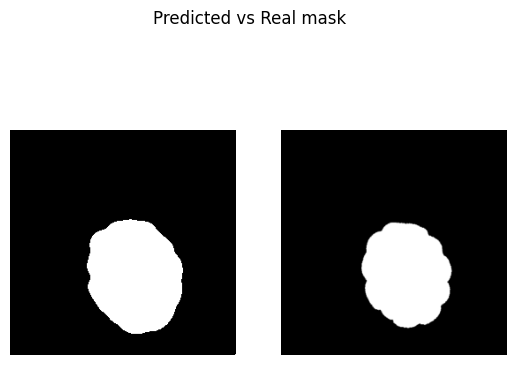

Epoch 94  train_loss=0.05851577656964461 train_iou=0.8626093864440918 val_loss=0.048435598611831665 val_iou=0.8740268548329672


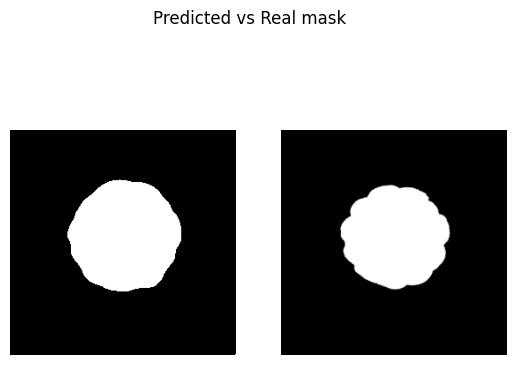

Epoch 95  train_loss=0.052810365334153175 train_iou=0.8519179920355479 val_loss=0.07289326563477516 val_iou=0.8772813479105631


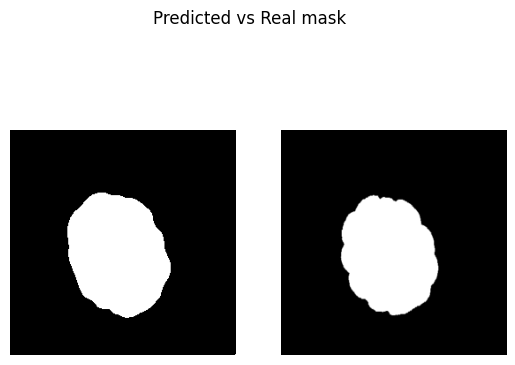

Epoch 96  train_loss=0.0426216417302688 train_iou=0.8924901982148489 val_loss=0.04641272003451983 val_iou=0.8749476472536722


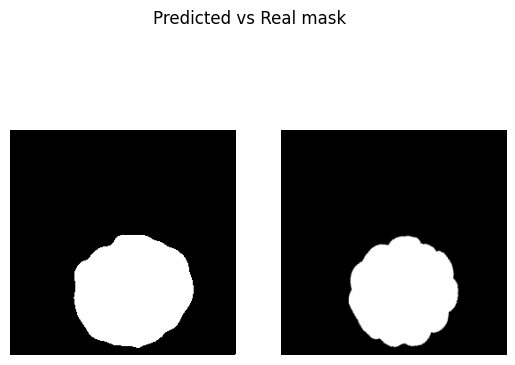

Epoch 97  train_loss=0.04291195049881935 train_iou=0.89079150557518 val_loss=0.04833194985985756 val_iou=0.8949219981829325


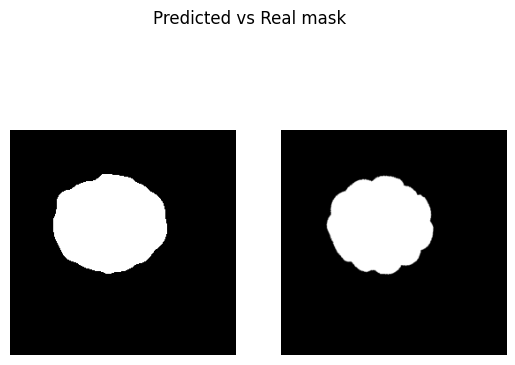

Epoch 98  train_loss=0.04557279249032339 train_iou=0.8805434902509054 val_loss=0.048657286912202835 val_iou=0.891212542851766


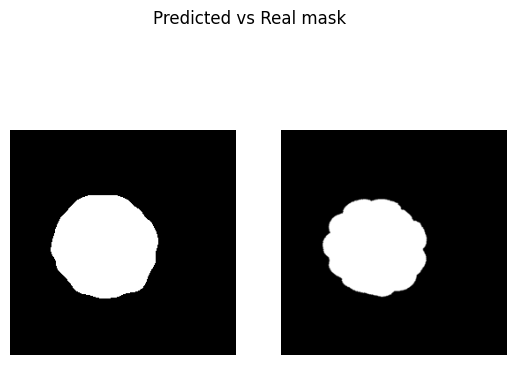

Epoch 99  train_loss=0.05242904586096605 train_iou=0.884098102649053 val_loss=0.04481223225593567 val_iou=0.9052067597707113


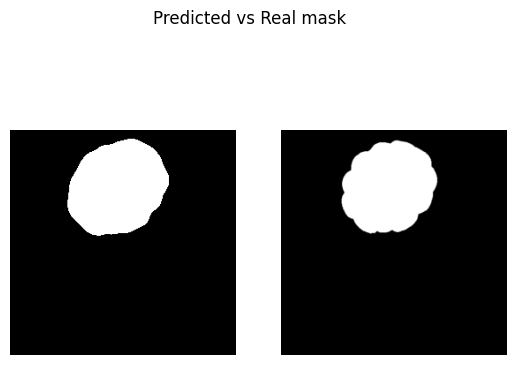

Epoch 100  train_loss=0.04421268713970979 train_iou=0.8900284171104431 val_loss=0.04102106889088949 val_iou=0.9107548793156942


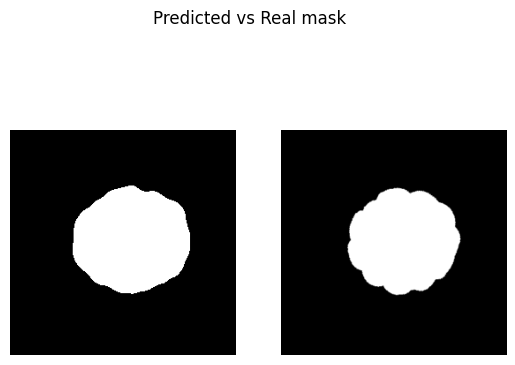

Epoch 101  train_loss=0.036911974350611367 train_iou=0.9027921855449677 val_loss=0.0420683224995931 val_iou=0.9019351998964945


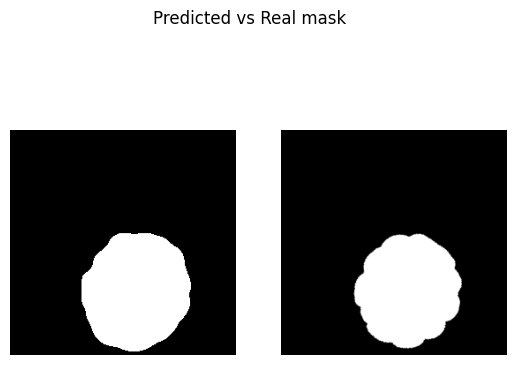

Epoch 102  train_loss=0.03821253031492233 train_iou=0.900909294684728 val_loss=0.044016788403193154 val_iou=0.8979020317395529


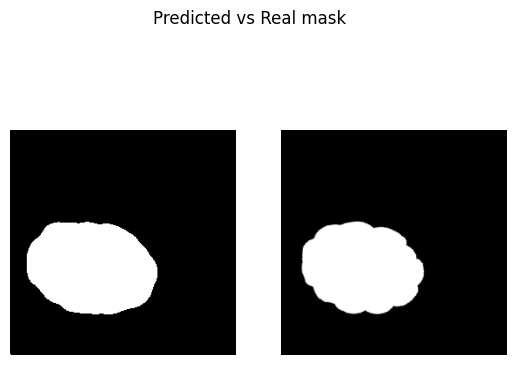

Epoch 103  train_loss=0.046809508154789604 train_iou=0.8925360043843588 val_loss=0.049062191198269524 val_iou=0.8547178705533346


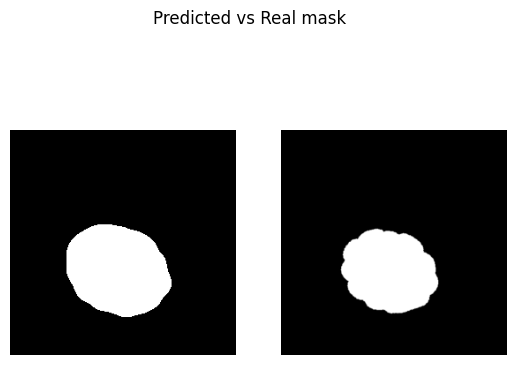

Epoch 104  train_loss=0.07915132585912943 train_iou=0.8149404923121134 val_loss=0.06683118641376495 val_iou=0.787218968073527


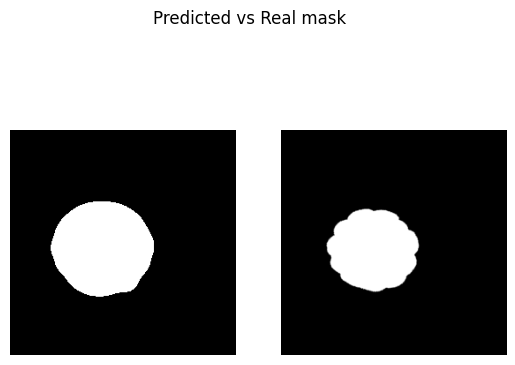

Epoch 105  train_loss=0.14702749128142992 train_iou=0.6968133002519608 val_loss=0.06782524039347966 val_iou=0.9209784070650736


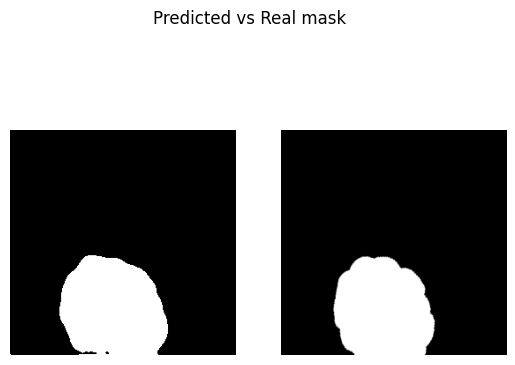

Epoch 106  train_loss=0.08368658212323983 train_iou=0.7091117203235626 val_loss=0.09346031149228413 val_iou=0.896531323591868


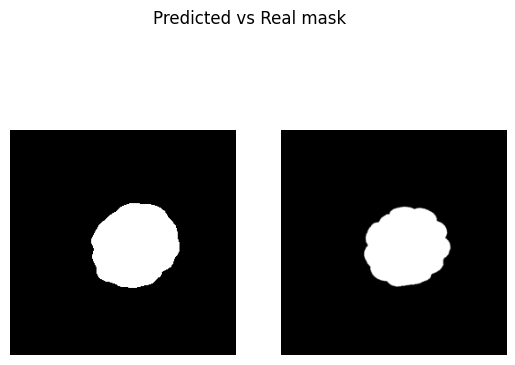

Epoch 107  train_loss=0.07493072996536891 train_iou=0.9021639227867126 val_loss=0.053636183962225914 val_iou=0.83380260070165


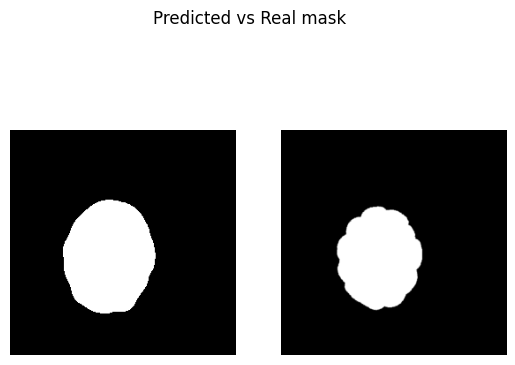

Epoch 108  train_loss=0.051003934194644295 train_iou=0.8083045283953348 val_loss=0.058803439140319824 val_iou=0.898455540339152


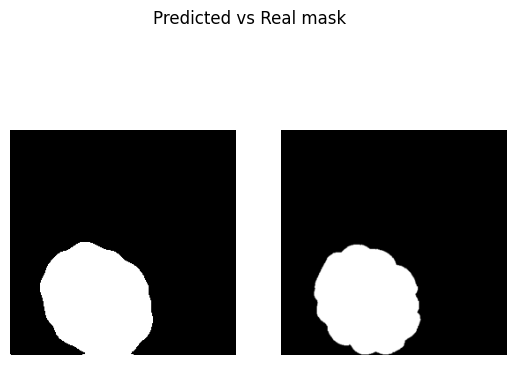

Epoch 109  train_loss=0.04606249245504538 train_iou=0.9017206331094106 val_loss=0.041841054956118263 val_iou=0.8888417681058248


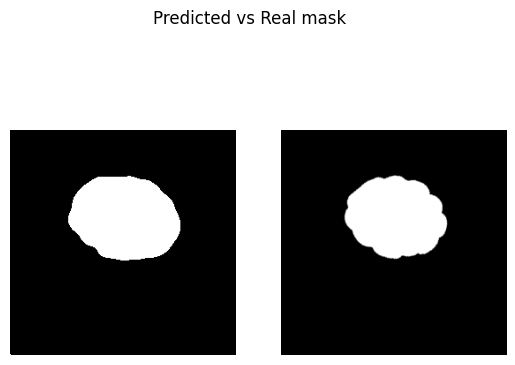

Epoch 110  train_loss=0.04416415529946486 train_iou=0.8647596637407938 val_loss=0.049810814360777535 val_iou=0.9068992535273234


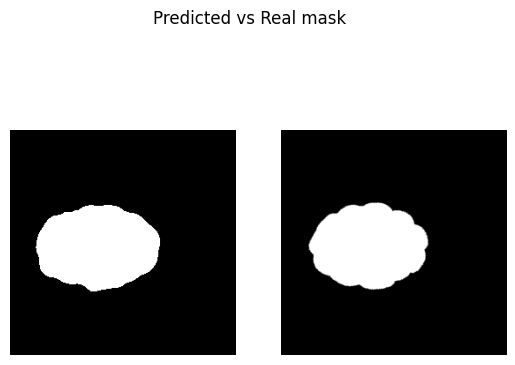

Epoch 111  train_loss=0.03731832032402357 train_iou=0.9115049839019775 val_loss=0.03448957453171412 val_iou=0.9052549401919047


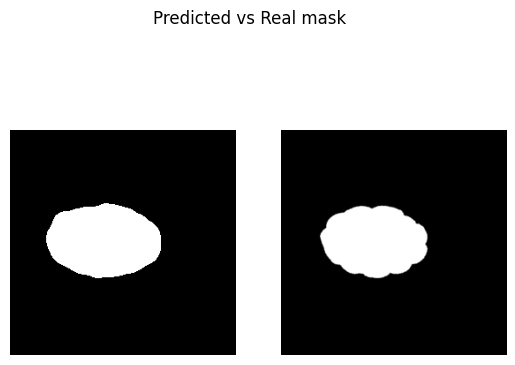

Epoch 112  train_loss=0.037433238700032234 train_iou=0.8964799841245016 val_loss=0.04383039722839991 val_iou=0.9220943649609884


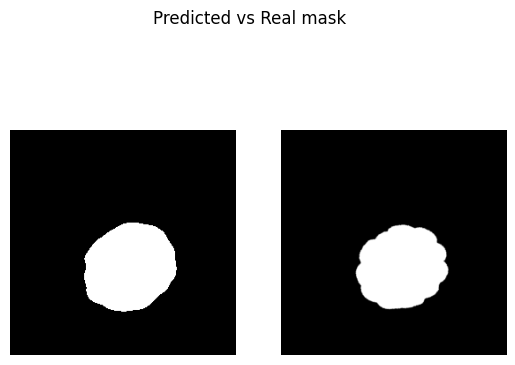

Epoch 113  train_loss=0.03326582039395968 train_iou=0.9125731786092123 val_loss=0.033231555173794426 val_iou=0.9165129065513611


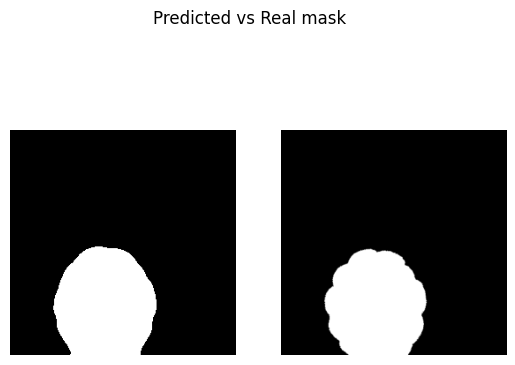

Epoch 114  train_loss=0.03221852673838536 train_iou=0.9168410301208496 val_loss=0.0448153962691625 val_iou=0.9063601692517599


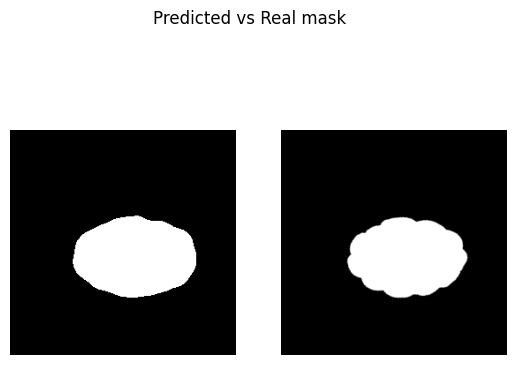

Epoch 115  train_loss=0.03182195716847976 train_iou=0.9131103654702505 val_loss=0.04115361471970876 val_iou=0.9319183627764384


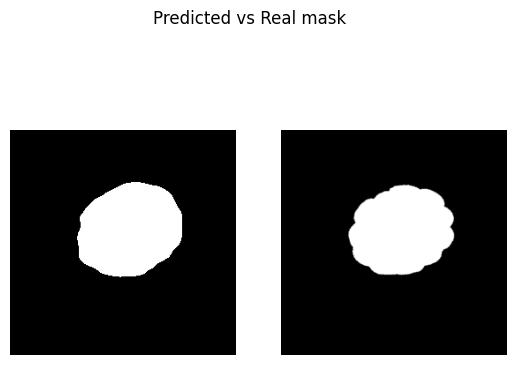

Epoch 116  train_loss=0.03032996567587058 train_iou=0.9109207292397817 val_loss=0.030698378880818684 val_iou=0.9229745070139567


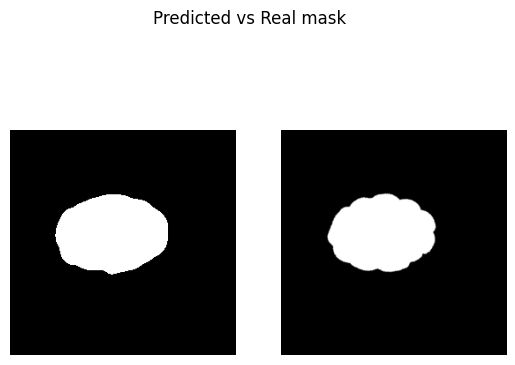

Epoch 117  train_loss=0.03217652067542076 train_iou=0.9122157593568166 val_loss=0.03836985304951668 val_iou=0.9212978680928549


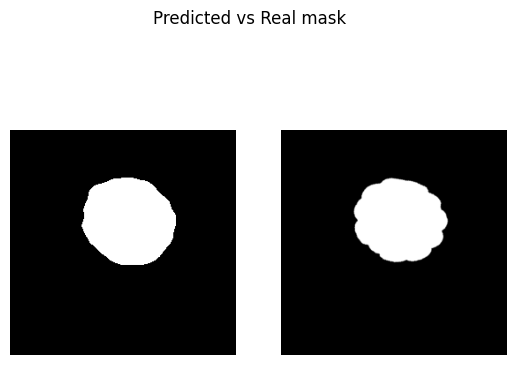

Epoch 118  train_loss=0.031432402009765305 train_iou=0.909311463435491 val_loss=0.03366867577036222 val_iou=0.9261703888575236


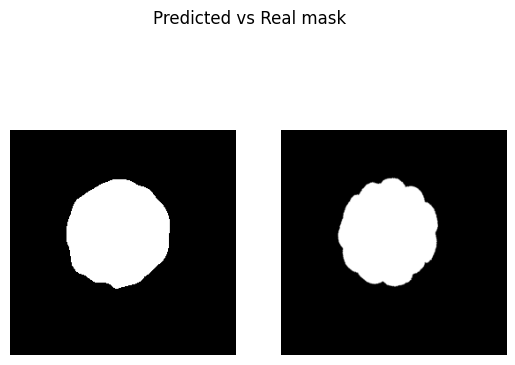

Epoch 119  train_loss=0.0284181609749794 train_iou=0.9127091765403748 val_loss=0.037808533757925034 val_iou=0.9382392962773641


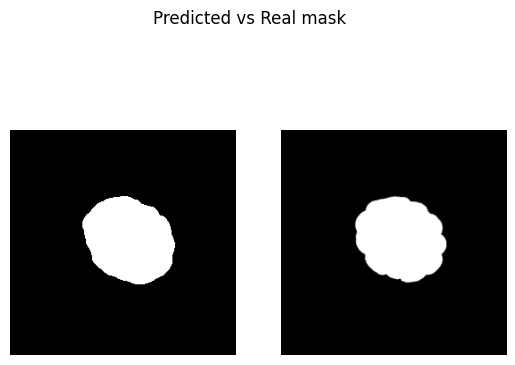

Epoch 120  train_loss=0.030723633244633675 train_iou=0.9113440116246542 val_loss=0.03551052324473858 val_iou=0.9416633049647013


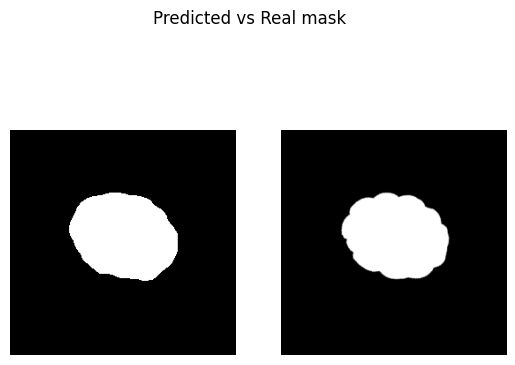

Epoch 121  train_loss=0.027953078659872215 train_iou=0.9169269502162933 val_loss=0.0309278704226017 val_iou=0.9317920207977295


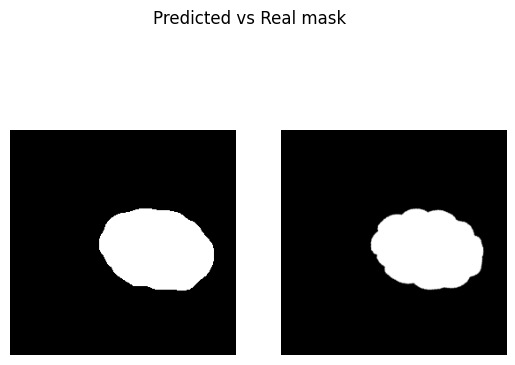

Epoch 122  train_loss=0.029400155569116276 train_iou=0.9154620369275411 val_loss=0.03386103237668673 val_iou=0.9302379687627157


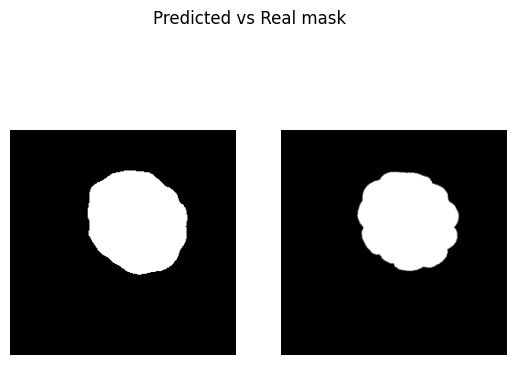

Epoch 123  train_loss=0.029801764525473118 train_iou=0.9221217830975851 val_loss=0.027588629474242527 val_iou=0.9259333809216818


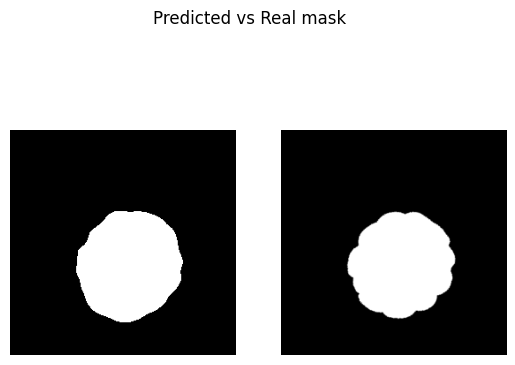

Epoch 124  train_loss=0.027733365694681805 train_iou=0.9231159587701162 val_loss=0.02363684152563413 val_iou=0.9319097399711609


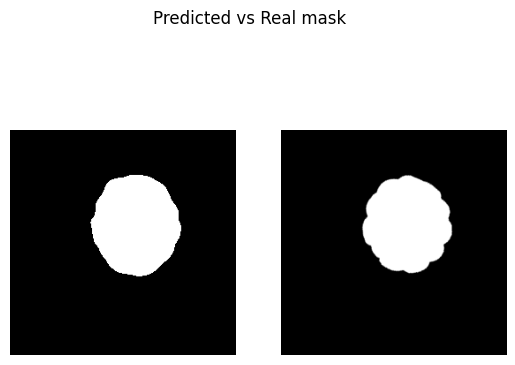

Epoch 125  train_loss=0.026020343104998272 train_iou=0.9230000575383505 val_loss=0.02569061890244484 val_iou=0.934646725654602


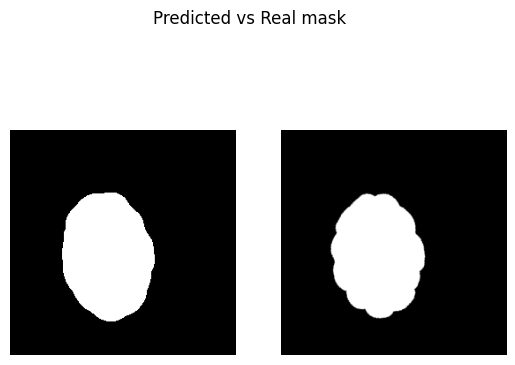

Epoch 126  train_loss=0.027489832912882168 train_iou=0.9181195000807444 val_loss=0.046660530070463814 val_iou=0.9318603277206421


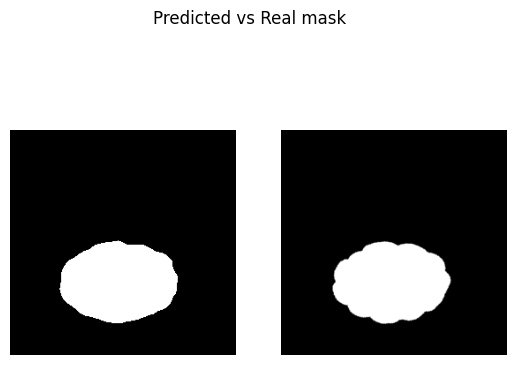

Epoch 127  train_loss=0.028874360024929047 train_iou=0.9160019357999166 val_loss=0.03485653301080068 val_iou=0.940497358640035


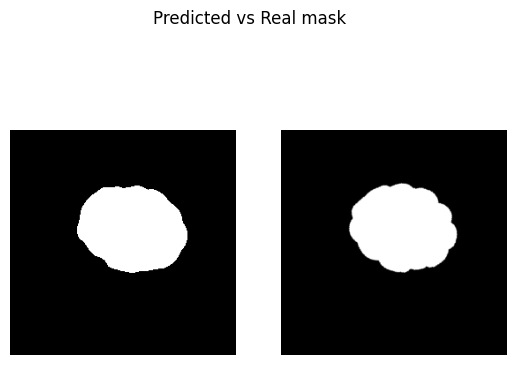

Epoch 128  train_loss=0.029783553443849087 train_iou=0.9157199164231619 val_loss=0.028900166352589924 val_iou=0.9335296551386515


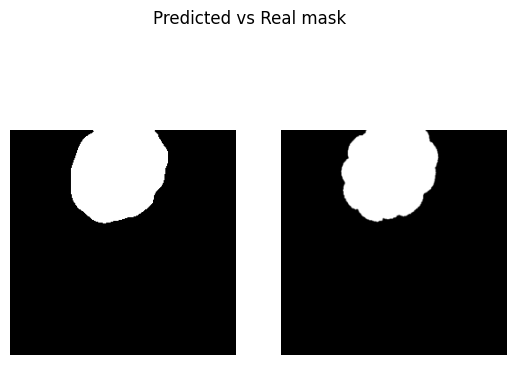

Epoch 129  train_loss=0.02915507834404707 train_iou=0.9220556120077769 val_loss=0.023207884281873703 val_iou=0.9233084718386332


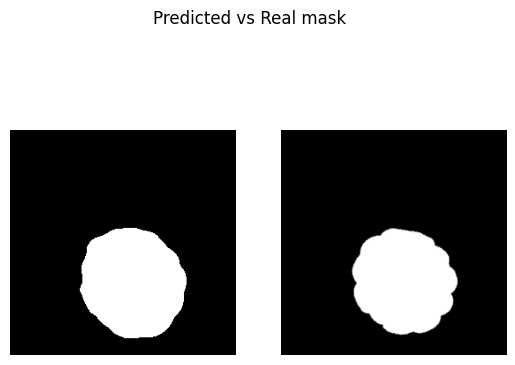

Epoch 130  train_loss=0.027647680913408596 train_iou=0.9244174659252167 val_loss=0.02586694434285164 val_iou=0.9249119758605957


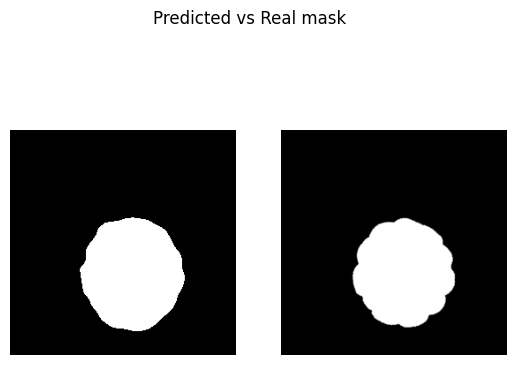

Epoch 131  train_loss=0.02307565851757924 train_iou=0.9194089472293854 val_loss=0.02877366542816162 val_iou=0.9326381683349609


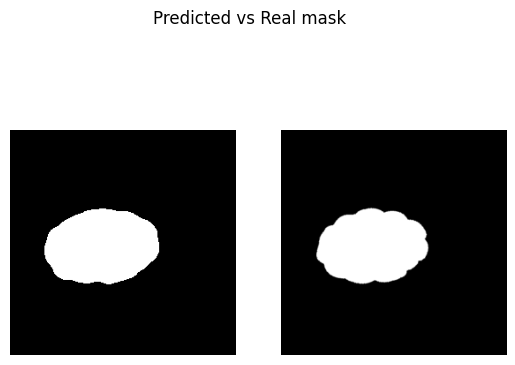

Epoch 132  train_loss=0.023103505683441956 train_iou=0.9214623073736826 val_loss=0.025332896659771603 val_iou=0.942534883817037


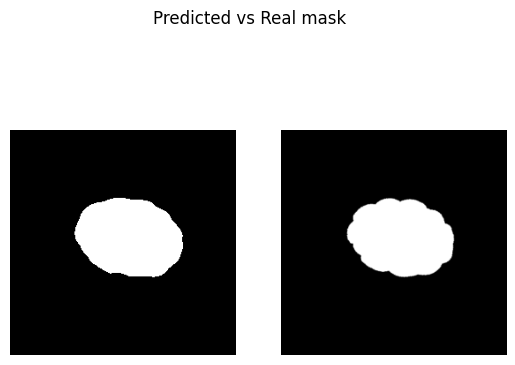

Epoch 133  train_loss=0.02596176601946354 train_iou=0.925417294104894 val_loss=0.030249544729789097 val_iou=0.9341466625531515


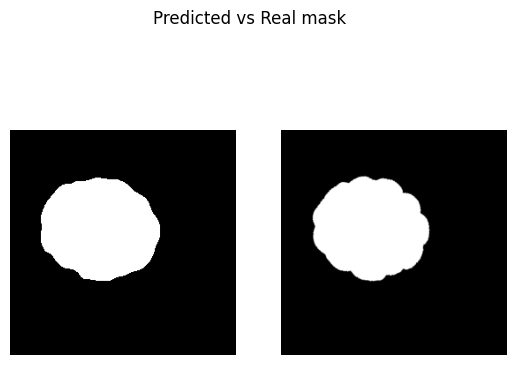

Epoch 134  train_loss=0.028642368502914906 train_iou=0.9237840076287588 val_loss=0.026685075213511784 val_iou=0.9494057297706604


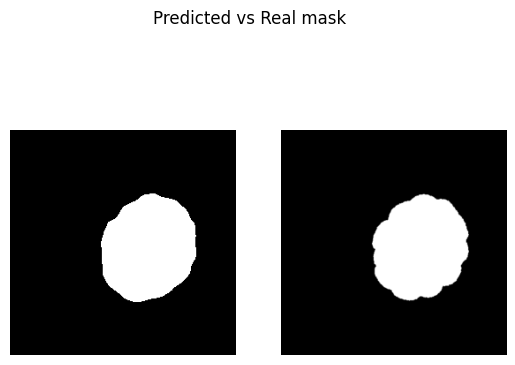

Epoch 135  train_loss=0.029339909553527832 train_iou=0.9177756806214651 val_loss=0.02893998349706332 val_iou=0.9352745612462362


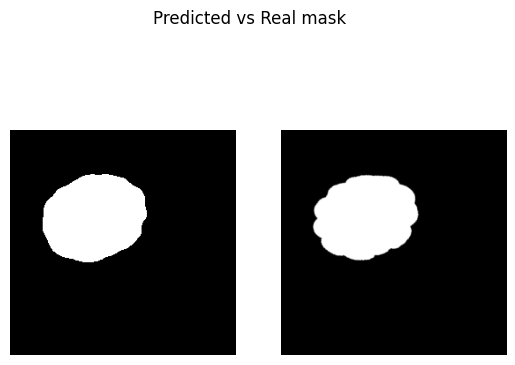

Epoch 136  train_loss=0.023404161756237347 train_iou=0.9258733093738556 val_loss=0.028572098662455876 val_iou=0.9167773524920145


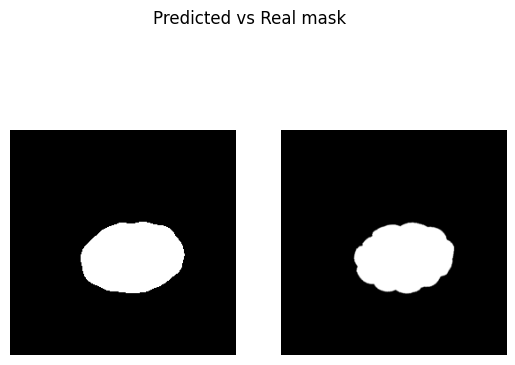

Epoch 137  train_loss=0.024552926731606323 train_iou=0.9225137631098429 val_loss=0.02678924798965454 val_iou=0.9216370185216268


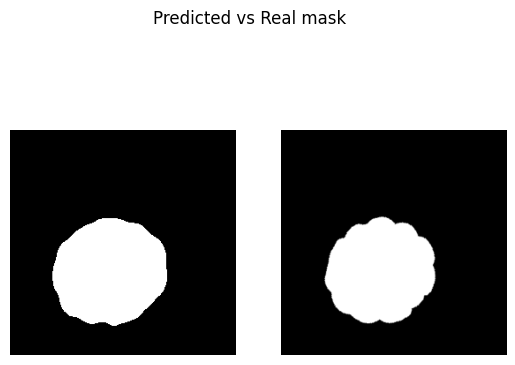

Epoch 138  train_loss=0.02155365329235792 train_iou=0.9183800021807352 val_loss=0.030032489448785782 val_iou=0.9403895735740662


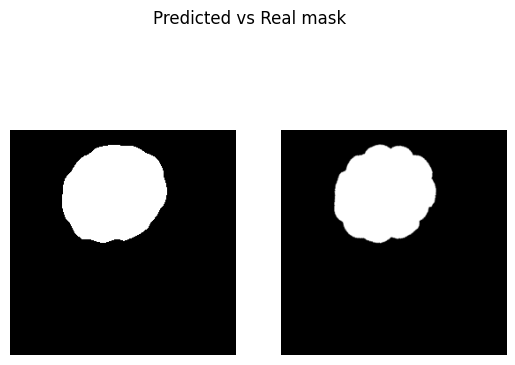

Epoch 139  train_loss=0.02276724794258674 train_iou=0.9233317573865255 val_loss=0.035549013564984 val_iou=0.9535136818885803


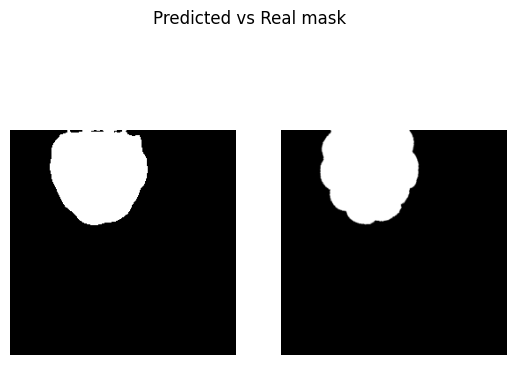

Epoch 140  train_loss=0.024800364548961323 train_iou=0.926468680302302 val_loss=0.0533231720328331 val_iou=0.935342013835907


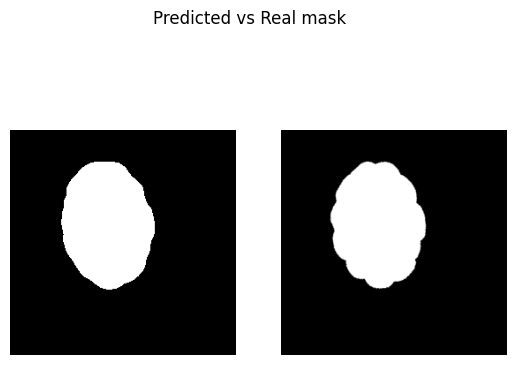

Epoch 141  train_loss=0.024006430059671402 train_iou=0.9226247072219849 val_loss=0.027975726251800854 val_iou=0.9446699817975363


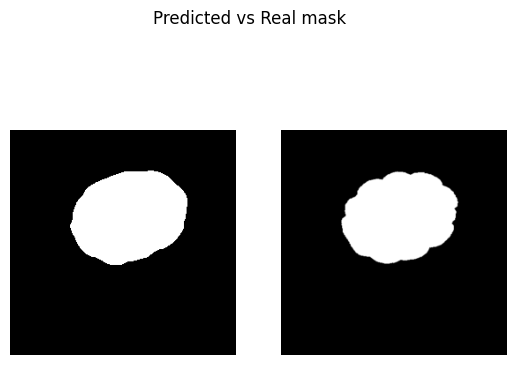

Epoch 142  train_loss=0.026435304743548233 train_iou=0.9204105933507284 val_loss=0.02845813458164533 val_iou=0.9301974972089132


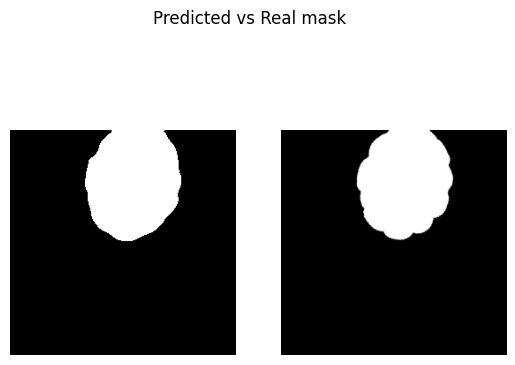

Epoch 143  train_loss=0.023535133339464664 train_iou=0.9279715617497762 val_loss=0.02398337113360564 val_iou=0.9098034302393595


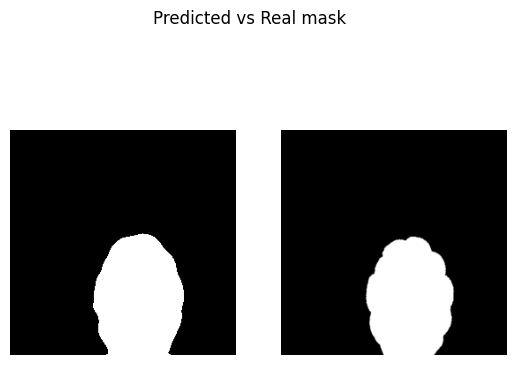

Epoch 144  train_loss=0.02095167338848114 train_iou=0.9203515450159708 val_loss=0.02338763450582822 val_iou=0.9294809301694235


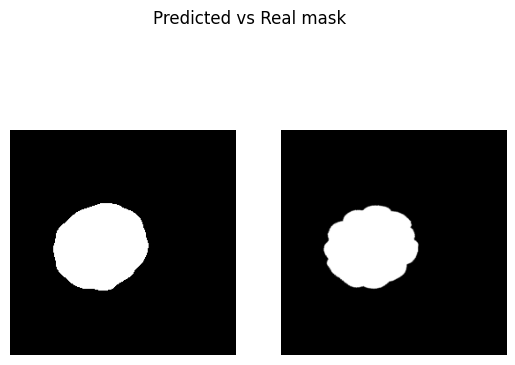

Epoch 145  train_loss=0.02261981616417567 train_iou=0.9198408524195353 val_loss=0.029225488503774006 val_iou=0.9547678629557291


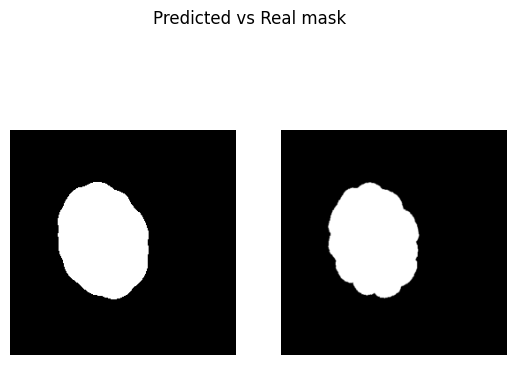

Epoch 146  train_loss=0.02333794596294562 train_iou=0.9228692054748535 val_loss=0.027400927618145943 val_iou=0.9492123325665792


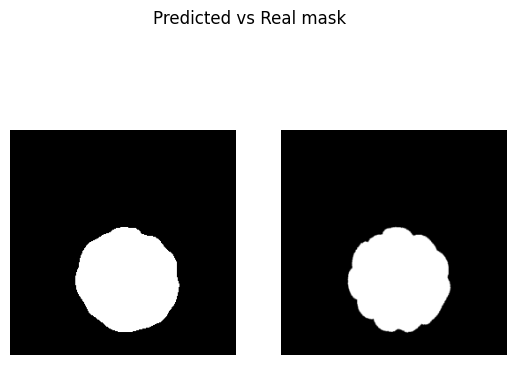

Epoch 147  train_loss=0.023480655315021675 train_iou=0.9314886132876078 val_loss=0.026321615402897198 val_iou=0.941321074962616


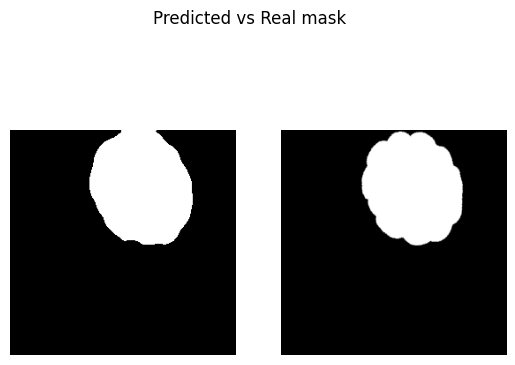

Epoch 148  train_loss=0.021859282317260902 train_iou=0.9331108828385671 val_loss=0.022863862415154774 val_iou=0.930365800857544


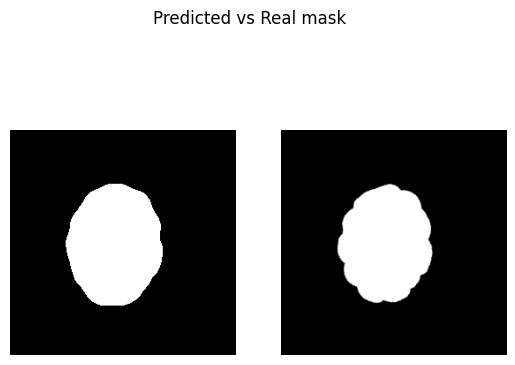

Epoch 149  train_loss=0.01971739747871955 train_iou=0.9253325462341309 val_loss=0.023197359095017116 val_iou=0.9396533568700155


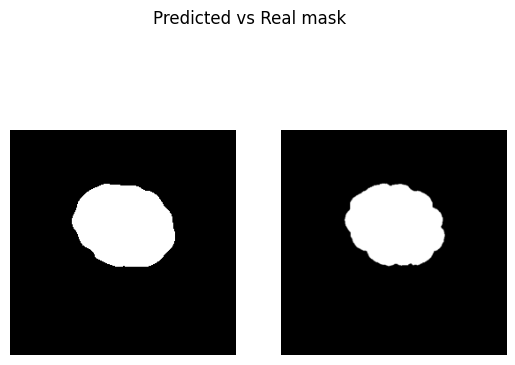

Epoch 150  train_loss=0.019589881723125774 train_iou=0.9254961013793945 val_loss=0.021320685123403866 val_iou=0.9500381747881571


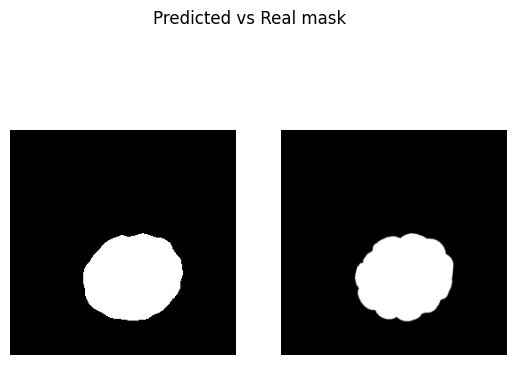

Epoch 151  train_loss=0.02153430071969827 train_iou=0.9322272737820944 val_loss=0.02839387704928716 val_iou=0.9529625376065572


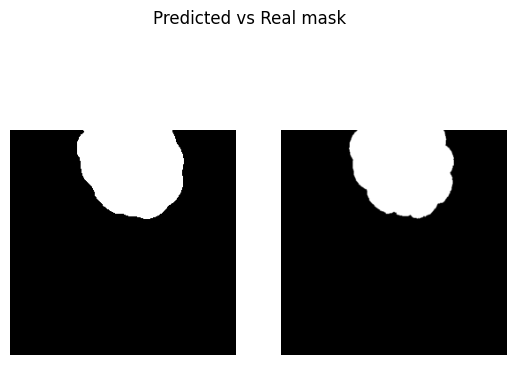

Epoch 152  train_loss=0.02026144942889611 train_iou=0.9322551886240641 val_loss=0.022679023444652557 val_iou=0.9413370490074158


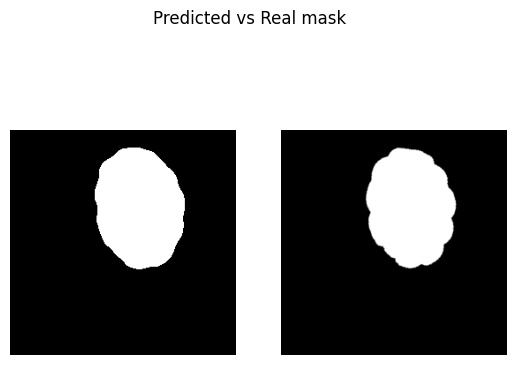

Epoch 153  train_loss=0.02332512941211462 train_iou=0.9323930541674296 val_loss=0.029784017552932102 val_iou=0.9451034267743429


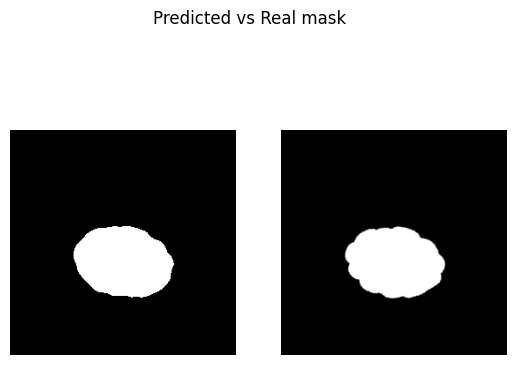

Epoch 154  train_loss=0.020726874470710754 train_iou=0.9318243662516276 val_loss=0.028871338814496994 val_iou=0.9457334677378336


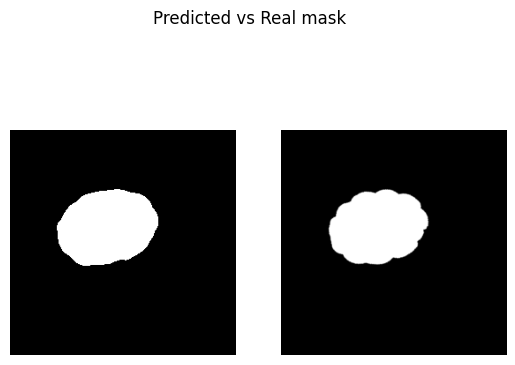

Epoch 155  train_loss=0.021104398804406326 train_iou=0.9274463057518005 val_loss=0.023220700522263844 val_iou=0.923967719078064


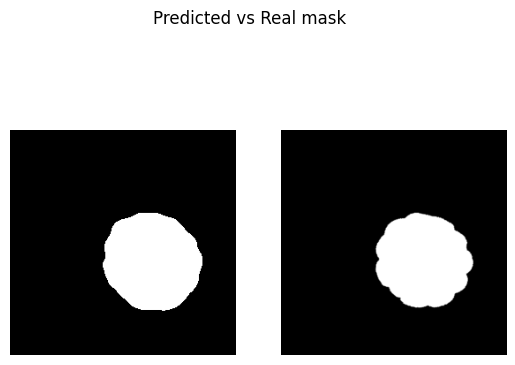

Epoch 156  train_loss=0.02104626161356767 train_iou=0.9299315611521403 val_loss=0.022722356331845123 val_iou=0.9221819837888082


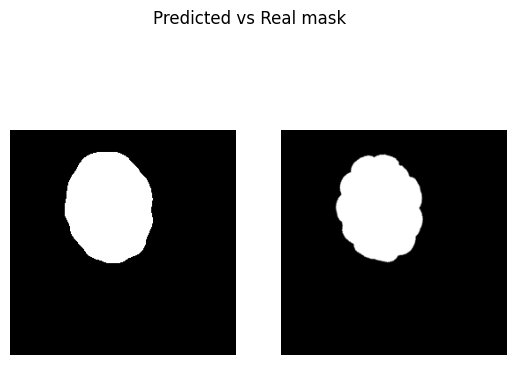

Epoch 157  train_loss=0.021829003157715004 train_iou=0.9280076622962952 val_loss=0.022780102988084156 val_iou=0.9334214329719543


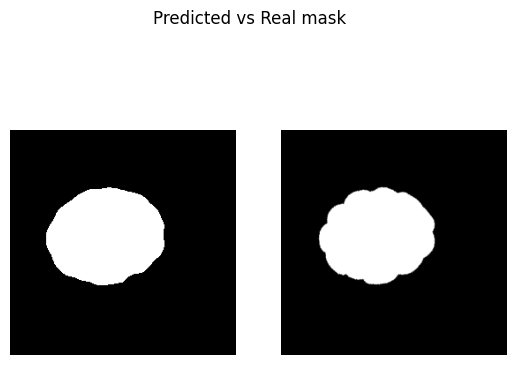

Epoch 158  train_loss=0.02221443255742391 train_iou=0.9327768782774607 val_loss=0.025390008464455605 val_iou=0.9456154306729635


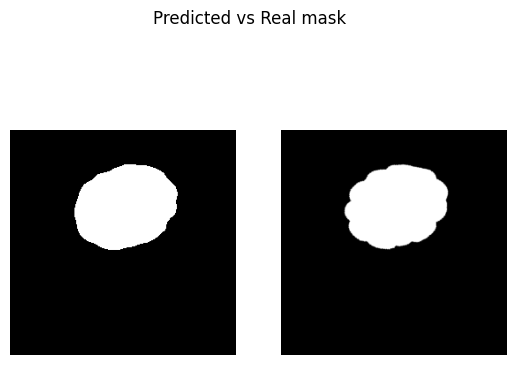

Epoch 159  train_loss=0.0214748652651906 train_iou=0.9292449454466502 val_loss=0.03660804654161135 val_iou=0.9514416058858236


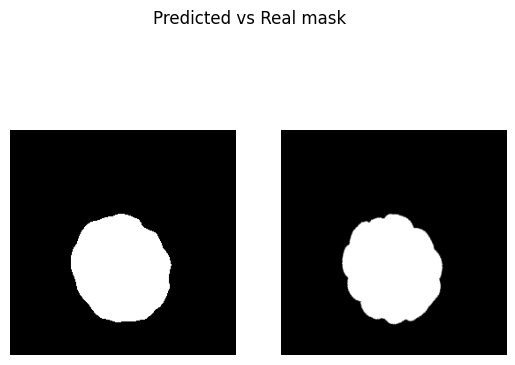

Epoch 160  train_loss=0.02121482603251934 train_iou=0.9282905260721842 val_loss=0.027914815892775852 val_iou=0.9497006138165792


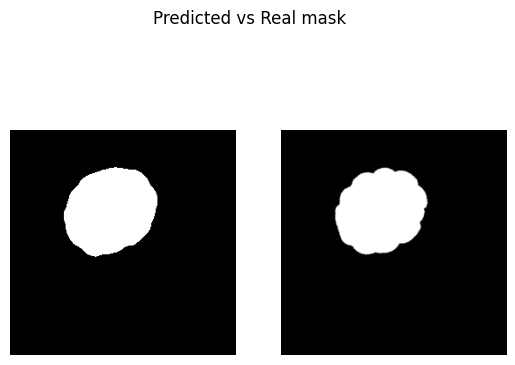

Epoch 161  train_loss=0.022163899925847847 train_iou=0.9363649686177572 val_loss=0.021501372878750164 val_iou=0.925718625386556


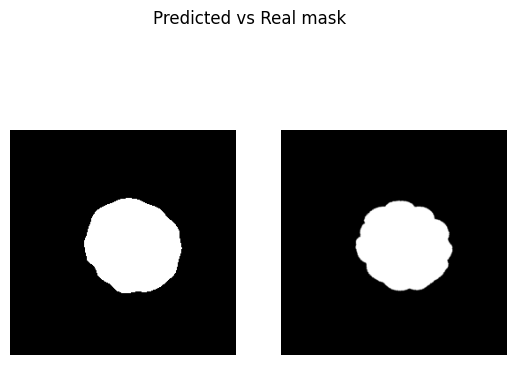

Epoch 162  train_loss=0.02307052630931139 train_iou=0.9320750633875529 val_loss=0.026534639298915863 val_iou=0.9260860681533813


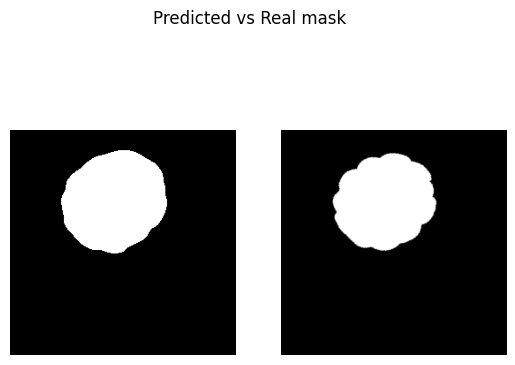

Epoch 163  train_loss=0.02941998466849327 train_iou=0.9129235148429871 val_loss=0.022494884207844734 val_iou=0.9471309781074524


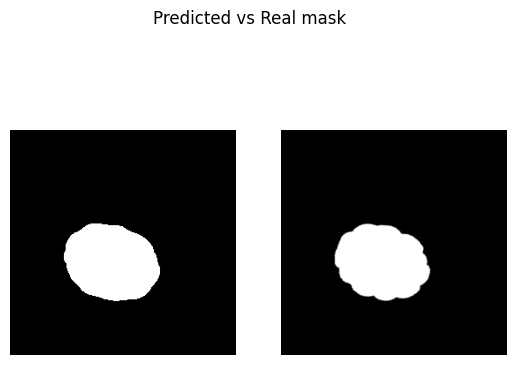

Epoch 164  train_loss=0.023403367958962917 train_iou=0.9324822723865509 val_loss=0.029145619521538418 val_iou=0.9503196477890015


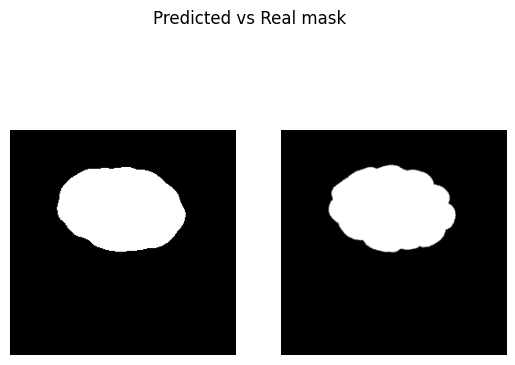

Epoch 165  train_loss=0.02415281254798174 train_iou=0.9332021872202555 val_loss=0.028590357551972072 val_iou=0.9507828752199808


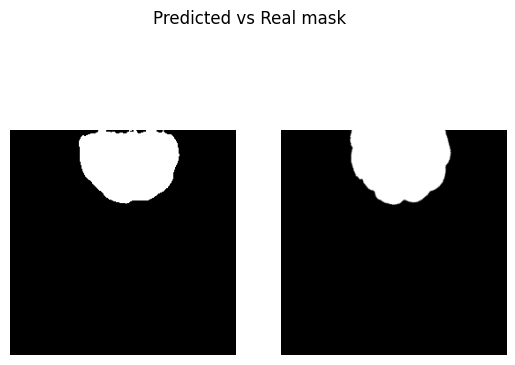

Epoch 166  train_loss=0.023260806687176228 train_iou=0.9275752206643423 val_loss=0.030840393155813217 val_iou=0.9448341131210327


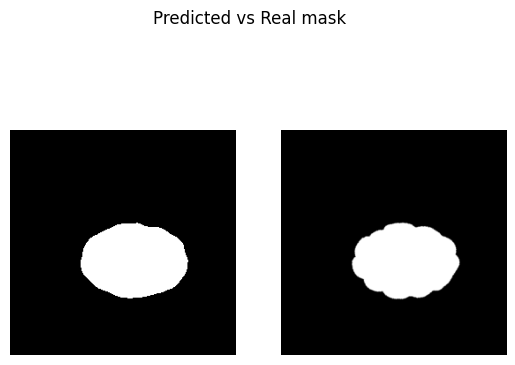

Epoch 167  train_loss=0.022050149738788605 train_iou=0.9299249748388926 val_loss=0.026222063849369686 val_iou=0.9510309298833212


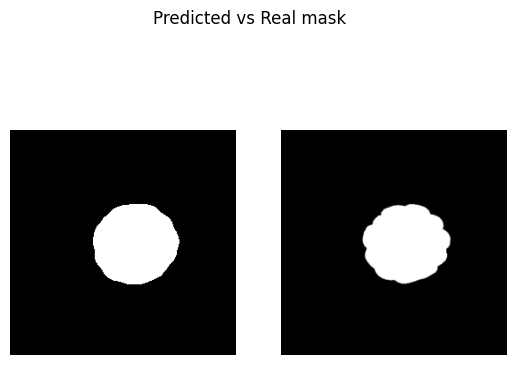

Epoch 168  train_loss=0.02435438521206379 train_iou=0.9241412778695425 val_loss=0.036799648155768715 val_iou=0.9551783601442972


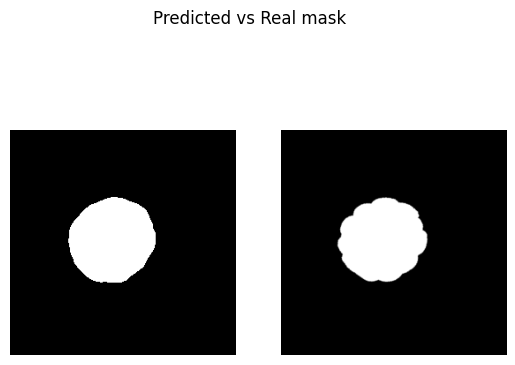

Epoch 169  train_loss=0.026739629606405895 train_iou=0.9218679666519165 val_loss=0.023091251651446026 val_iou=0.9372696677843729


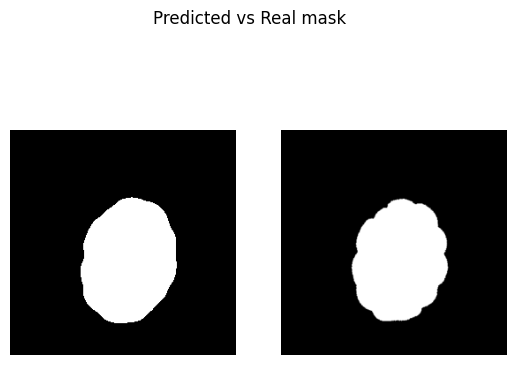

Epoch 170  train_loss=0.02327515898893277 train_iou=0.9370812674363455 val_loss=0.022729074582457542 val_iou=0.9285057783126831


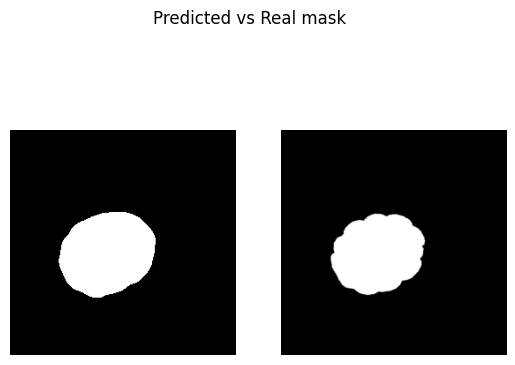

Epoch 171  train_loss=0.02085361412415902 train_iou=0.933373749256134 val_loss=0.020952460666497547 val_iou=0.9322314063707987


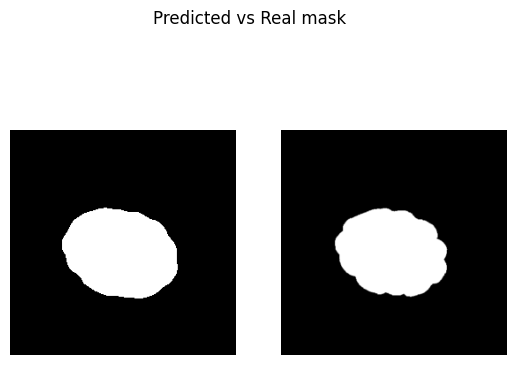

Epoch 172  train_loss=0.019396106091638405 train_iou=0.9266270895799001 val_loss=0.02127021923661232 val_iou=0.9353905916213989


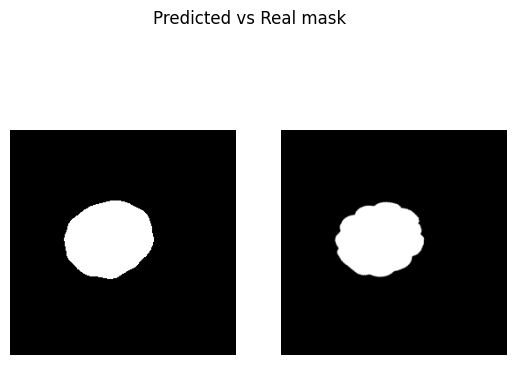

Epoch 173  train_loss=0.01849891400585572 train_iou=0.929601659377416 val_loss=0.022704004620512325 val_iou=0.941249668598175


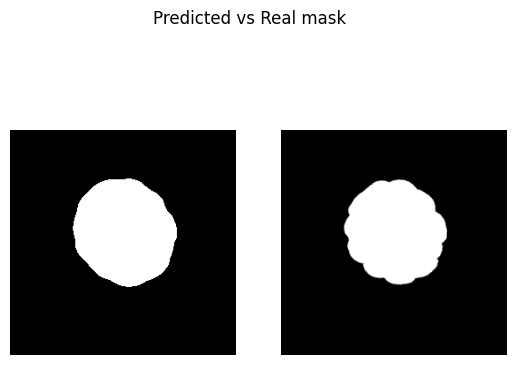

Epoch 174  train_loss=0.0197753111521403 train_iou=0.9325860142707825 val_loss=0.018983518083890278 val_iou=0.9349015553792318


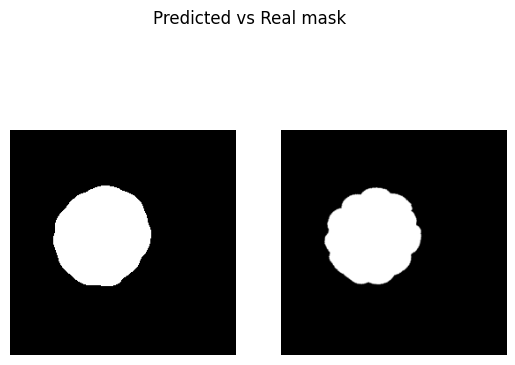

Epoch 175  train_loss=0.020154823549091816 train_iou=0.9326809346675873 val_loss=0.022431929285327595 val_iou=0.9432198603947958


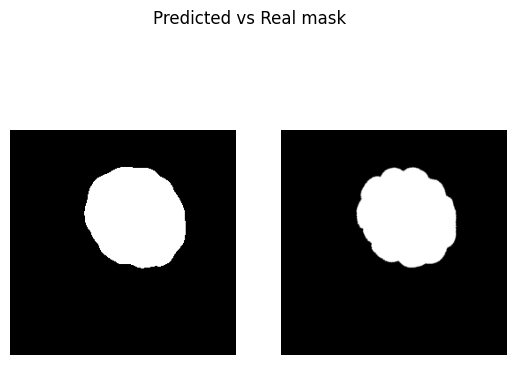

Epoch 176  train_loss=0.01835727443297704 train_iou=0.9310249090194702 val_loss=0.0236587921778361 val_iou=0.9492647449175516


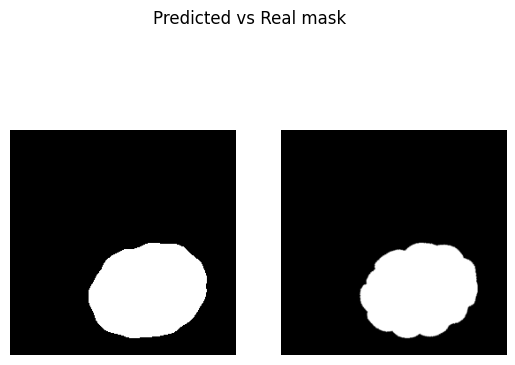

Epoch 177  train_loss=0.020291484892368317 train_iou=0.9382595916589102 val_loss=0.024201550831397373 val_iou=0.9487934311230978


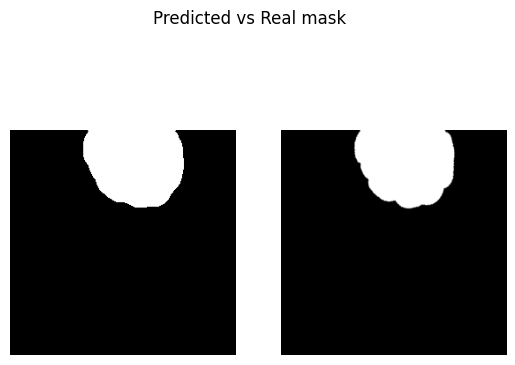

Epoch 178  train_loss=0.02019670916100343 train_iou=0.9323061207930247 val_loss=0.0263964490344127 val_iou=0.946501354376475


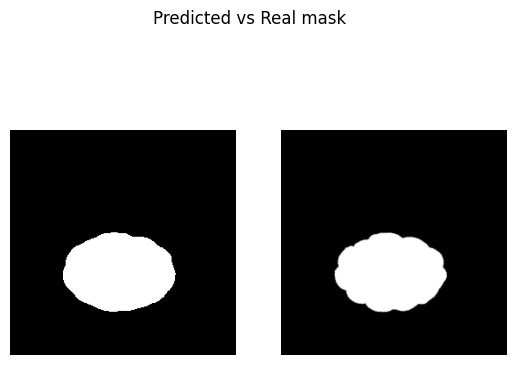

Epoch 179  train_loss=0.020549859541157883 train_iou=0.934160977602005 val_loss=0.029818791896104813 val_iou=0.9540170232454935


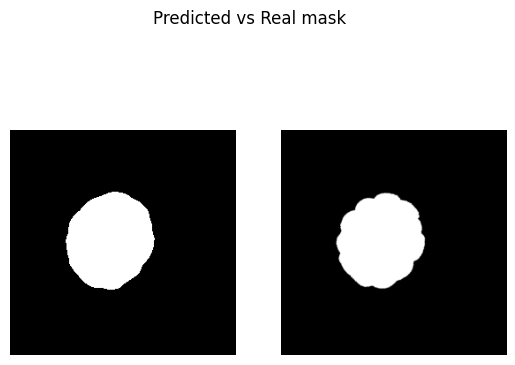

Epoch 180  train_loss=0.023037728543082874 train_iou=0.931374063094457 val_loss=0.023411356533567112 val_iou=0.9522968331972758


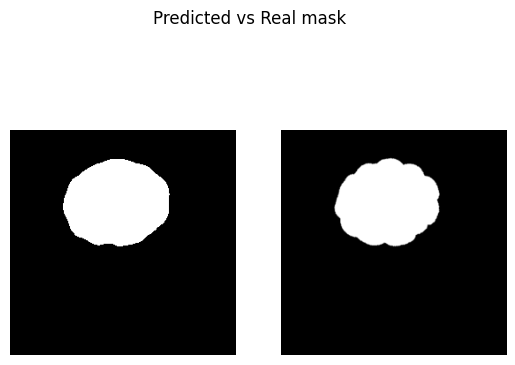

Epoch 181  train_loss=0.020860055616746347 train_iou=0.9327287673950195 val_loss=0.02068646935125192 val_iou=0.9392601052920023


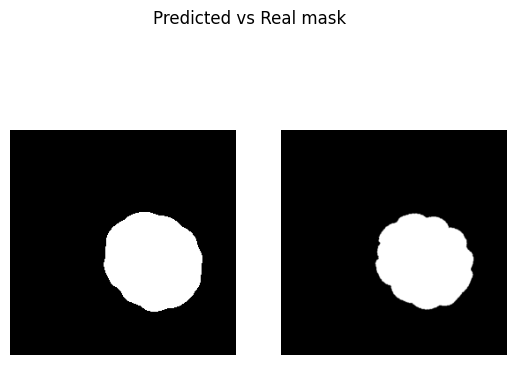

Epoch 182  train_loss=0.019470442396899063 train_iou=0.9394422074158987 val_loss=0.019926100969314575 val_iou=0.9331731994946798


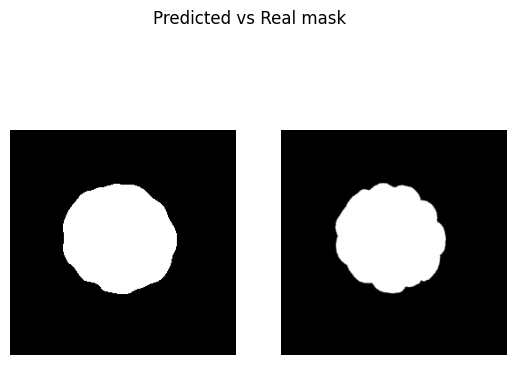

Epoch 183  train_loss=0.02015455129245917 train_iou=0.9352784554163615 val_loss=0.023295624181628227 val_iou=0.934085746606191


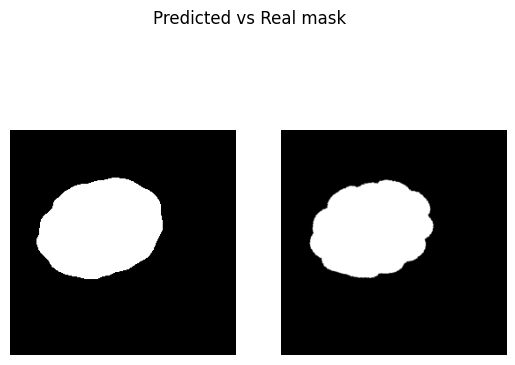

Epoch 184  train_loss=0.019734812589983147 train_iou=0.9345178405443827 val_loss=0.019622345144550007 val_iou=0.9353440801302592


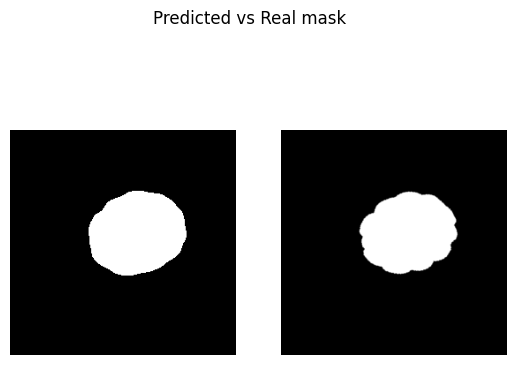

Epoch 185  train_loss=0.017868891047934692 train_iou=0.9350897669792175 val_loss=0.022325019041697185 val_iou=0.943492611249288


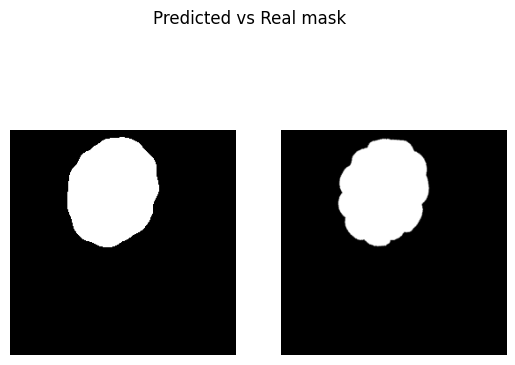

Epoch 186  train_loss=0.01833062417184313 train_iou=0.9380852381388346 val_loss=0.023121884713570278 val_iou=0.9477909008661906


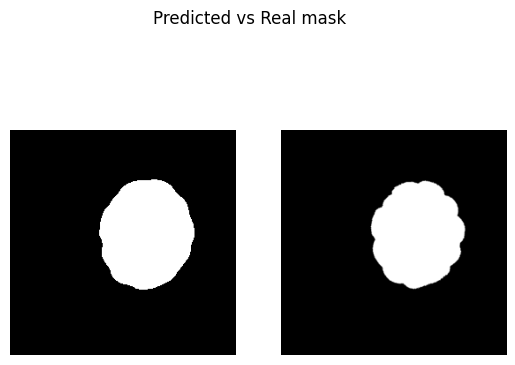

Epoch 187  train_loss=0.02094362924496333 train_iou=0.9391652941703796 val_loss=0.017871446286638577 val_iou=0.9480807582537333


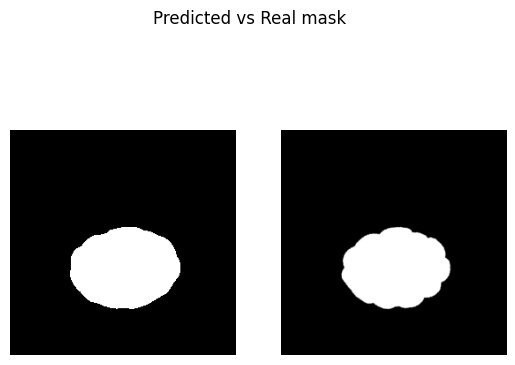

Epoch 188  train_loss=0.01962272295107444 train_iou=0.9349680046240488 val_loss=0.02758389214674632 val_iou=0.9509403506914774


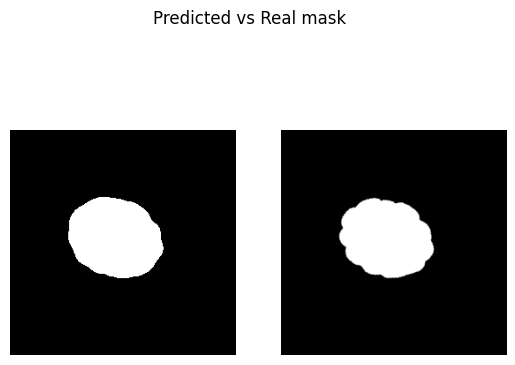

Epoch 189  train_loss=0.018877810798585415 train_iou=0.9369203249613444 val_loss=0.019947520767649014 val_iou=0.9495320916175842


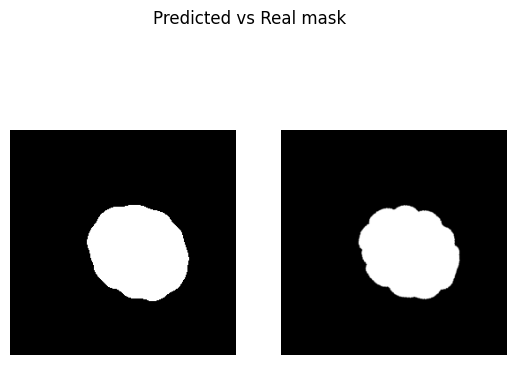

Epoch 190  train_loss=0.021200054946045082 train_iou=0.9337249596913656 val_loss=0.020351737116773922 val_iou=0.9479241569836935


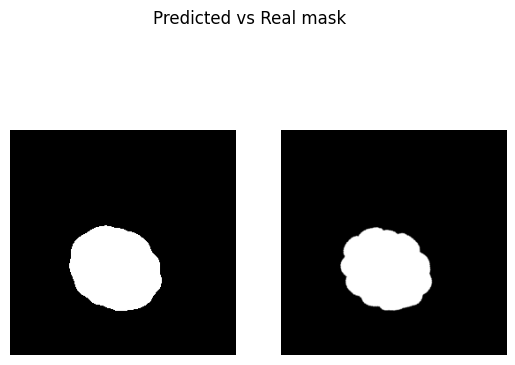

Epoch 191  train_loss=0.022041762713342905 train_iou=0.9335629940032959 val_loss=0.01811341568827629 val_iou=0.9422155618667603


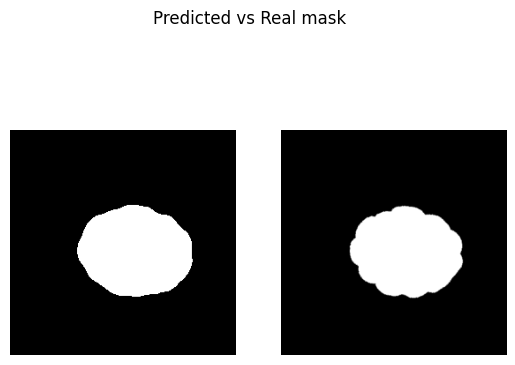

Epoch 192  train_loss=0.01801568145553271 train_iou=0.9374479651451111 val_loss=0.0196956309179465 val_iou=0.9298877914746603


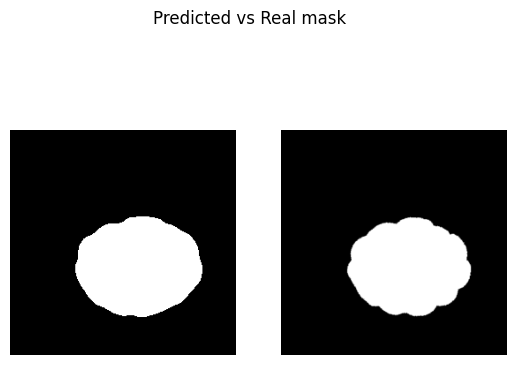

Epoch 193  train_loss=0.022033548913896084 train_iou=0.9361083805561066 val_loss=0.01694808465739091 val_iou=0.9311869343121847


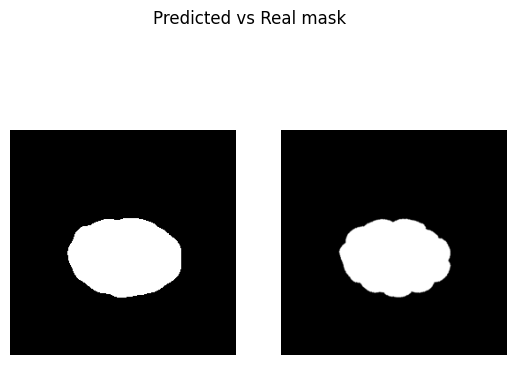

Epoch 194  train_loss=0.01865188730880618 train_iou=0.9348078866799673 val_loss=0.017999744042754173 val_iou=0.9368917942047119


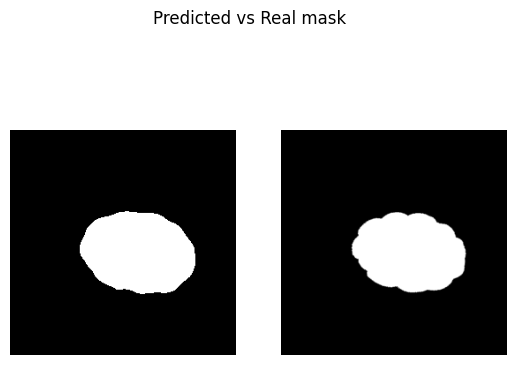

Epoch 195  train_loss=0.018625439299891394 train_iou=0.9363783101240793 val_loss=0.02382821775972843 val_iou=0.9566752115885416


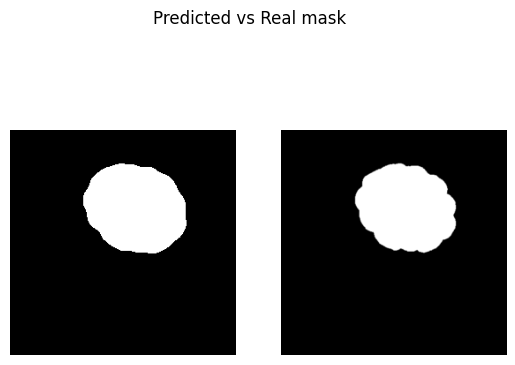

Epoch 196  train_loss=0.01930399751290679 train_iou=0.9377649823824564 val_loss=0.02239834889769554 val_iou=0.955195148785909


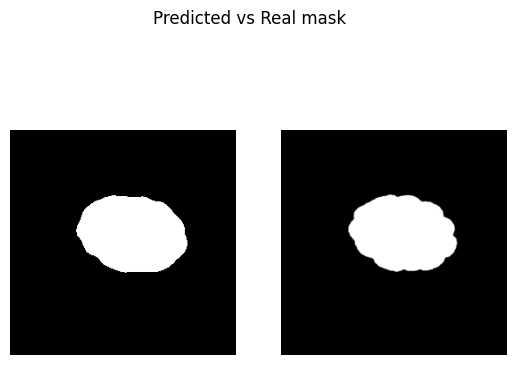

Epoch 197  train_loss=0.01992147167523702 train_iou=0.9351362784703573 val_loss=0.020287462199727695 val_iou=0.9463752110799154


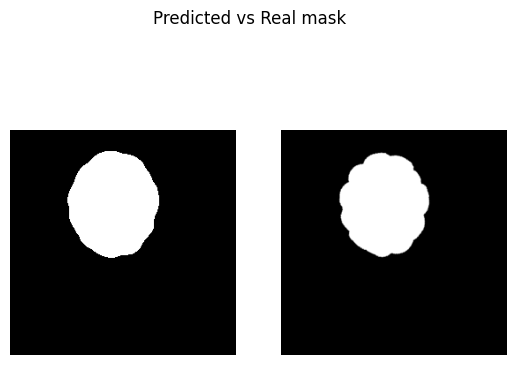

Epoch 198  train_loss=0.017622514783094328 train_iou=0.9396049479643503 val_loss=0.01898188019792239 val_iou=0.9390104413032532


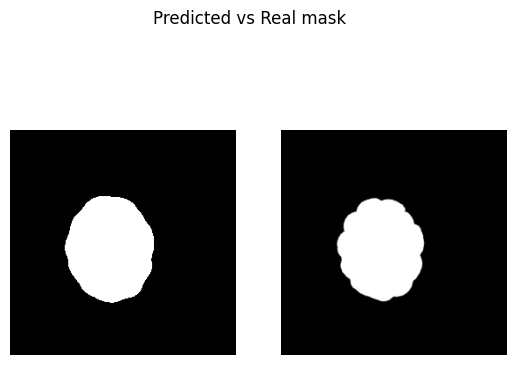

Epoch 199  train_loss=0.017954382579773664 train_iou=0.9379929900169373 val_loss=0.01892004782954852 val_iou=0.9490135908126831


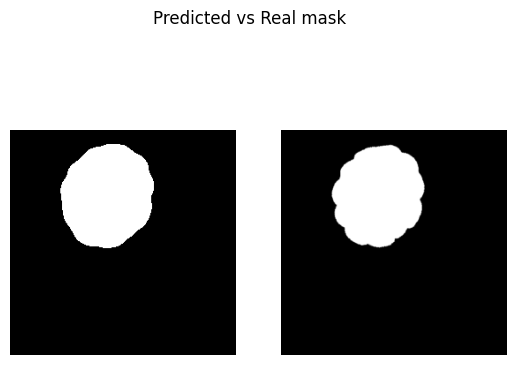

Epoch 200  train_loss=0.0183850039417545 train_iou=0.9363420307636261 val_loss=0.017061786415676277 val_iou=0.9369606574376425


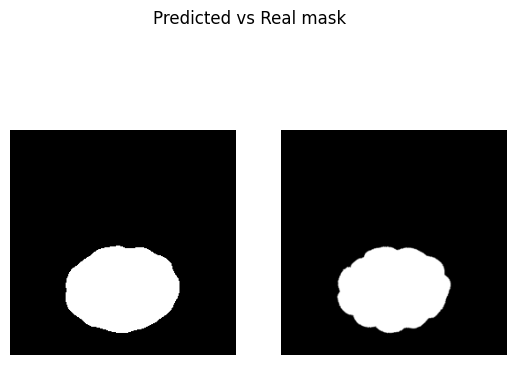

Epoch 201  train_loss=0.01810352721561988 train_iou=0.9404904544353485 val_loss=0.022488180547952652 val_iou=0.9482063055038452


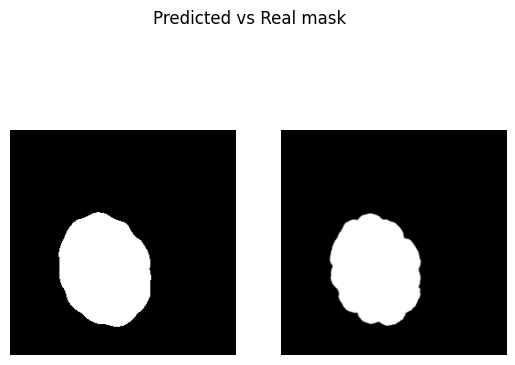

Epoch 202  train_loss=0.01899035864820083 train_iou=0.9377096096674601 val_loss=0.022135984152555466 val_iou=0.9487611254056295


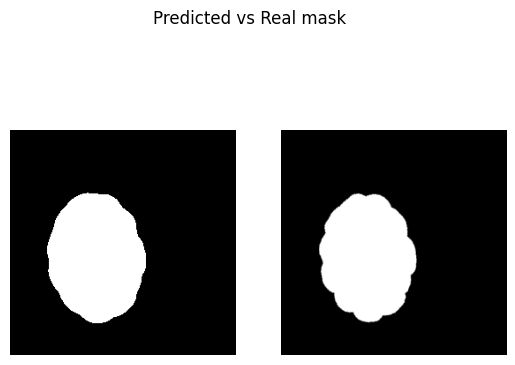

Epoch 203  train_loss=0.019901154873271782 train_iou=0.9382192492485046 val_loss=0.02236551170547803 val_iou=0.95091313123703


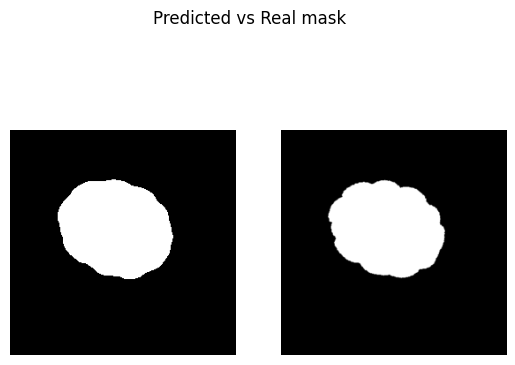

Epoch 204  train_loss=0.02190512977540493 train_iou=0.9340038398901621 val_loss=0.022991313909490902 val_iou=0.9540567199389139


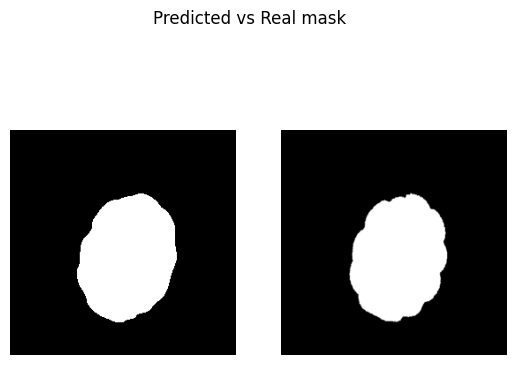

Epoch 205  train_loss=0.02050501698007186 train_iou=0.936935563882192 val_loss=0.020942576850454014 val_iou=0.947518527507782


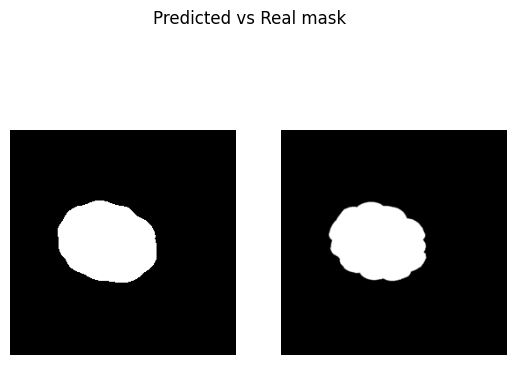

Epoch 206  train_loss=0.020304040362437565 train_iou=0.9335801204045614 val_loss=0.01910181591908137 val_iou=0.9431780179341634


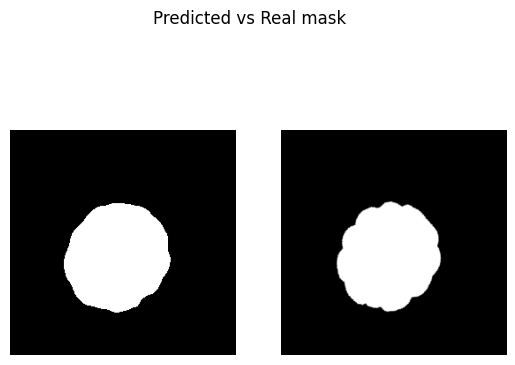

Epoch 207  train_loss=0.01766471207762758 train_iou=0.9375381072362264 val_loss=0.0207120676835378 val_iou=0.9409472346305847


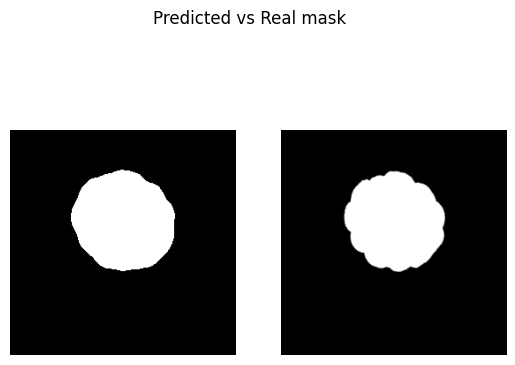

Epoch 208  train_loss=0.017640055002023775 train_iou=0.9399632215499878 val_loss=0.02041741833090782 val_iou=0.9456649025281271


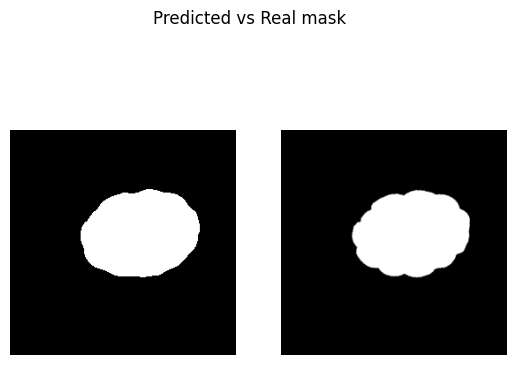

Epoch 209  train_loss=0.018964646228899557 train_iou=0.9395036995410919 val_loss=0.02226833440363407 val_iou=0.9522611498832703


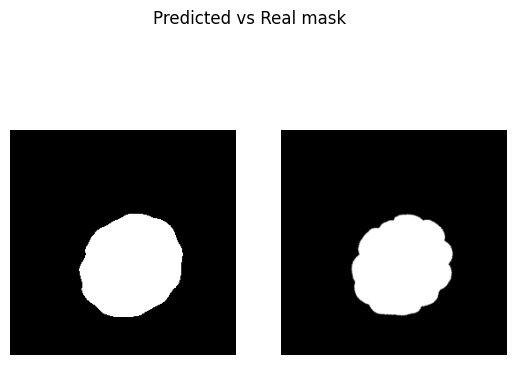

Epoch 210  train_loss=0.017372267320752144 train_iou=0.9375382761160532 val_loss=0.024842315663894016 val_iou=0.9591280023256937


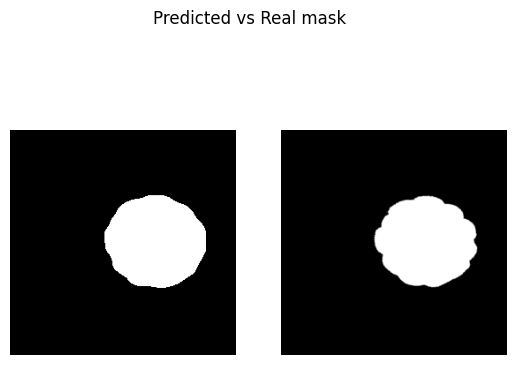

Epoch 211  train_loss=0.020149502127120893 train_iou=0.9428297281265259 val_loss=0.02700451637307803 val_iou=0.9493983189264933


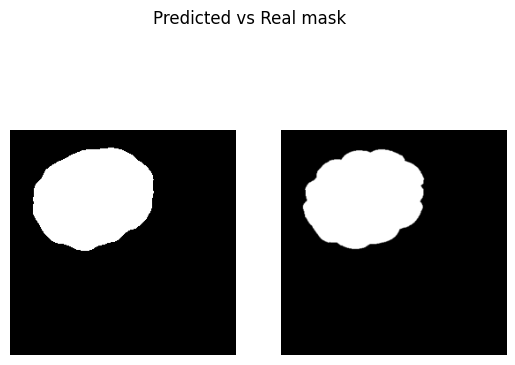

Epoch 212  train_loss=0.020825593421856563 train_iou=0.9416530529657999 val_loss=0.019147867957750957 val_iou=0.9569000601768494


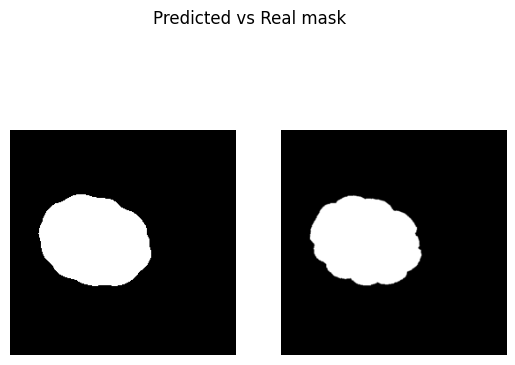

Epoch 213  train_loss=0.019531289891650278 train_iou=0.9403768380482992 val_loss=0.023131709545850754 val_iou=0.9372461835543314


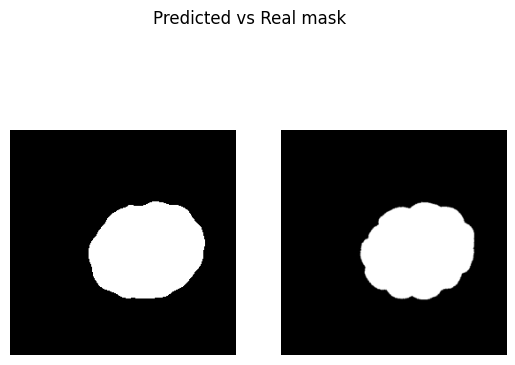

Epoch 214  train_loss=0.019794791315992672 train_iou=0.9362505376338959 val_loss=0.022312894463539124 val_iou=0.9428308208783468


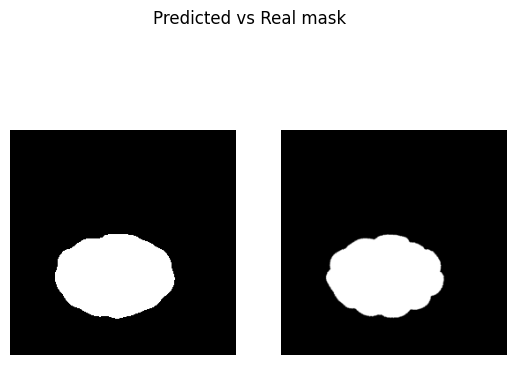

Epoch 215  train_loss=0.01895870330433051 train_iou=0.9347829421361288 val_loss=0.022009397546450298 val_iou=0.947345495223999


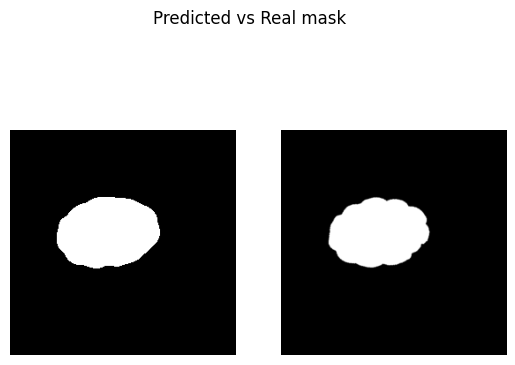

Epoch 216  train_loss=0.01954922266304493 train_iou=0.9369649191697439 val_loss=0.017335611085096996 val_iou=0.9445287982622782


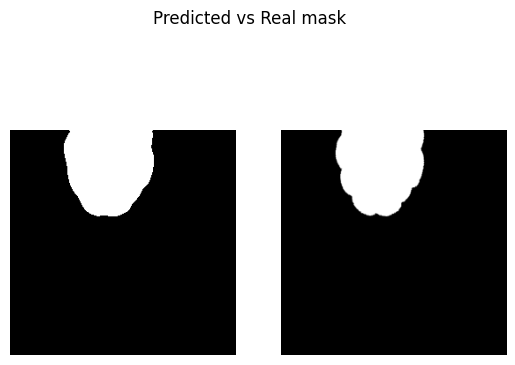

Epoch 217  train_loss=0.018040826233724754 train_iou=0.9391801357269287 val_loss=0.02064138526717822 val_iou=0.9491020242373148


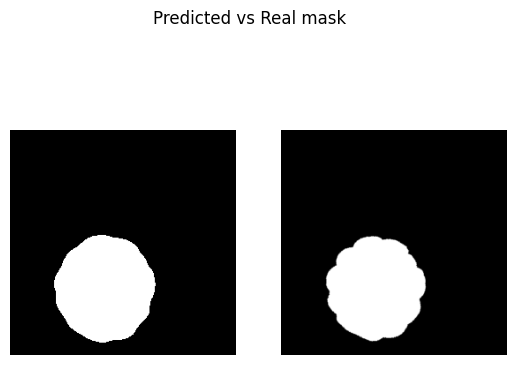

Epoch 218  train_loss=0.01655296313886841 train_iou=0.9414030611515045 val_loss=0.023259190532068413 val_iou=0.9474165638287863


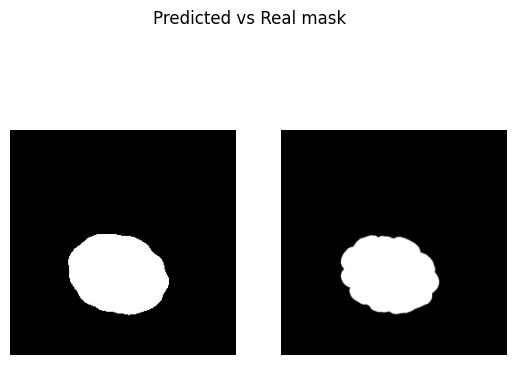

Epoch 219  train_loss=0.01822354489316543 train_iou=0.9392353395620981 val_loss=0.020834398145476978 val_iou=0.9510335922241211


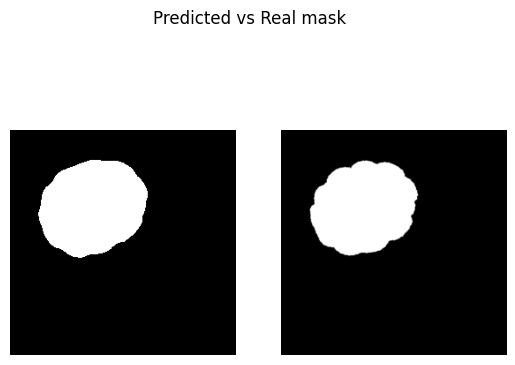

Epoch 220  train_loss=0.017686542123556137 train_iou=0.9359090824921926 val_loss=0.0222902645667394 val_iou=0.9531277616818746


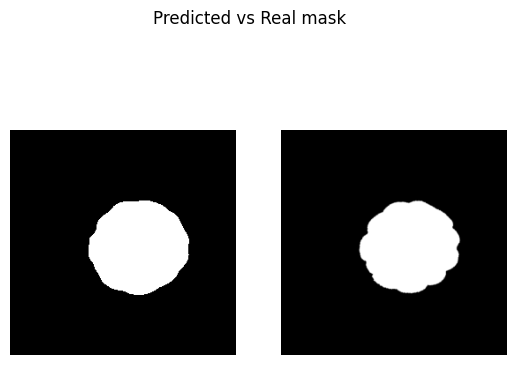

Epoch 221  train_loss=0.017741513438522816 train_iou=0.9418071508407593 val_loss=0.02060988297065099 val_iou=0.953701376914978


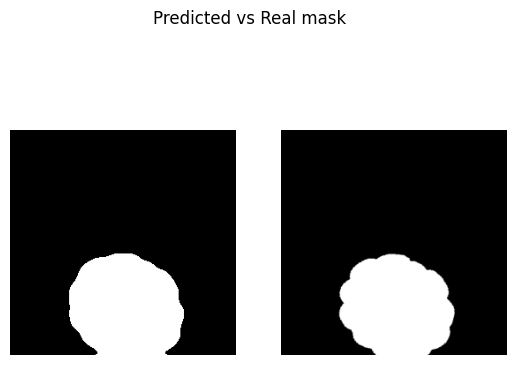

Epoch 222  train_loss=0.01902641262859106 train_iou=0.9398939808209738 val_loss=0.02418402209877968 val_iou=0.946241577466329


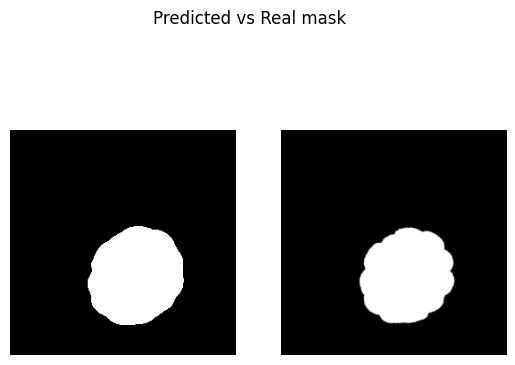

Epoch 223  train_loss=0.020483252592384815 train_iou=0.9343546330928802 val_loss=0.022755150993665058 val_iou=0.9522989392280579


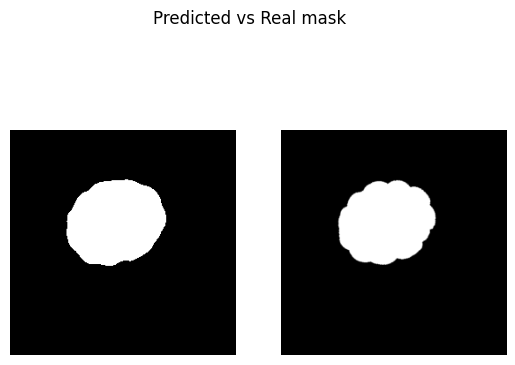

Epoch 224  train_loss=0.019095178538312513 train_iou=0.9409402906894684 val_loss=0.020510638132691383 val_iou=0.94443412621816


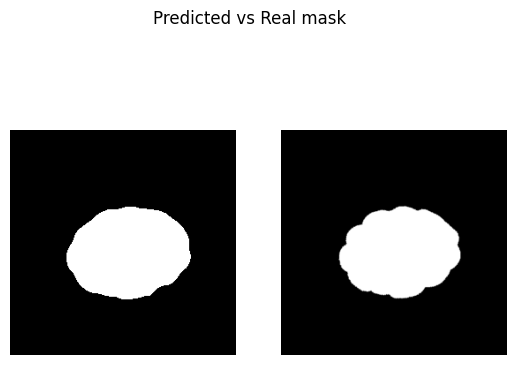

Epoch 225  train_loss=0.018454373814165592 train_iou=0.9413535594940186 val_loss=0.023048972090085346 val_iou=0.9440653125445048


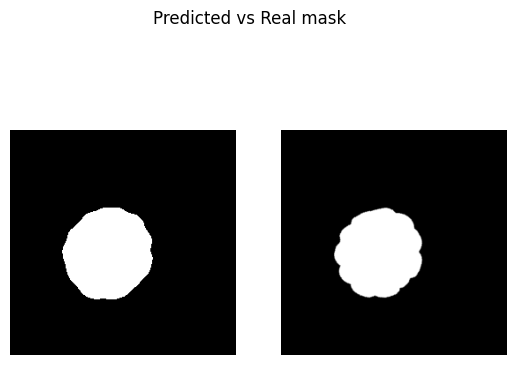

Epoch 226  train_loss=0.018155995445946854 train_iou=0.9372254212697347 val_loss=0.01998189464211464 val_iou=0.9517847299575806


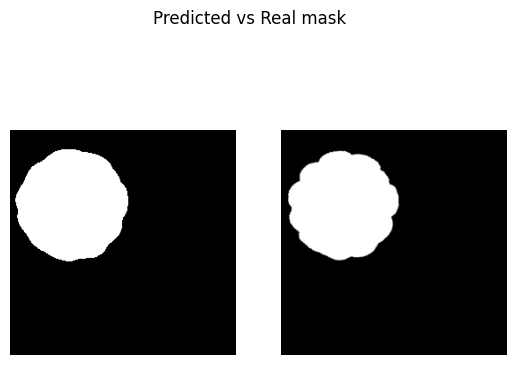

Epoch 227  train_loss=0.018368179444223642 train_iou=0.9395545721054077 val_loss=0.0208327720562617 val_iou=0.9484811822573344


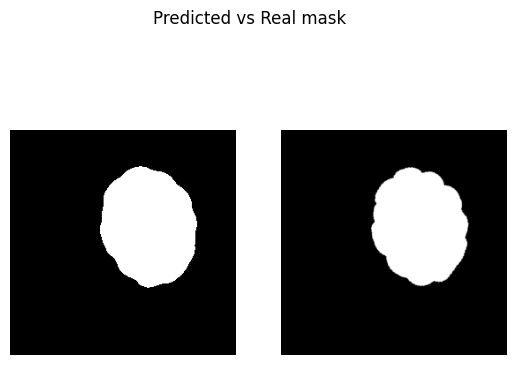

Epoch 228  train_loss=0.018854862699906032 train_iou=0.9361433784166971 val_loss=0.0208605770021677 val_iou=0.9521816770235697


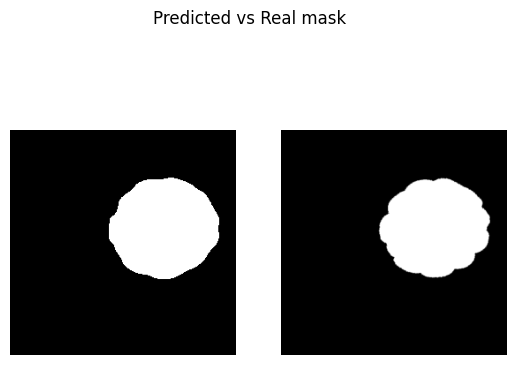

Epoch 229  train_loss=0.018961715046316385 train_iou=0.941996693611145 val_loss=0.019357134277621906 val_iou=0.9501969814300537


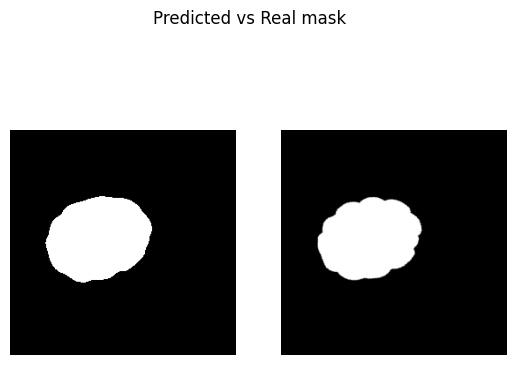

Epoch 230  train_loss=0.020007192933311064 train_iou=0.9404048224290212 val_loss=0.01933712139725685 val_iou=0.9491122563680013


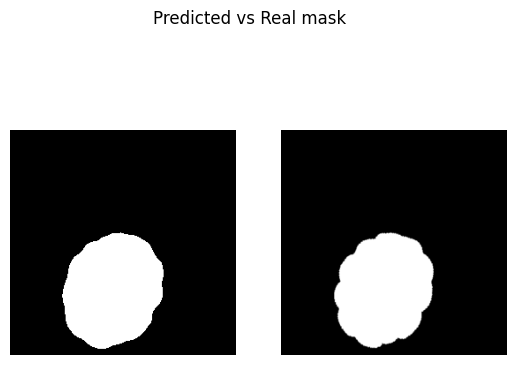

Epoch 231  train_loss=0.018825138298173744 train_iou=0.9397888978322347 val_loss=0.01778313082953294 val_iou=0.9426801800727844


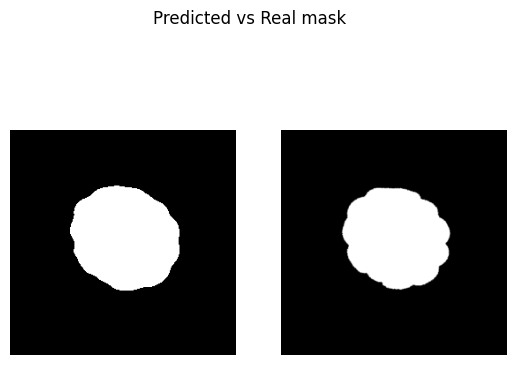

Epoch 232  train_loss=0.020162262643376987 train_iou=0.9417421420415243 val_loss=0.018617933616042137 val_iou=0.9299529592196146


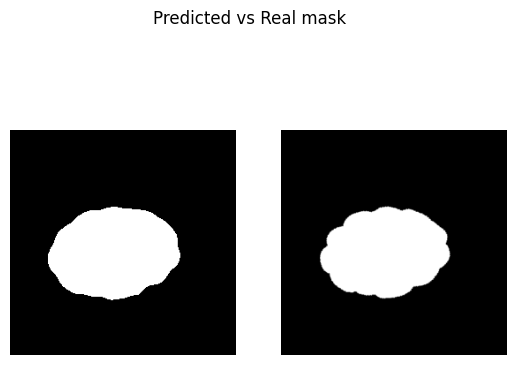

Epoch 233  train_loss=0.01832285492370526 train_iou=0.9320975641409556 val_loss=0.017856306085983913 val_iou=0.9439599712689718


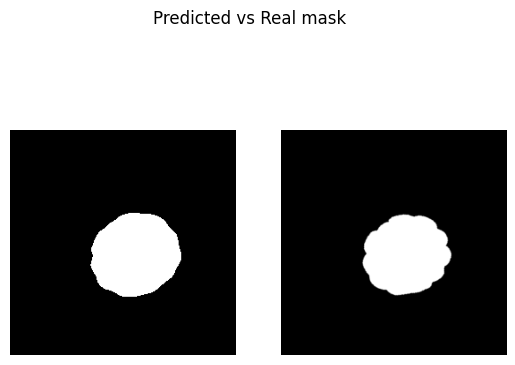

Epoch 234  train_loss=0.016579959852000076 train_iou=0.9369450410207113 val_loss=0.022448561464746792 val_iou=0.9581114252408346


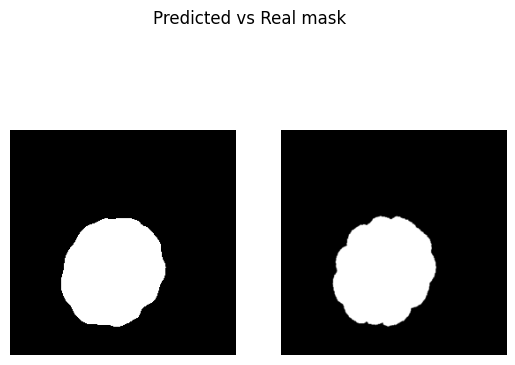

Epoch 235  train_loss=0.01826705566296975 train_iou=0.9406425654888153 val_loss=0.01881340021888415 val_iou=0.9550793369611105


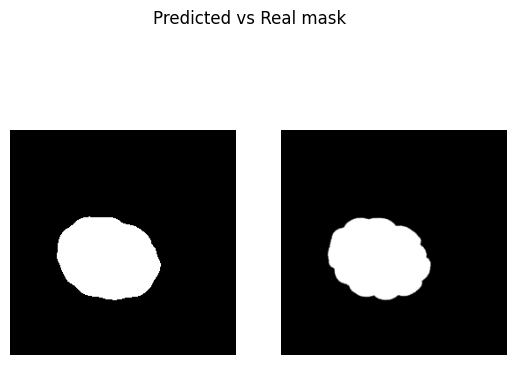

Epoch 236  train_loss=0.017415324226021767 train_iou=0.9409842689832052 val_loss=0.023766451825698216 val_iou=0.9636793732643127


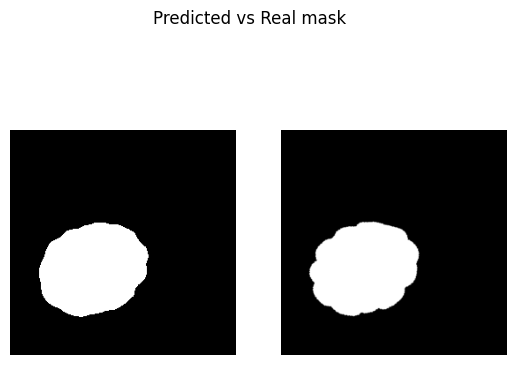

Epoch 237  train_loss=0.020136207963029545 train_iou=0.9387761851151785 val_loss=0.02315661186973254 val_iou=0.9465614557266235


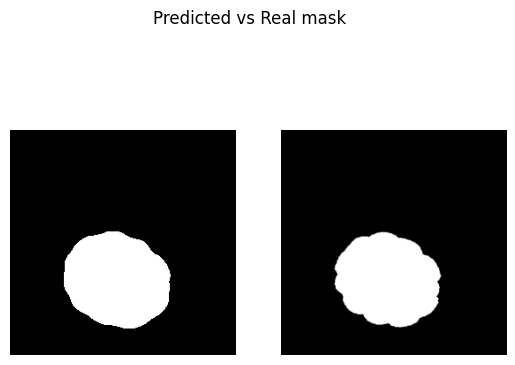

Epoch 238  train_loss=0.019458461552858353 train_iou=0.9414893090724945 val_loss=0.01754961380114158 val_iou=0.9441503882408142


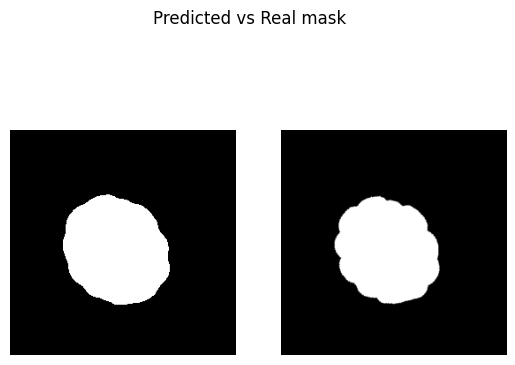

Epoch 239  train_loss=0.019836311228573322 train_iou=0.9388893644014994 val_loss=0.018298699830969174 val_iou=0.9472262263298035


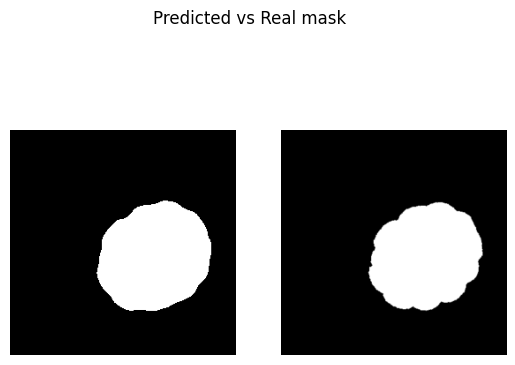

Epoch 240  train_loss=0.017766947858035564 train_iou=0.942022442817688 val_loss=0.018283520825207233 val_iou=0.9421506722768148


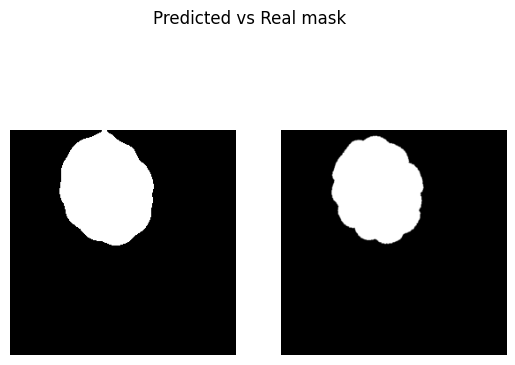

Epoch 241  train_loss=0.01694519833351175 train_iou=0.9403820137182871 val_loss=0.019590821117162704 val_iou=0.9472936789194742


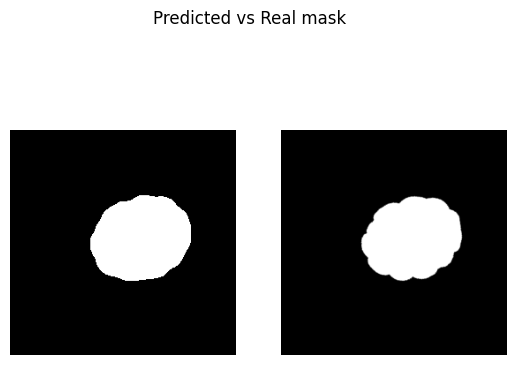

Epoch 242  train_loss=0.019201679931332667 train_iou=0.9405008653799692 val_loss=0.017417441122233868 val_iou=0.9374363819758097


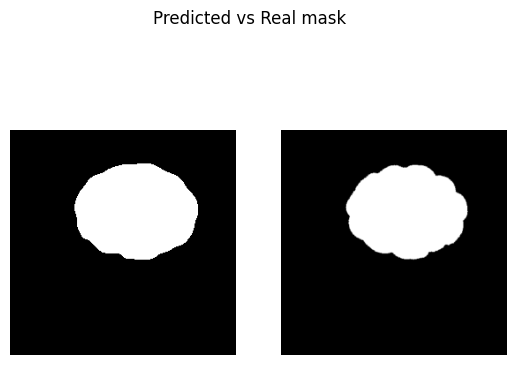

Epoch 243  train_loss=0.015998160776992638 train_iou=0.9427251120408376 val_loss=0.020115815723935764 val_iou=0.9525841673215231


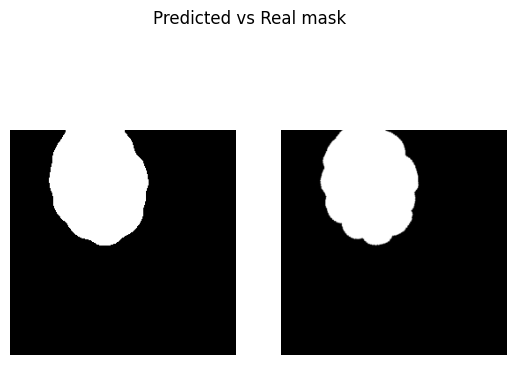

Epoch 244  train_loss=0.01719031607111295 train_iou=0.944787472486496 val_loss=0.01849297309915225 val_iou=0.949189285437266


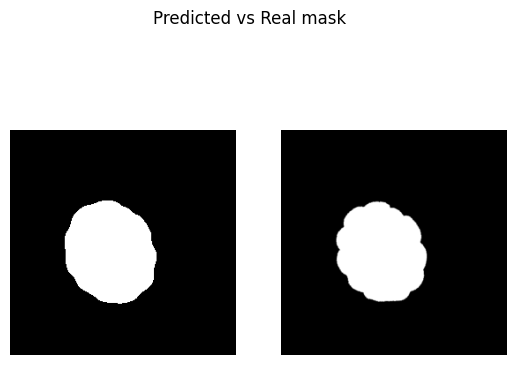

Epoch 245  train_loss=0.017059110725919407 train_iou=0.9384563664595286 val_loss=0.02130871204038461 val_iou=0.959991455078125


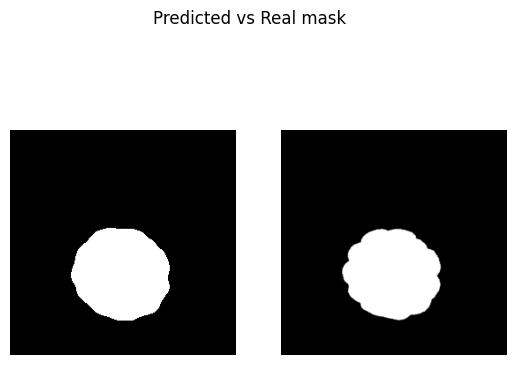

Epoch 246  train_loss=0.01830628312503298 train_iou=0.9406058092912039 val_loss=0.018623499820629757 val_iou=0.9525619546572367


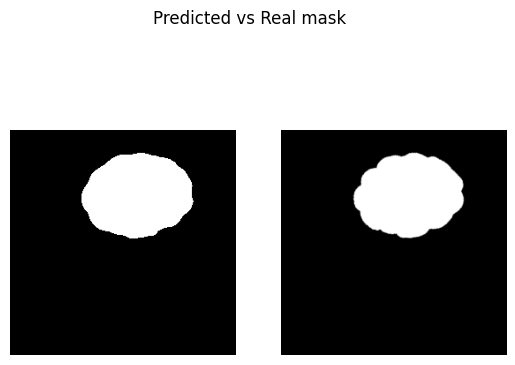

Epoch 247  train_loss=0.01952887900794546 train_iou=0.9382927219072977 val_loss=0.018402947733799618 val_iou=0.9430505235989889


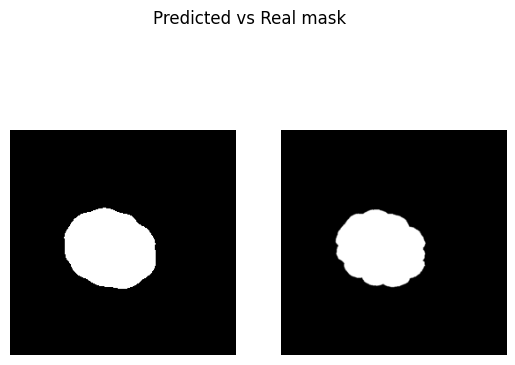

Epoch 248  train_loss=0.01880607350418965 train_iou=0.9398315648237864 val_loss=0.021127817531426746 val_iou=0.9240519404411316


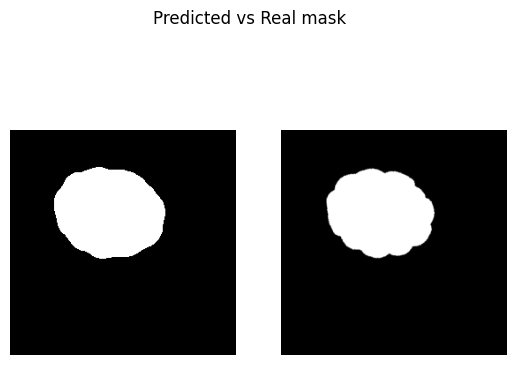

Epoch 249  train_loss=0.016783581270525854 train_iou=0.9394180079301199 val_loss=0.016353001197179157 val_iou=0.9473878939946493


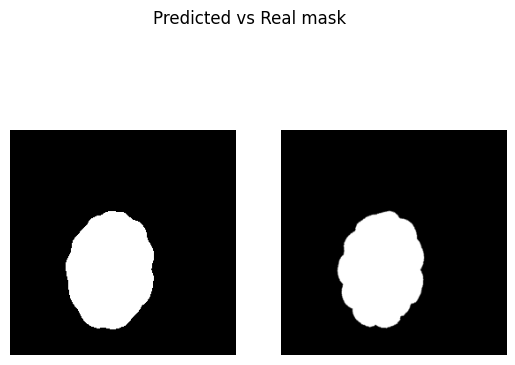

Epoch 250  train_loss=0.016421239047000807 train_iou=0.9453063607215881 val_loss=0.020508839438358944 val_iou=0.9516138633092245


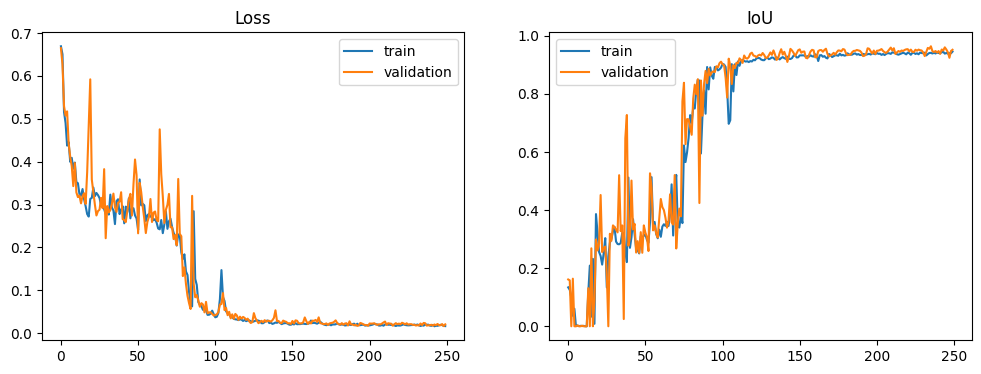

In [ ]:
# Load images with data augmentation
transf = transforms.Compose([
        transforms.ToPILImage(),
        # Define your transformations here!
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(180),
        transforms.RandomResizedCrop(256, scale=(0.5, 1.0)),
        transforms.ToTensor()
    ])


augmented_dataset = EmbryoDataset("res/unet/images", "res/unet/masks", transf)

train_dataset, valid_dataset = torch.utils.data.random_split(augmented_dataset, [12, 3])

# Hyperparameters
BATCH_SIZE = 2
LR = 0.0001
N_INPUT_CHANNELS = 1
N_CLASSES = 1
THRESHOLD = 0.25
EPOCHS = 250


# Model
unet_augmented = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet_augmented.to(device)

adam_optimizer = torch.optim.Adam(unet_augmented.parameters(), lr=LR)

train_model(unet_augmented, train_dataset, valid_dataset, device, adam_optimizer, bce_loss, BATCH_SIZE, EPOCHS, THRESHOLD, 'trained-unet-augmented.pt')



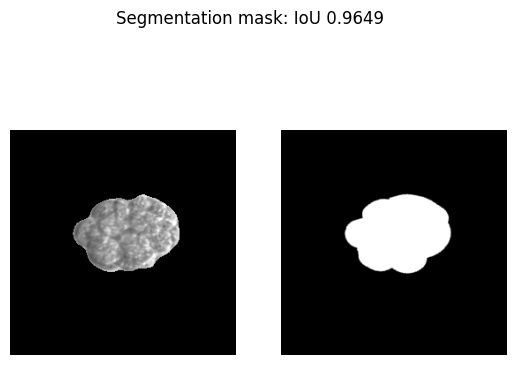

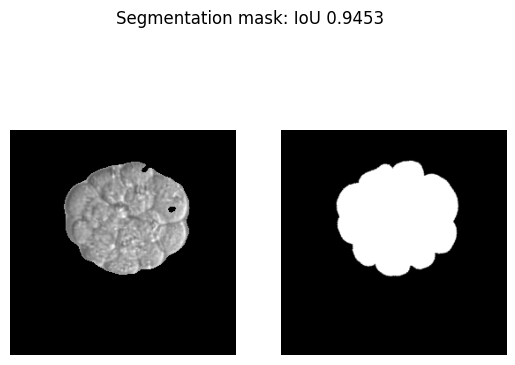

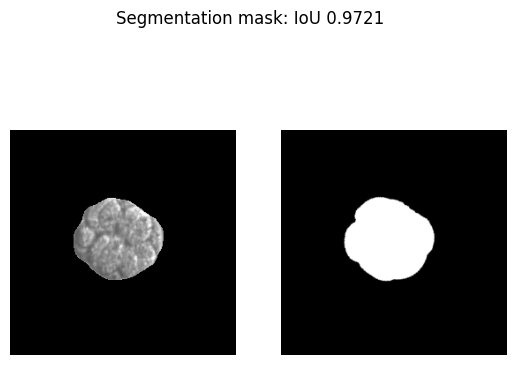

In [ ]:
unet = torch.load('trained-unet-augmented.pt', map_location=device)

check_segmentation_results_with_acc(unet_augmented, valid_dataset, 0.3)